In [36]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [37]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [38]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [39]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [40]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [41]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [42]:
nan_col_list = ['착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', 'PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [43]:
# NEW: 착상 전 유전 검사/진단 관련 변수와 실제 시술 여부를 합쳐서 새로운 특성 생성
train['PGS'] = train['착상 전 유전 검사 사용 여부'].astype(int) + train['PGS 시술 여부'].astype(int)
test['PGS'] = test['착상 전 유전 검사 사용 여부'].astype(int) + test['PGS 시술 여부'].astype(int)

train['PGD'] = train['착상 전 유전 진단 사용 여부'].astype(int) + train['PGD 시술 여부'].astype(int)
test['PGD'] = test['착상 전 유전 진단 사용 여부'].astype(int) + test['PGD 시술 여부'].astype(int)

In [44]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [45]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 66), (90067, 65))

In [46]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [47]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [48]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [49]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [50]:
# train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
# test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

In [51]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부', 'PGS',
       'PGD', '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',
       '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [52]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

# DI 시술인 경우, 배아 관련 수치형 변수에 대해 결측치를 0으로 보간
# embryo_cols = ["이식된 배아 수", "미세주입 배아 이식 수", "배아 이식 경과일", "배아 해동 경과일",
#                "미세주입에서 생성된 배아 수", "저장된 배아 수", "미세주입 후 저장된 배아 수", "해동된 배아 수"]
# di_mask_train = train["시술 유형"] == "DI"
# di_mask_test = test["시술 유형"] == "DI"
# for col in embryo_cols:
#     if col in train.columns:
#         train.loc[di_mask_train, col] = train.loc[di_mask_train, col].fillna(0)
#     if col in test.columns:
#         test.loc[di_mask_test, col] = test.loc[di_mask_test, col].fillna(0)

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [53]:
len(categorical_columns) + len(numeric_columns)

59

In [54]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [55]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 69), (90067, 69))

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 69), (90067, 69))

In [57]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [58]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [59]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [60]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 40)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-26 17:31:06,882] A new study created in memory with name: no-name-02de5c0c-0544-43bf-857e-ab90b0584d83


Seed 4972 Start!
0:	test: 0.7226969	best: 0.7226969 (0)	total: 161ms	remaining: 6m 19s
300:	test: 0.7389440	best: 0.7389440 (300)	total: 38.7s	remaining: 4m 25s
600:	test: 0.7403148	best: 0.7403264 (595)	total: 1m 20s	remaining: 3m 56s
900:	test: 0.7407689	best: 0.7407857 (874)	total: 2m 3s	remaining: 3m 21s
1200:	test: 0.7408894	best: 0.7409179 (1070)	total: 2m 49s	remaining: 2m 44s
1500:	test: 0.7410769	best: 0.7410924 (1490)	total: 3m 41s	remaining: 2m 7s
1800:	test: 0.7410359	best: 0.7411490 (1559)	total: 4m 34s	remaining: 1m 26s


[I 2025-02-26 17:35:51,960] Trial 0 finished with value: 0.7411490087295263 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7411490087295263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411490087
bestIteration = 1559

Shrink model to first 1560 iterations.
저장 완료
0:	test: 0.6965597	best: 0.6965597 (0)	total: 68.3ms	remaining: 2m 29s
300:	test: 0.7309489	best: 0.7309489 (300)	total: 13.9s	remaining: 1m 27s


Training has stopped (degenerate solution on iteration 424, probably too small l2-regularization, try to increase it)
[I 2025-02-26 17:36:12,060] Trial 1 finished with value: 0.7326510483989915 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7411490087295263.



bestTest = 0.7326510484
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.6965597	best: 0.6965597 (0)	total: 51.8ms	remaining: 2m 11s
300:	test: 0.7407950	best: 0.7408506 (297)	total: 15.4s	remaining: 1m 54s
600:	test: 0.7410446	best: 0.7411391 (451)	total: 31.2s	remaining: 1m 40s


[I 2025-02-26 17:36:51,644] Trial 2 finished with value: 0.7411390582120283 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7411490087295263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411390582
bestIteration = 451

Shrink model to first 452 iterations.
0:	test: 0.6965597	best: 0.6965597 (0)	total: 51.6ms	remaining: 2m
300:	test: 0.7372302	best: 0.7372302 (300)	total: 15.7s	remaining: 1m 45s
600:	test: 0.7384931	best: 0.7385309 (587)	total: 31.2s	remaining: 1m 29s
900:	test: 0.7387245	best: 0.7387937 (798)	total: 47.2s	remaining: 1m 15s
1200:	test: 0.7388884	best: 0.7389703 (1081)	total: 1m 3s	remaining: 59.9s


[I 2025-02-26 17:38:04,878] Trial 3 finished with value: 0.7389702662892692 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7411490087295263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389702663
bestIteration = 1081

Shrink model to first 1082 iterations.
0:	test: 0.7201807	best: 0.7201807 (0)	total: 113ms	remaining: 3m 16s
300:	test: 0.7378597	best: 0.7378597 (300)	total: 40.6s	remaining: 3m 14s
600:	test: 0.7383730	best: 0.7385258 (479)	total: 1m 23s	remaining: 2m 38s


[I 2025-02-26 17:39:53,562] Trial 4 finished with value: 0.7385257648400156 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7411490087295263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385257648
bestIteration = 479

Shrink model to first 480 iterations.
0:	test: 0.6965597	best: 0.6965597 (0)	total: 60.6ms	remaining: 2m 6s
300:	test: 0.7400021	best: 0.7400021 (300)	total: 15.2s	remaining: 1m 29s
600:	test: 0.7403250	best: 0.7404885 (457)	total: 31s	remaining: 1m 16s


[I 2025-02-26 17:40:33,208] Trial 5 finished with value: 0.7404884587537033 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7411490087295263.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404884588
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.6981929	best: 0.6981929 (0)	total: 58.6ms	remaining: 1m 57s
300:	test: 0.7405094	best: 0.7405094 (300)	total: 18.9s	remaining: 1m 46s
600:	test: 0.7410055	best: 0.7410085 (595)	total: 38.5s	remaining: 1m 29s
900:	test: 0.7410866	best: 0.7412274 (719)	total: 58.3s	remaining: 1m 10s


[I 2025-02-26 17:41:39,604] Trial 6 finished with value: 0.7412273740181696 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412273740181696.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741227374
bestIteration = 719

Shrink model to first 720 iterations.
저장 완료
0:	test: 0.7178501	best: 0.7178501 (0)	total: 80.8ms	remaining: 2m 35s
300:	test: 0.7401691	best: 0.7408948 (206)	total: 26.5s	remaining: 2m 23s


[I 2025-02-26 17:42:25,394] Trial 7 finished with value: 0.7408948297881393 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412273740181696.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408948298
bestIteration = 206

Shrink model to first 207 iterations.
0:	test: 0.7178501	best: 0.7178501 (0)	total: 76ms	remaining: 2m 24s
300:	test: 0.7410290	best: 0.7410403 (299)	total: 25.6s	remaining: 2m 16s
600:	test: 0.7412252	best: 0.7413886 (530)	total: 53.2s	remaining: 1m 55s


[I 2025-02-26 17:43:39,844] Trial 8 finished with value: 0.7413885914608884 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7413885914608884.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413885915
bestIteration = 530

Shrink model to first 531 iterations.
저장 완료
0:	test: 0.7179288	best: 0.7179288 (0)	total: 72.6ms	remaining: 3m 11s
300:	test: 0.7400775	best: 0.7400775 (300)	total: 21s	remaining: 2m 43s
600:	test: 0.7409271	best: 0.7409825 (584)	total: 44.2s	remaining: 2m 30s
900:	test: 0.7408390	best: 0.7410016 (772)	total: 1m 7s	remaining: 2m 10s


[I 2025-02-26 17:45:01,405] Trial 9 finished with value: 0.7410016132147447 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7413885914608884.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410016132
bestIteration = 772

Shrink model to first 773 iterations.
0:	test: 0.7208587	best: 0.7208587 (0)	total: 83.9ms	remaining: 4m 6s
300:	test: 0.7402044	best: 0.7402046 (299)	total: 27.5s	remaining: 4m 1s
600:	test: 0.7409343	best: 0.7410526 (509)	total: 58s	remaining: 3m 46s


[I 2025-02-26 17:46:21,119] Trial 10 finished with value: 0.7410525530347692 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7413885914608884.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741052553
bestIteration = 509

Shrink model to first 510 iterations.
0:	test: 0.7179253	best: 0.7179253 (0)	total: 65.4ms	remaining: 1m 47s
300:	test: 0.7408656	best: 0.7409030 (291)	total: 21.2s	remaining: 1m 34s
600:	test: 0.7415207	best: 0.7415438 (590)	total: 43.1s	remaining: 1m 14s
900:	test: 0.7415248	best: 0.7415970 (701)	total: 1m 5s	remaining: 54s


[I 2025-02-26 17:47:34,681] Trial 11 finished with value: 0.7415970361402875 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415970361
bestIteration = 701

Shrink model to first 702 iterations.
저장 완료
0:	test: 0.7178556	best: 0.7178556 (0)	total: 79.6ms	remaining: 2m 3s
300:	test: 0.7408111	best: 0.7408111 (300)	total: 24.8s	remaining: 1m 43s
600:	test: 0.7409128	best: 0.7410429 (545)	total: 52.3s	remaining: 1m 22s


[I 2025-02-26 17:48:49,685] Trial 12 finished with value: 0.7410428804646874 and parameters: {'iterations': 1553, 'depth': 7, 'learning_rate': 0.06294305307719734, 'l2_leaf_reg': 6.4688552126590215}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410428805
bestIteration = 545

Shrink model to first 546 iterations.
0:	test: 0.7213133	best: 0.7213133 (0)	total: 139ms	remaining: 3m 44s
300:	test: 0.7410293	best: 0.7410317 (296)	total: 27.1s	remaining: 1m 58s
600:	test: 0.7413857	best: 0.7414365 (546)	total: 58.1s	remaining: 1m 37s
900:	test: 0.7413097	best: 0.7415233 (699)	total: 1m 29s	remaining: 1m 10s


[I 2025-02-26 17:50:29,863] Trial 13 finished with value: 0.7415233403682353 and parameters: {'iterations': 1614, 'depth': 8, 'learning_rate': 0.06125191144809531, 'l2_leaf_reg': 55.074044317639256}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415233404
bestIteration = 699

Shrink model to first 700 iterations.
0:	test: 0.7211195	best: 0.7211195 (0)	total: 117ms	remaining: 2m 58s
300:	test: 0.7409670	best: 0.7409670 (299)	total: 30.7s	remaining: 2m 5s
600:	test: 0.7409827	best: 0.7410310 (352)	total: 1m 4s	remaining: 1m 40s
900:	test: 0.7410142	best: 0.7411297 (683)	total: 1m 39s	remaining: 1m 9s


[I 2025-02-26 17:52:18,700] Trial 14 finished with value: 0.7411296913841041 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.06537754406648674, 'l2_leaf_reg': 92.74223128282539}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411296914
bestIteration = 683

Shrink model to first 684 iterations.
0:	test: 0.7208562	best: 0.7208562 (0)	total: 89ms	remaining: 2m 35s
300:	test: 0.7394491	best: 0.7397687 (213)	total: 29.1s	remaining: 2m 19s


[I 2025-02-26 17:53:10,115] Trial 15 finished with value: 0.7397686543594357 and parameters: {'iterations': 1748, 'depth': 8, 'learning_rate': 0.0740693024426437, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7397686544
bestIteration = 213

Shrink model to first 214 iterations.
0:	test: 0.7179359	best: 0.7179359 (0)	total: 65.6ms	remaining: 1m 49s
300:	test: 0.7410385	best: 0.7410522 (293)	total: 22.2s	remaining: 1m 40s
600:	test: 0.7411009	best: 0.7412934 (373)	total: 45.6s	remaining: 1m 20s


[I 2025-02-26 17:54:01,541] Trial 16 finished with value: 0.7412934421189872 and parameters: {'iterations': 1664, 'depth': 6, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 12.736017331457647}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412934421
bestIteration = 373

Shrink model to first 374 iterations.
0:	test: 0.7213088	best: 0.7213088 (0)	total: 78.3ms	remaining: 2m 21s
300:	test: 0.7409768	best: 0.7409768 (300)	total: 28.1s	remaining: 2m 20s
600:	test: 0.7408216	best: 0.7411253 (352)	total: 58.9s	remaining: 1m 57s


[I 2025-02-26 17:55:05,954] Trial 17 finished with value: 0.7411252720201875 and parameters: {'iterations': 1805, 'depth': 8, 'learning_rate': 0.05776159026026767, 'l2_leaf_reg': 18.13147711398956}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741125272
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.7179288	best: 0.7179288 (0)	total: 64.3ms	remaining: 1m 38s
300:	test: 0.7393934	best: 0.7393934 (300)	total: 21.3s	remaining: 1m 27s
600:	test: 0.7408388	best: 0.7408388 (600)	total: 43.8s	remaining: 1m 7s
900:	test: 0.7411364	best: 0.7411364 (900)	total: 1m 6s	remaining: 46.6s
1200:	test: 0.7411272	best: 0.7411838 (1129)	total: 1m 30s	remaining: 24.8s


[I 2025-02-26 17:56:54,372] Trial 18 finished with value: 0.7411837640685766 and parameters: {'iterations': 1531, 'depth': 6, 'learning_rate': 0.028707279694609546, 'l2_leaf_reg': 1.6704850246426424}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411837641
bestIteration = 1129

Shrink model to first 1130 iterations.
0:	test: 0.7206015	best: 0.7206015 (0)	total: 124ms	remaining: 4m 30s
300:	test: 0.7353574	best: 0.7393481 (139)	total: 33.6s	remaining: 3m 30s


[I 2025-02-26 17:57:44,826] Trial 19 finished with value: 0.7393481437428728 and parameters: {'iterations': 2190, 'depth': 9, 'learning_rate': 0.08586504560971463, 'l2_leaf_reg': 0.006971472154688638}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393481437
bestIteration = 139

Shrink model to first 140 iterations.
0:	test: 0.6981929	best: 0.6981929 (0)	total: 60ms	remaining: 2m 57s
300:	test: 0.7402137	best: 0.7402400 (295)	total: 18.4s	remaining: 2m 43s
600:	test: 0.7409190	best: 0.7409190 (600)	total: 37.4s	remaining: 2m 27s
900:	test: 0.7411427	best: 0.7411673 (786)	total: 57.1s	remaining: 2m 10s
1200:	test: 0.7412044	best: 0.7412332 (1045)	total: 1m 16s	remaining: 1m 53s


[I 2025-02-26 17:59:11,681] Trial 20 finished with value: 0.7412332069432312 and parameters: {'iterations': 2967, 'depth': 5, 'learning_rate': 0.05520347399304383, 'l2_leaf_reg': 33.273384858457675}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412332069
bestIteration = 1045

Shrink model to first 1046 iterations.
0:	test: 0.7178501	best: 0.7178501 (0)	total: 76.2ms	remaining: 2m 26s
300:	test: 0.7403631	best: 0.7403705 (298)	total: 24.7s	remaining: 2m 13s
600:	test: 0.7407314	best: 0.7408082 (440)	total: 51.7s	remaining: 1m 53s


[I 2025-02-26 18:00:16,393] Trial 21 finished with value: 0.7408081578424305 and parameters: {'iterations': 1922, 'depth': 7, 'learning_rate': 0.04691626081051752, 'l2_leaf_reg': 2.77914608950911}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408081578
bestIteration = 440

Shrink model to first 441 iterations.
0:	test: 0.7208589	best: 0.7208589 (0)	total: 81.8ms	remaining: 2m 29s
300:	test: 0.7404313	best: 0.7404396 (292)	total: 27.4s	remaining: 2m 18s
600:	test: 0.7402865	best: 0.7406980 (441)	total: 57.8s	remaining: 1m 57s


[I 2025-02-26 18:01:29,173] Trial 22 finished with value: 0.7406979715453159 and parameters: {'iterations': 1824, 'depth': 8, 'learning_rate': 0.04993410304729798, 'l2_leaf_reg': 0.5614745339813186}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406979715
bestIteration = 441

Shrink model to first 442 iterations.
0:	test: 0.7178501	best: 0.7178501 (0)	total: 77.1ms	remaining: 2m 7s
300:	test: 0.7404570	best: 0.7405214 (298)	total: 25.4s	remaining: 1m 54s
600:	test: 0.7403415	best: 0.7407390 (449)	total: 52.4s	remaining: 1m 32s


[I 2025-02-26 18:02:35,296] Trial 23 finished with value: 0.7407389648185199 and parameters: {'iterations': 1657, 'depth': 7, 'learning_rate': 0.06332986668943112, 'l2_leaf_reg': 0.16692545318271604}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407389648
bestIteration = 449

Shrink model to first 450 iterations.
0:	test: 0.7179310	best: 0.7179310 (0)	total: 65.8ms	remaining: 1m 50s
300:	test: 0.7396080	best: 0.7396091 (298)	total: 21.4s	remaining: 1m 37s
600:	test: 0.7407972	best: 0.7408147 (596)	total: 44.3s	remaining: 1m 19s
900:	test: 0.7410925	best: 0.7411246 (883)	total: 1m 7s	remaining: 57.7s


[I 2025-02-26 18:04:04,499] Trial 24 finished with value: 0.7411246406824852 and parameters: {'iterations': 1674, 'depth': 6, 'learning_rate': 0.038657187348447655, 'l2_leaf_reg': 4.635803635356128}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411246407
bestIteration = 883

Shrink model to first 884 iterations.
0:	test: 0.6981886	best: 0.6981886 (0)	total: 55.6ms	remaining: 1m 44s
300:	test: 0.7407283	best: 0.7407321 (282)	total: 18.2s	remaining: 1m 35s
600:	test: 0.7412086	best: 0.7412450 (551)	total: 37.2s	remaining: 1m 19s
900:	test: 0.7413687	best: 0.7413689 (899)	total: 56.3s	remaining: 1m 1s
1200:	test: 0.7415048	best: 0.7415466 (1166)	total: 1m 15s	remaining: 43s
1500:	test: 0.7415149	best: 0.7415509 (1311)	total: 1m 35s	remaining: 24.2s


[I 2025-02-26 18:05:47,056] Trial 25 finished with value: 0.7415508889278527 and parameters: {'iterations': 1883, 'depth': 5, 'learning_rate': 0.07434114137388818, 'l2_leaf_reg': 95.80316015837687}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415508889
bestIteration = 1311

Shrink model to first 1312 iterations.
0:	test: 0.6981929	best: 0.6981929 (0)	total: 59.9ms	remaining: 2m 4s
300:	test: 0.7404766	best: 0.7404766 (300)	total: 18.5s	remaining: 1m 48s
600:	test: 0.7410256	best: 0.7410385 (597)	total: 37.5s	remaining: 1m 31s
900:	test: 0.7411107	best: 0.7411563 (829)	total: 56.8s	remaining: 1m 13s


[I 2025-02-26 18:06:58,969] Trial 26 finished with value: 0.7411562710984424 and parameters: {'iterations': 2074, 'depth': 5, 'learning_rate': 0.07375614776024476, 'l2_leaf_reg': 31.995217576802414}. Best is trial 11 with value: 0.7415970361402875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411562711
bestIteration = 829

Shrink model to first 830 iterations.
0:	test: 0.6981886	best: 0.6981886 (0)	total: 60.4ms	remaining: 1m 37s
300:	test: 0.7410842	best: 0.7410842 (300)	total: 18.6s	remaining: 1m 21s
600:	test: 0.7413592	best: 0.7413655 (597)	total: 37.5s	remaining: 1m 3s
900:	test: 0.7415209	best: 0.7415420 (894)	total: 57s	remaining: 45.5s
1200:	test: 0.7415650	best: 0.7415994 (1068)	total: 1m 16s	remaining: 26.8s


[I 2025-02-26 18:08:27,252] Trial 27 finished with value: 0.7415994066346795 and parameters: {'iterations': 1620, 'depth': 5, 'learning_rate': 0.08558376492729547, 'l2_leaf_reg': 88.55549115683226}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415994066
bestIteration = 1068

Shrink model to first 1069 iterations.
저장 완료
0:	test: 0.6981929	best: 0.6981929 (0)	total: 59.4ms	remaining: 1m 49s
300:	test: 0.7407616	best: 0.7407616 (300)	total: 18.9s	remaining: 1m 36s
600:	test: 0.7409104	best: 0.7410049 (552)	total: 38.6s	remaining: 1m 19s


[I 2025-02-26 18:09:22,646] Trial 28 finished with value: 0.7410049327010289 and parameters: {'iterations': 1841, 'depth': 5, 'learning_rate': 0.08734304608303806, 'l2_leaf_reg': 21.134027774444654}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410049327
bestIteration = 552

Shrink model to first 553 iterations.
0:	test: 0.6981886	best: 0.6981886 (0)	total: 57.3ms	remaining: 1m 57s
300:	test: 0.7407128	best: 0.7407172 (296)	total: 18.6s	remaining: 1m 48s
600:	test: 0.7409455	best: 0.7409737 (563)	total: 37.7s	remaining: 1m 31s
900:	test: 0.7409872	best: 0.7410186 (795)	total: 57.5s	remaining: 1m 13s
1200:	test: 0.7411732	best: 0.7411741 (1192)	total: 1m 17s	remaining: 55.2s
1500:	test: 0.7410152	best: 0.7411852 (1208)	total: 1m 37s	remaining: 36.1s


[I 2025-02-26 18:11:00,649] Trial 29 finished with value: 0.7411852014537856 and parameters: {'iterations': 2058, 'depth': 5, 'learning_rate': 0.09974318006611849, 'l2_leaf_reg': 94.47242000811514}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411852015
bestIteration = 1208

Shrink model to first 1209 iterations.
0:	test: 0.7179310	best: 0.7179310 (0)	total: 69.7ms	remaining: 2m 1s
300:	test: 0.7408985	best: 0.7409058 (298)	total: 22.7s	remaining: 1m 48s
600:	test: 0.7409269	best: 0.7412299 (393)	total: 46.2s	remaining: 1m 27s


[I 2025-02-26 18:11:54,352] Trial 30 finished with value: 0.7412299152516886 and parameters: {'iterations': 1740, 'depth': 6, 'learning_rate': 0.08094235709870667, 'l2_leaf_reg': 8.670186005430935}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412299153
bestIteration = 393

Shrink model to first 394 iterations.
0:	test: 0.6981929	best: 0.6981929 (0)	total: 58.2ms	remaining: 1m 34s
300:	test: 0.7407283	best: 0.7407585 (296)	total: 19.5s	remaining: 1m 25s
600:	test: 0.7411342	best: 0.7411344 (598)	total: 40.7s	remaining: 1m 9s
900:	test: 0.7411682	best: 0.7411934 (879)	total: 1m 1s	remaining: 49.4s
1200:	test: 0.7411923	best: 0.7412467 (1147)	total: 1m 24s	remaining: 29.8s


[I 2025-02-26 18:13:36,079] Trial 31 finished with value: 0.7412466913635917 and parameters: {'iterations': 1626, 'depth': 5, 'learning_rate': 0.07079111379609498, 'l2_leaf_reg': 38.61070900669758}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412466914
bestIteration = 1147

Shrink model to first 1148 iterations.
0:	test: 0.7179070	best: 0.7179070 (0)	total: 68.6ms	remaining: 1m 42s
300:	test: 0.7409373	best: 0.7409405 (289)	total: 21.9s	remaining: 1m 27s
600:	test: 0.7413276	best: 0.7413564 (585)	total: 44.6s	remaining: 1m 6s
900:	test: 0.7413970	best: 0.7414541 (700)	total: 1m 10s	remaining: 47s


[I 2025-02-26 18:14:55,008] Trial 32 finished with value: 0.7414540917548416 and parameters: {'iterations': 1501, 'depth': 6, 'learning_rate': 0.07728774626485119, 'l2_leaf_reg': 95.45025040871595}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414540918
bestIteration = 700

Shrink model to first 701 iterations.
0:	test: 0.6965597	best: 0.6965597 (0)	total: 57.3ms	remaining: 1m 33s
300:	test: 0.7397169	best: 0.7397169 (299)	total: 15.3s	remaining: 1m 7s
600:	test: 0.7405746	best: 0.7405966 (580)	total: 31.3s	remaining: 53.8s
900:	test: 0.7405881	best: 0.7406638 (661)	total: 47.3s	remaining: 38.5s


[I 2025-02-26 18:15:45,807] Trial 33 finished with value: 0.7406637959251623 and parameters: {'iterations': 1634, 'depth': 4, 'learning_rate': 0.0672294397492343, 'l2_leaf_reg': 15.890210201157158}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406637959
bestIteration = 661

Shrink model to first 662 iterations.
0:	test: 0.7210869	best: 0.7210869 (0)	total: 92ms	remaining: 2m 26s
300:	test: 0.7411383	best: 0.7411383 (300)	total: 30.7s	remaining: 2m 12s
600:	test: 0.7411085	best: 0.7412685 (331)	total: 1m 6s	remaining: 1m 50s


[I 2025-02-26 18:16:56,271] Trial 34 finished with value: 0.7412684625876306 and parameters: {'iterations': 1598, 'depth': 9, 'learning_rate': 0.05967535355917048, 'l2_leaf_reg': 43.21431226555853}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412684626
bestIteration = 331

Shrink model to first 332 iterations.
0:	test: 0.6965597	best: 0.6965597 (0)	total: 53.2ms	remaining: 1m 32s
300:	test: 0.7405604	best: 0.7405812 (298)	total: 15.5s	remaining: 1m 14s
600:	test: 0.7407064	best: 0.7407512 (455)	total: 32.9s	remaining: 1m 2s
900:	test: 0.7406691	best: 0.7407612 (757)	total: 51.5s	remaining: 48.2s


[I 2025-02-26 18:17:57,228] Trial 35 finished with value: 0.7407612323772305 and parameters: {'iterations': 1744, 'depth': 4, 'learning_rate': 0.08769804612731577, 'l2_leaf_reg': 3.8599957517912564}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407612324
bestIteration = 757

Shrink model to first 758 iterations.
0:	test: 0.6981929	best: 0.6981929 (0)	total: 70.6ms	remaining: 2m 56s
300:	test: 0.7407034	best: 0.7407186 (290)	total: 21.4s	remaining: 2m 36s
600:	test: 0.7408113	best: 0.7409851 (454)	total: 43.1s	remaining: 2m 16s


[I 2025-02-26 18:18:51,546] Trial 36 finished with value: 0.7409850753434841 and parameters: {'iterations': 2505, 'depth': 5, 'learning_rate': 0.09321401226123757, 'l2_leaf_reg': 7.41301516464282}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409850753
bestIteration = 454

Shrink model to first 455 iterations.
0:	test: 0.7227147	best: 0.7227147 (0)	total: 121ms	remaining: 4m 33s
300:	test: 0.7406560	best: 0.7408259 (253)	total: 48.7s	remaining: 5m 16s


[I 2025-02-26 18:20:29,604] Trial 37 finished with value: 0.740825926623677 and parameters: {'iterations': 2253, 'depth': 10, 'learning_rate': 0.07469969332720082, 'l2_leaf_reg': 38.30854411948143}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408259266
bestIteration = 253

Shrink model to first 254 iterations.
0:	test: 0.6965597	best: 0.6965597 (0)	total: 56.7ms	remaining: 1m 46s
300:	test: 0.7407423	best: 0.7407542 (294)	total: 16.3s	remaining: 1m 25s
600:	test: 0.7410936	best: 0.7410938 (598)	total: 33.1s	remaining: 1m 10s
900:	test: 0.7411876	best: 0.7412044 (886)	total: 50.3s	remaining: 54.4s
1200:	test: 0.7411601	best: 0.7412381 (1121)	total: 1m 7s	remaining: 38s
1500:	test: 0.7411672	best: 0.7412434 (1402)	total: 1m 24s	remaining: 21.2s


[I 2025-02-26 18:22:07,565] Trial 38 finished with value: 0.74124336790663 and parameters: {'iterations': 1876, 'depth': 4, 'learning_rate': 0.08451789608249119, 'l2_leaf_reg': 17.65446110973192}. Best is trial 27 with value: 0.7415994066346795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412433679
bestIteration = 1402

Shrink model to first 1403 iterations.
0:	test: 0.7179288	best: 0.7179288 (0)	total: 72.1ms	remaining: 2m 2s
300:	test: 0.7408828	best: 0.7408923 (290)	total: 22.9s	remaining: 1m 46s
600:	test: 0.7406790	best: 0.7409511 (359)	total: 46.8s	remaining: 1m 25s


[I 2025-02-26 18:22:59,259] Trial 39 finished with value: 0.7409511022278764 and parameters: {'iterations': 1704, 'depth': 6, 'learning_rate': 0.0677704590375615, 'l2_leaf_reg': 2.284345800413084}. Best is trial 27 with value: 0.7415994066346795.
[I 2025-02-26 18:22:59,263] A new study created in memory with name: no-name-8ad4023e-9f04-48a0-af3e-93988a58e4e5


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409511022
bestIteration = 359

Shrink model to first 360 iterations.


[I 2025-02-26 18:23:22,574] Trial 0 finished with value: 0.7316459428940834 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7316459428940834.
[I 2025-02-26 18:23:39,653] Trial 1 finished with value: 0.7408033930295823 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7408033930295823.
[I 2025-02-26 18:23:59,162] Trial 2 finished with value: 0.7407712424548891 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7415994066346795
LGBM val score : 0.7412065795807645
Ensemble val score : 0.7417572370895986


[I 2025-02-26 18:36:37,668] A new study created in memory with name: no-name-2218048b-32d4-4518-b566-7970cbcf1a49


0:	test: 0.7146555	best: 0.7146555 (0)	total: 141ms	remaining: 5m 33s
300:	test: 0.7330897	best: 0.7330897 (300)	total: 37.7s	remaining: 4m 18s
600:	test: 0.7345189	best: 0.7345189 (600)	total: 1m 18s	remaining: 3m 50s
900:	test: 0.7347901	best: 0.7347901 (900)	total: 1m 59s	remaining: 3m 15s
1200:	test: 0.7349904	best: 0.7349991 (1177)	total: 2m 47s	remaining: 2m 42s
1500:	test: 0.7351082	best: 0.7351287 (1450)	total: 3m 38s	remaining: 2m 5s
1800:	test: 0.7351057	best: 0.7351599 (1655)	total: 4m 29s	remaining: 1m 24s


[I 2025-02-26 18:41:37,000] Trial 0 finished with value: 0.7351598700299529 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73515987
bestIteration = 1655

Shrink model to first 1656 iterations.
저장 완료
0:	test: 0.6830876	best: 0.6830876 (0)	total: 58.3ms	remaining: 2m 7s
300:	test: 0.7237574	best: 0.7237574 (300)	total: 13.5s	remaining: 1m 25s
600:	test: 0.7282672	best: 0.7282672 (600)	total: 27s	remaining: 1m 11s
900:	test: 0.7305650	best: 0.7305650 (900)	total: 41s	remaining: 58.8s
1200:	test: 0.7317477	best: 0.7317477 (1200)	total: 55.3s	remaining: 45.7s
1500:	test: 0.7325182	best: 0.7325182 (1500)	total: 1m 10s	remaining: 32.3s
1800:	test: 0.7330151	best: 0.7330151 (1800)	total: 1m 24s	remaining: 18.4s
2100:	test: 0.7334253	best: 0.7334253 (2100)	total: 1m 39s	remaining: 4.35s


[I 2025-02-26 18:43:21,147] Trial 1 finished with value: 0.7335514353362607 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7351598700299529.


2192:	test: 0.7335514	best: 0.7335514 (2192)	total: 1m 43s	remaining: 0us

bestTest = 0.7335514353
bestIteration = 2192

0:	test: 0.6830876	best: 0.6830876 (0)	total: 55.9ms	remaining: 2m 21s
300:	test: 0.7340934	best: 0.7344342 (205)	total: 14.9s	remaining: 1m 50s


[I 2025-02-26 18:43:46,548] Trial 2 finished with value: 0.734434198585104 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344341986
bestIteration = 205

Shrink model to first 206 iterations.
0:	test: 0.6830876	best: 0.6830876 (0)	total: 56.4ms	remaining: 2m 11s
300:	test: 0.7337961	best: 0.7338074 (298)	total: 14.3s	remaining: 1m 36s
600:	test: 0.7348972	best: 0.7348972 (600)	total: 29.4s	remaining: 1m 24s
900:	test: 0.7349882	best: 0.7349889 (899)	total: 45.2s	remaining: 1m 11s
1200:	test: 0.7346495	best: 0.7350286 (1012)	total: 1m	remaining: 57s


[I 2025-02-26 18:44:52,929] Trial 3 finished with value: 0.7350286352104569 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350286352
bestIteration = 1012

Shrink model to first 1013 iterations.
0:	test: 0.7144545	best: 0.7144545 (0)	total: 131ms	remaining: 3m 48s
300:	test: 0.7326783	best: 0.7326830 (296)	total: 38s	remaining: 3m 1s
600:	test: 0.7337948	best: 0.7338194 (577)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7338830	best: 0.7340408 (777)	total: 1m 56s	remaining: 1m 48s


[I 2025-02-26 18:47:15,142] Trial 4 finished with value: 0.7340408356564376 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7340408357
bestIteration = 777

Shrink model to first 778 iterations.
0:	test: 0.6830876	best: 0.6830876 (0)	total: 53.2ms	remaining: 1m 50s
300:	test: 0.7344301	best: 0.7344638 (295)	total: 14.5s	remaining: 1m 25s
600:	test: 0.7342985	best: 0.7345900 (549)	total: 29.3s	remaining: 1m 12s


[I 2025-02-26 18:47:57,131] Trial 5 finished with value: 0.7345900195804607 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7345900196
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.6889135	best: 0.6889135 (0)	total: 66.3ms	remaining: 2m 12s
300:	test: 0.7346655	best: 0.7346664 (299)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7349058	best: 0.7349226 (595)	total: 35.7s	remaining: 1m 23s
900:	test: 0.7349693	best: 0.7350271 (800)	total: 53.6s	remaining: 1m 5s


[I 2025-02-26 18:49:03,053] Trial 6 finished with value: 0.7350270665560449 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350270666
bestIteration = 800

Shrink model to first 801 iterations.
0:	test: 0.7068470	best: 0.7068470 (0)	total: 82.3ms	remaining: 2m 38s
300:	test: 0.7345041	best: 0.7349935 (185)	total: 24.6s	remaining: 2m 13s


[I 2025-02-26 18:49:43,844] Trial 7 finished with value: 0.7349934616101339 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7351598700299529.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349934616
bestIteration = 185

Shrink model to first 186 iterations.
0:	test: 0.7068465	best: 0.7068465 (0)	total: 85.6ms	remaining: 2m 42s
300:	test: 0.7351138	best: 0.7351317 (284)	total: 23.6s	remaining: 2m 5s
600:	test: 0.7350497	best: 0.7353373 (358)	total: 49.2s	remaining: 1m 46s


[I 2025-02-26 18:50:38,233] Trial 8 finished with value: 0.735337322571088 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.735337322571088.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353373226
bestIteration = 358

Shrink model to first 359 iterations.
저장 완료
0:	test: 0.7066160	best: 0.7066160 (0)	total: 73.3ms	remaining: 3m 13s
300:	test: 0.7344620	best: 0.7344620 (300)	total: 20.1s	remaining: 2m 35s
600:	test: 0.7352703	best: 0.7352728 (575)	total: 42.5s	remaining: 2m 24s


[I 2025-02-26 18:51:44,041] Trial 9 finished with value: 0.7352764746650081 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.735337322571088.


900:	test: 0.7351730	best: 0.7352765 (601)	total: 1m 5s	remaining: 2m 6s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352764747
bestIteration = 601

Shrink model to first 602 iterations.
0:	test: 0.7124230	best: 0.7124230 (0)	total: 99.1ms	remaining: 4m 51s
300:	test: 0.7346311	best: 0.7346636 (288)	total: 26.6s	remaining: 3m 53s
600:	test: 0.7352543	best: 0.7352543 (600)	total: 56.3s	remaining: 3m 39s
900:	test: 0.7349409	best: 0.7353413 (658)	total: 1m 25s	remaining: 3m 14s


[I 2025-02-26 18:53:15,994] Trial 10 finished with value: 0.7353413295895734 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 10 with value: 0.7353413295895734.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353413296
bestIteration = 658

Shrink model to first 659 iterations.
저장 완료
0:	test: 0.7124232	best: 0.7124232 (0)	total: 99.3ms	remaining: 4m 57s
300:	test: 0.7345064	best: 0.7345064 (300)	total: 26.1s	remaining: 3m 53s
600:	test: 0.7351281	best: 0.7351936 (574)	total: 54.9s	remaining: 3m 38s
900:	test: 0.7350965	best: 0.7353136 (664)	total: 1m 24s	remaining: 3m 16s


[I 2025-02-26 18:54:47,277] Trial 11 finished with value: 0.7353136219899964 and parameters: {'iterations': 2994, 'depth': 8, 'learning_rate': 0.031221552622542375, 'l2_leaf_reg': 0.4673950385408126}. Best is trial 10 with value: 0.7353413295895734.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735313622
bestIteration = 664

Shrink model to first 665 iterations.
0:	test: 0.7124254	best: 0.7124254 (0)	total: 98.5ms	remaining: 2m 34s
300:	test: 0.7354274	best: 0.7354274 (300)	total: 27.7s	remaining: 1m 56s


[I 2025-02-26 18:55:44,891] Trial 12 finished with value: 0.7354352979457712 and parameters: {'iterations': 1565, 'depth': 8, 'learning_rate': 0.061287874640168535, 'l2_leaf_reg': 1.9319439873883546}. Best is trial 12 with value: 0.7354352979457712.


600:	test: 0.7344945	best: 0.7354353 (301)	total: 57.3s	remaining: 1m 31s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354352979
bestIteration = 301

Shrink model to first 302 iterations.
저장 완료
0:	test: 0.7127236	best: 0.7127236 (0)	total: 112ms	remaining: 5m 33s
300:	test: 0.7326710	best: 0.7338100 (145)	total: 31.2s	remaining: 4m 37s


[I 2025-02-26 18:56:32,976] Trial 13 finished with value: 0.7338100170950766 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.06547397644994575, 'l2_leaf_reg': 0.02104000257685424}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7338100171
bestIteration = 145

Shrink model to first 146 iterations.
0:	test: 0.7124506	best: 0.7124506 (0)	total: 99.2ms	remaining: 2m 31s
300:	test: 0.7341714	best: 0.7341717 (299)	total: 26.5s	remaining: 1m 48s
600:	test: 0.7351692	best: 0.7351692 (600)	total: 54.6s	remaining: 1m 24s
900:	test: 0.7350510	best: 0.7351814 (631)	total: 1m 23s	remaining: 58.9s


[I 2025-02-26 18:58:00,108] Trial 14 finished with value: 0.7351814221501913 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.028095196631917403, 'l2_leaf_reg': 4.287340478531062}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351814222
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7068604	best: 0.7068604 (0)	total: 97.8ms	remaining: 4m 30s
300:	test: 0.7346895	best: 0.7347110 (274)	total: 26.6s	remaining: 3m 37s
600:	test: 0.7347381	best: 0.7347925 (465)	total: 54.7s	remaining: 3m 16s


[I 2025-02-26 18:59:10,465] Trial 15 finished with value: 0.7347925110230338 and parameters: {'iterations': 2762, 'depth': 8, 'learning_rate': 0.06314016100344143, 'l2_leaf_reg': 70.38904240458295}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734792511
bestIteration = 465

Shrink model to first 466 iterations.
0:	test: 0.7126971	best: 0.7126971 (0)	total: 107ms	remaining: 2m 43s
300:	test: 0.7341986	best: 0.7341986 (300)	total: 29.2s	remaining: 1m 58s
600:	test: 0.7346136	best: 0.7346506 (596)	total: 1m	remaining: 1m 32s


[I 2025-02-26 19:00:45,195] Trial 16 finished with value: 0.7346506490663058 and parameters: {'iterations': 1522, 'depth': 9, 'learning_rate': 0.025017425056443762, 'l2_leaf_reg': 0.01293514830822114}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346506491
bestIteration = 596

Shrink model to first 597 iterations.
0:	test: 0.7066133	best: 0.7066133 (0)	total: 79.2ms	remaining: 2m 12s
300:	test: 0.7344090	best: 0.7344090 (300)	total: 20.3s	remaining: 1m 32s
600:	test: 0.7350552	best: 0.7350922 (537)	total: 41.7s	remaining: 1m 14s
900:	test: 0.7350775	best: 0.7352247 (779)	total: 1m 3s	remaining: 54.3s


[I 2025-02-26 19:02:01,810] Trial 17 finished with value: 0.7352246812704712 and parameters: {'iterations': 1673, 'depth': 6, 'learning_rate': 0.040590312452871424, 'l2_leaf_reg': 10.358743474052064}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352246813
bestIteration = 779

Shrink model to first 780 iterations.
0:	test: 0.7127403	best: 0.7127403 (0)	total: 111ms	remaining: 4m 34s
300:	test: 0.7336722	best: 0.7342059 (271)	total: 30.9s	remaining: 3m 43s


[I 2025-02-26 19:03:03,943] Trial 18 finished with value: 0.734205933554849 and parameters: {'iterations': 2482, 'depth': 9, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 1.389542650440726}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7342059336
bestIteration = 271

Shrink model to first 272 iterations.
0:	test: 0.7068469	best: 0.7068469 (0)	total: 82.2ms	remaining: 3m 46s
300:	test: 0.7347489	best: 0.7347856 (195)	total: 24.5s	remaining: 3m 19s
600:	test: 0.7336977	best: 0.7348381 (365)	total: 50.3s	remaining: 3m


[I 2025-02-26 19:04:00,050] Trial 19 finished with value: 0.7348381449669552 and parameters: {'iterations': 2755, 'depth': 7, 'learning_rate': 0.07522137814854676, 'l2_leaf_reg': 0.16069710461902}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734838145
bestIteration = 365

Shrink model to first 366 iterations.
0:	test: 0.7066157	best: 0.7066157 (0)	total: 77ms	remaining: 2m 17s
300:	test: 0.7351135	best: 0.7351259 (296)	total: 20.9s	remaining: 1m 43s
600:	test: 0.7352425	best: 0.7353663 (500)	total: 42.8s	remaining: 1m 24s


[I 2025-02-26 19:04:57,731] Trial 20 finished with value: 0.7353663287782415 and parameters: {'iterations': 1787, 'depth': 6, 'learning_rate': 0.055234040799606275, 'l2_leaf_reg': 1.984357926917635}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353663288
bestIteration = 500

Shrink model to first 501 iterations.
0:	test: 0.7066160	best: 0.7066160 (0)	total: 79.4ms	remaining: 2m 18s
300:	test: 0.7348955	best: 0.7349008 (299)	total: 21s	remaining: 1m 41s
600:	test: 0.7349353	best: 0.7350748 (371)	total: 42.9s	remaining: 1m 22s


[I 2025-02-26 19:05:45,951] Trial 21 finished with value: 0.7350747615927254 and parameters: {'iterations': 1750, 'depth': 6, 'learning_rate': 0.053664151034171034, 'l2_leaf_reg': 1.4131031616622685}. Best is trial 12 with value: 0.7354352979457712.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350747616
bestIteration = 371

Shrink model to first 372 iterations.
0:	test: 0.7068444	best: 0.7068444 (0)	total: 83.7ms	remaining: 2m 20s
300:	test: 0.7354467	best: 0.7354517 (299)	total: 24.9s	remaining: 1m 53s


[I 2025-02-26 19:06:36,802] Trial 22 finished with value: 0.7354516874059194 and parameters: {'iterations': 1676, 'depth': 7, 'learning_rate': 0.08333292432508635, 'l2_leaf_reg': 6.0297113015361825}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354516874
bestIteration = 299

Shrink model to first 300 iterations.
저장 완료
0:	test: 0.6889135	best: 0.6889135 (0)	total: 63.1ms	remaining: 1m 43s
300:	test: 0.7351578	best: 0.7351615 (296)	total: 18.1s	remaining: 1m 20s
600:	test: 0.7350973	best: 0.7352578 (430)	total: 36.5s	remaining: 1m 3s


[I 2025-02-26 19:07:21,491] Trial 23 finished with value: 0.7352577580365423 and parameters: {'iterations': 1645, 'depth': 5, 'learning_rate': 0.08305695589542765, 'l2_leaf_reg': 17.62215473613467}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735257758
bestIteration = 430

Shrink model to first 431 iterations.
0:	test: 0.7066148	best: 0.7066148 (0)	total: 74.3ms	remaining: 2m 15s
300:	test: 0.7350249	best: 0.7351979 (256)	total: 21.5s	remaining: 1m 48s


[I 2025-02-26 19:08:01,645] Trial 24 finished with value: 0.7351978910358795 and parameters: {'iterations': 1828, 'depth': 6, 'learning_rate': 0.08565810071644205, 'l2_leaf_reg': 6.259371433052277}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735197891
bestIteration = 256

Shrink model to first 257 iterations.
0:	test: 0.6889135	best: 0.6889135 (0)	total: 63ms	remaining: 1m 41s
300:	test: 0.7350965	best: 0.7351108 (299)	total: 17.9s	remaining: 1m 17s
600:	test: 0.7349899	best: 0.7351660 (395)	total: 36.1s	remaining: 1m


[I 2025-02-26 19:08:43,661] Trial 25 finished with value: 0.7351660175667373 and parameters: {'iterations': 1606, 'depth': 5, 'learning_rate': 0.09925461542913232, 'l2_leaf_reg': 28.742439562112747}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351660176
bestIteration = 395

Shrink model to first 396 iterations.
0:	test: 0.7068459	best: 0.7068459 (0)	total: 82.8ms	remaining: 2m 30s
300:	test: 0.7352924	best: 0.7353456 (295)	total: 24.4s	remaining: 2m 2s
600:	test: 0.7353112	best: 0.7354285 (352)	total: 51.3s	remaining: 1m 43s


[I 2025-02-26 19:09:39,617] Trial 26 finished with value: 0.7354285070621139 and parameters: {'iterations': 1814, 'depth': 7, 'learning_rate': 0.07260205339816836, 'l2_leaf_reg': 3.5878579221242237}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354285071
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.7068458	best: 0.7068458 (0)	total: 85.9ms	remaining: 2m 56s
300:	test: 0.7348997	best: 0.7349072 (296)	total: 24.5s	remaining: 2m 22s
600:	test: 0.7347178	best: 0.7350282 (526)	total: 50.3s	remaining: 2m 1s


[I 2025-02-26 19:10:49,618] Trial 27 finished with value: 0.7350282221976497 and parameters: {'iterations': 2053, 'depth': 7, 'learning_rate': 0.07087091407079311, 'l2_leaf_reg': 4.025861167198619}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350282222
bestIteration = 526

Shrink model to first 527 iterations.
0:	test: 0.7068470	best: 0.7068470 (0)	total: 86.9ms	remaining: 3m 7s
300:	test: 0.7341927	best: 0.7342052 (251)	total: 25.7s	remaining: 2m 38s
600:	test: 0.7336523	best: 0.7343390 (428)	total: 51.6s	remaining: 2m 13s


[I 2025-02-26 19:11:52,703] Trial 28 finished with value: 0.7343390388458084 and parameters: {'iterations': 2155, 'depth': 7, 'learning_rate': 0.07579312195097332, 'l2_leaf_reg': 0.11286081582319975}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7343390388
bestIteration = 428

Shrink model to first 429 iterations.
0:	test: 0.7125448	best: 0.7125448 (0)	total: 96.6ms	remaining: 3m
300:	test: 0.7351170	best: 0.7353620 (233)	total: 27.4s	remaining: 2m 23s


[I 2025-02-26 19:12:43,022] Trial 29 finished with value: 0.7353620477416436 and parameters: {'iterations': 1873, 'depth': 8, 'learning_rate': 0.08761825195142714, 'l2_leaf_reg': 16.659781470949568}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353620477
bestIteration = 233

Shrink model to first 234 iterations.
0:	test: 0.7127412	best: 0.7127412 (0)	total: 108ms	remaining: 2m 42s
300:	test: 0.7344508	best: 0.7349229 (204)	total: 32s	remaining: 2m 8s


[I 2025-02-26 19:13:38,421] Trial 30 finished with value: 0.7349228999605303 and parameters: {'iterations': 1515, 'depth': 9, 'learning_rate': 0.07251594274537872, 'l2_leaf_reg': 0.4763386213455399}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349229
bestIteration = 204

Shrink model to first 205 iterations.
0:	test: 0.7066148	best: 0.7066148 (0)	total: 78.9ms	remaining: 2m 18s
300:	test: 0.7349899	best: 0.7349899 (300)	total: 21s	remaining: 1m 41s
600:	test: 0.7353272	best: 0.7354495 (485)	total: 43.3s	remaining: 1m 23s


[I 2025-02-26 19:14:35,437] Trial 31 finished with value: 0.7354494912897426 and parameters: {'iterations': 1759, 'depth': 6, 'learning_rate': 0.05596672476399886, 'l2_leaf_reg': 3.4253456922206333}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354494913
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.7068459	best: 0.7068459 (0)	total: 84.1ms	remaining: 2m 22s
300:	test: 0.7351439	best: 0.7351683 (284)	total: 24.4s	remaining: 1m 53s


[I 2025-02-26 19:15:24,090] Trial 32 finished with value: 0.735168261338238 and parameters: {'iterations': 1693, 'depth': 7, 'learning_rate': 0.06366765080452895, 'l2_leaf_reg': 3.3256304808855064}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351682613
bestIteration = 284

Shrink model to first 285 iterations.
0:	test: 0.7066104	best: 0.7066104 (0)	total: 76.8ms	remaining: 2m 3s
300:	test: 0.7349161	best: 0.7349161 (300)	total: 20.6s	remaining: 1m 29s
600:	test: 0.7351708	best: 0.7352913 (469)	total: 42.2s	remaining: 1m 10s


[I 2025-02-26 19:16:18,610] Trial 33 finished with value: 0.7352913351835142 and parameters: {'iterations': 1607, 'depth': 6, 'learning_rate': 0.05933114157156735, 'l2_leaf_reg': 26.27527064249124}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352913352
bestIteration = 469

Shrink model to first 470 iterations.
0:	test: 0.7124858	best: 0.7124858 (0)	total: 96.4ms	remaining: 3m 9s
300:	test: 0.7347298	best: 0.7347298 (300)	total: 27.6s	remaining: 2m 33s
600:	test: 0.7349710	best: 0.7351982 (420)	total: 59s	remaining: 2m 14s


[I 2025-02-26 19:17:29,722] Trial 34 finished with value: 0.7351982325657008 and parameters: {'iterations': 1970, 'depth': 8, 'learning_rate': 0.04635575187838246, 'l2_leaf_reg': 9.618767095391803}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351982326
bestIteration = 420

Shrink model to first 421 iterations.
0:	test: 0.6889205	best: 0.6889205 (0)	total: 66.4ms	remaining: 2m
300:	test: 0.7347408	best: 0.7347949 (289)	total: 18.4s	remaining: 1m 32s
600:	test: 0.7348325	best: 0.7348329 (598)	total: 37.4s	remaining: 1m 15s
900:	test: 0.7348136	best: 0.7348814 (866)	total: 56.5s	remaining: 57.2s


[I 2025-02-26 19:18:43,424] Trial 35 finished with value: 0.7348814120297891 and parameters: {'iterations': 1814, 'depth': 5, 'learning_rate': 0.07962187187597201, 'l2_leaf_reg': 2.6894917583642672}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734881412
bestIteration = 866

Shrink model to first 867 iterations.
0:	test: 0.7068465	best: 0.7068465 (0)	total: 88.1ms	remaining: 3m 12s
300:	test: 0.7350128	best: 0.7351534 (237)	total: 25s	remaining: 2m 35s


[I 2025-02-26 19:19:29,242] Trial 36 finished with value: 0.73515337699207 and parameters: {'iterations': 2181, 'depth': 7, 'learning_rate': 0.06721837455563642, 'l2_leaf_reg': 0.7286490789173369}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735153377
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.7145320	best: 0.7145320 (0)	total: 137ms	remaining: 3m 53s
300:	test: 0.7314127	best: 0.7333719 (119)	total: 44.9s	remaining: 3m 30s


[I 2025-02-26 19:20:34,308] Trial 37 finished with value: 0.7333718899321504 and parameters: {'iterations': 1710, 'depth': 10, 'learning_rate': 0.0895969904211826, 'l2_leaf_reg': 0.24191577432765138}. Best is trial 22 with value: 0.7354516874059194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7333718899
bestIteration = 119

Shrink model to first 120 iterations.
0:	test: 0.7068716	best: 0.7068716 (0)	total: 91.6ms	remaining: 2m 25s
300:	test: 0.7353058	best: 0.7353123 (291)	total: 25.9s	remaining: 1m 50s
600:	test: 0.7354666	best: 0.7355095 (573)	total: 52.1s	remaining: 1m 25s


[I 2025-02-26 19:21:50,202] Trial 38 finished with value: 0.7355095171414849 and parameters: {'iterations': 1588, 'depth': 7, 'learning_rate': 0.0793595835149645, 'l2_leaf_reg': 49.963344831930826}. Best is trial 38 with value: 0.7355095171414849.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355095171
bestIteration = 573

Shrink model to first 574 iterations.
저장 완료
0:	test: 0.7066148	best: 0.7066148 (0)	total: 77.2ms	remaining: 3m 1s
300:	test: 0.7351190	best: 0.7351890 (265)	total: 21.7s	remaining: 2m 27s
600:	test: 0.7348014	best: 0.7351996 (324)	total: 44s	remaining: 2m 7s


[I 2025-02-26 19:22:36,199] Trial 39 finished with value: 0.7351996145700943 and parameters: {'iterations': 2349, 'depth': 6, 'learning_rate': 0.0954342028819078, 'l2_leaf_reg': 8.285579955910956}. Best is trial 38 with value: 0.7355095171414849.
[I 2025-02-26 19:22:36,203] A new study created in memory with name: no-name-8b3358a7-d0a6-4278-9c9c-0d2bc90e738f


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351996146
bestIteration = 324

Shrink model to first 325 iterations.


[I 2025-02-26 19:22:59,211] Trial 0 finished with value: 0.7269165632956504 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7269165632956504.
[I 2025-02-26 19:23:16,135] Trial 1 finished with value: 0.7348982145027446 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7348982145027446.
[I 2025-02-26 19:23:35,584] Trial 2 finished with value: 0.7344062884504002 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7355095171414849
LGBM val score : 0.7352465193226532
Ensemble val score : 0.7356906867978852


[I 2025-02-26 19:37:26,873] A new study created in memory with name: no-name-5a9f74ed-fc9c-4aa0-b824-1be0eecfeb5e


0:	test: 0.7231448	best: 0.7231448 (0)	total: 151ms	remaining: 5m 56s
300:	test: 0.7399063	best: 0.7399063 (300)	total: 38.6s	remaining: 4m 24s
600:	test: 0.7416239	best: 0.7416239 (600)	total: 1m 19s	remaining: 3m 54s
900:	test: 0.7422708	best: 0.7422781 (884)	total: 2m 1s	remaining: 3m 17s
1200:	test: 0.7426353	best: 0.7426597 (1196)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7426540	best: 0.7427388 (1337)	total: 3m 37s	remaining: 2m 5s


[I 2025-02-26 19:41:27,781] Trial 0 finished with value: 0.7427387702095705 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7427387702095705.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427387702
bestIteration = 1337

Shrink model to first 1338 iterations.
저장 완료
0:	test: 0.6875095	best: 0.6875095 (0)	total: 57.5ms	remaining: 2m 5s


Training has stopped (degenerate solution on iteration 265, probably too small l2-regularization, try to increase it)
[I 2025-02-26 19:41:40,021] Trial 1 finished with value: 0.7280899525373625 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7427387702095705.



bestTest = 0.7280899525
bestIteration = 264

Shrink model to first 265 iterations.
0:	test: 0.6875095	best: 0.6875095 (0)	total: 70.7ms	remaining: 2m 59s
300:	test: 0.7414313	best: 0.7414313 (300)	total: 15.9s	remaining: 1m 58s
600:	test: 0.7411622	best: 0.7417742 (392)	total: 32s	remaining: 1m 42s


[I 2025-02-26 19:42:17,034] Trial 2 finished with value: 0.7417741748270188 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7427387702095705.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417741748
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.6875095	best: 0.6875095 (0)	total: 58.3ms	remaining: 2m 16s
300:	test: 0.7400750	best: 0.7400750 (300)	total: 14.7s	remaining: 1m 39s
600:	test: 0.7411973	best: 0.7412961 (577)	total: 30.2s	remaining: 1m 27s
900:	test: 0.7414938	best: 0.7415568 (784)	total: 45.8s	remaining: 1m 12s


[I 2025-02-26 19:43:12,771] Trial 3 finished with value: 0.7415568466936013 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7427387702095705.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415568467
bestIteration = 784

Shrink model to first 785 iterations.
0:	test: 0.7232006	best: 0.7232006 (0)	total: 134ms	remaining: 3m 53s
300:	test: 0.7389745	best: 0.7389745 (300)	total: 39.9s	remaining: 3m 11s
600:	test: 0.7402725	best: 0.7402725 (600)	total: 1m 22s	remaining: 2m 37s
900:	test: 0.7404854	best: 0.7404918 (899)	total: 2m 2s	remaining: 1m 53s
1200:	test: 0.7400659	best: 0.7405138 (934)	total: 2m 48s	remaining: 1m 15s


[I 2025-02-26 19:46:07,050] Trial 4 finished with value: 0.7405137590212918 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7427387702095705.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740513759
bestIteration = 934

Shrink model to first 935 iterations.
0:	test: 0.6875095	best: 0.6875095 (0)	total: 58.1ms	remaining: 2m
300:	test: 0.7413558	best: 0.7413558 (300)	total: 15s	remaining: 1m 28s
600:	test: 0.7415731	best: 0.7418462 (489)	total: 30.6s	remaining: 1m 15s


[I 2025-02-26 19:46:47,797] Trial 5 finished with value: 0.7418462098203866 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7427387702095705.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418462098
bestIteration = 489

Shrink model to first 490 iterations.
0:	test: 0.6944579	best: 0.6944579 (0)	total: 69.8ms	remaining: 2m 19s
300:	test: 0.7417102	best: 0.7417125 (298)	total: 18.5s	remaining: 1m 44s
600:	test: 0.7423605	best: 0.7423811 (559)	total: 37.7s	remaining: 1m 27s
900:	test: 0.7425311	best: 0.7425646 (855)	total: 56.8s	remaining: 1m 9s


[I 2025-02-26 19:48:01,309] Trial 6 finished with value: 0.7425646376560011 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7427387702095705.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425646377
bestIteration = 855

Shrink model to first 856 iterations.
0:	test: 0.7140776	best: 0.7140776 (0)	total: 87.5ms	remaining: 2m 48s
300:	test: 0.7426177	best: 0.7428247 (259)	total: 25.1s	remaining: 2m 15s


[I 2025-02-26 19:48:49,551] Trial 7 finished with value: 0.7428247205575202 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428247206
bestIteration = 259

Shrink model to first 260 iterations.
저장 완료
0:	test: 0.7140772	best: 0.7140772 (0)	total: 87.4ms	remaining: 2m 46s
300:	test: 0.7425316	best: 0.7425342 (298)	total: 24.9s	remaining: 2m 12s
600:	test: 0.7422977	best: 0.7425812 (312)	total: 51.4s	remaining: 1m 51s


[I 2025-02-26 19:49:42,163] Trial 8 finished with value: 0.7425812058236141 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425812058
bestIteration = 312

Shrink model to first 313 iterations.
0:	test: 0.7138804	best: 0.7138804 (0)	total: 80.1ms	remaining: 3m 31s
300:	test: 0.7415293	best: 0.7415293 (300)	total: 20.6s	remaining: 2m 40s
600:	test: 0.7425207	best: 0.7425883 (533)	total: 43.2s	remaining: 2m 26s


[I 2025-02-26 19:50:43,409] Trial 9 finished with value: 0.7425883064668767 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425883065
bestIteration = 533

Shrink model to first 534 iterations.
0:	test: 0.7209353	best: 0.7209353 (0)	total: 99.3ms	remaining: 4m 52s
300:	test: 0.7394399	best: 0.7412437 (134)	total: 29.1s	remaining: 4m 15s


[I 2025-02-26 19:51:26,416] Trial 10 finished with value: 0.7412437075314617 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.09878736770120888, 'l2_leaf_reg': 0.021714959500133205}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412437075
bestIteration = 134

Shrink model to first 135 iterations.
0:	test: 0.7231433	best: 0.7231433 (0)	total: 140ms	remaining: 3m 51s
300:	test: 0.7418702	best: 0.7418771 (298)	total: 39.6s	remaining: 2m 57s
600:	test: 0.7424151	best: 0.7425462 (532)	total: 1m 22s	remaining: 2m 25s


[I 2025-02-26 19:53:28,586] Trial 11 finished with value: 0.7425462109307557 and parameters: {'iterations': 1654, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 9.33442822511739}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425462109
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.7209352	best: 0.7209352 (0)	total: 101ms	remaining: 3m 59s
300:	test: 0.7415427	best: 0.7419219 (262)	total: 28s	remaining: 3m 13s


[I 2025-02-26 19:54:23,598] Trial 12 finished with value: 0.7419218705896486 and parameters: {'iterations': 2381, 'depth': 8, 'learning_rate': 0.06771421694672401, 'l2_leaf_reg': 0.028450890806958902}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419218706
bestIteration = 262

Shrink model to first 263 iterations.
0:	test: 0.7207075	best: 0.7207075 (0)	total: 111ms	remaining: 5m 8s
300:	test: 0.7419505	best: 0.7419519 (298)	total: 30.1s	remaining: 4m 9s
600:	test: 0.7422407	best: 0.7423125 (493)	total: 1m 4s	remaining: 3m 54s
900:	test: 0.7421283	best: 0.7423130 (644)	total: 1m 39s	remaining: 3m 29s


[I 2025-02-26 19:56:08,745] Trial 13 finished with value: 0.7423129579765981 and parameters: {'iterations': 2793, 'depth': 9, 'learning_rate': 0.03185308874320259, 'l2_leaf_reg': 1.3631804219559538}. Best is trial 7 with value: 0.7428247205575202.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742312958
bestIteration = 644

Shrink model to first 645 iterations.
0:	test: 0.7139853	best: 0.7139853 (0)	total: 90.7ms	remaining: 2m 18s
300:	test: 0.7423682	best: 0.7423847 (289)	total: 24.2s	remaining: 1m 38s
600:	test: 0.7429114	best: 0.7429270 (591)	total: 50.1s	remaining: 1m 17s
900:	test: 0.7430261	best: 0.7431790 (786)	total: 1m 16s	remaining: 53.5s


[I 2025-02-26 19:57:41,331] Trial 14 finished with value: 0.7431790458333497 and parameters: {'iterations': 1533, 'depth': 7, 'learning_rate': 0.06360197240837719, 'l2_leaf_reg': 92.74223128282539}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431790458
bestIteration = 786

Shrink model to first 787 iterations.
저장 완료
0:	test: 0.7140776	best: 0.7140776 (0)	total: 83.5ms	remaining: 2m 6s
300:	test: 0.7414383	best: 0.7415188 (285)	total: 24.6s	remaining: 1m 39s
600:	test: 0.7413960	best: 0.7416568 (373)	total: 51.2s	remaining: 1m 17s


[I 2025-02-26 19:58:39,187] Trial 15 finished with value: 0.7416568474195508 and parameters: {'iterations': 1513, 'depth': 7, 'learning_rate': 0.06383432824074396, 'l2_leaf_reg': 0.06436891420947155}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416568474
bestIteration = 373

Shrink model to first 374 iterations.
0:	test: 0.7138782	best: 0.7138782 (0)	total: 77.6ms	remaining: 2m 20s
300:	test: 0.7423972	best: 0.7424021 (295)	total: 21.6s	remaining: 1m 48s
600:	test: 0.7426376	best: 0.7426808 (560)	total: 44.1s	remaining: 1m 28s


[I 2025-02-26 19:59:42,959] Trial 16 finished with value: 0.7426807895654792 and parameters: {'iterations': 1809, 'depth': 6, 'learning_rate': 0.08302816060321334, 'l2_leaf_reg': 70.62449335004031}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426807896
bestIteration = 560

Shrink model to first 561 iterations.
0:	test: 0.7209353	best: 0.7209353 (0)	total: 96.3ms	remaining: 2m 25s
300:	test: 0.7394426	best: 0.7410774 (201)	total: 28.3s	remaining: 1m 53s


[I 2025-02-26 20:00:31,829] Trial 17 finished with value: 0.7410773904510136 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.08120553771001755, 'l2_leaf_reg': 0.00795480840919648}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410773905
bestIteration = 201

Shrink model to first 202 iterations.
0:	test: 0.7138804	best: 0.7138804 (0)	total: 81.5ms	remaining: 2m 17s
300:	test: 0.7422627	best: 0.7422779 (292)	total: 21.6s	remaining: 1m 39s
600:	test: 0.7420020	best: 0.7425259 (375)	total: 44.4s	remaining: 1m 20s


[I 2025-02-26 20:01:22,164] Trial 18 finished with value: 0.7425258938776618 and parameters: {'iterations': 1692, 'depth': 6, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.6569674192630217}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425258939
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.7140775	best: 0.7140775 (0)	total: 87.5ms	remaining: 2m 52s
300:	test: 0.7416503	best: 0.7421096 (225)	total: 25.3s	remaining: 2m 20s


[I 2025-02-26 20:02:07,488] Trial 19 finished with value: 0.7421096325658565 and parameters: {'iterations': 1975, 'depth': 7, 'learning_rate': 0.08861004357617497, 'l2_leaf_reg': 0.24652568323899787}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421096326
bestIteration = 225

Shrink model to first 226 iterations.
0:	test: 0.7206760	best: 0.7206760 (0)	total: 111ms	remaining: 3m 26s
300:	test: 0.7424452	best: 0.7428421 (219)	total: 32.2s	remaining: 2m 46s


[I 2025-02-26 20:03:05,568] Trial 20 finished with value: 0.7428421107794707 and parameters: {'iterations': 1854, 'depth': 9, 'learning_rate': 0.07678055128538461, 'l2_leaf_reg': 6.211119165892711}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428421108
bestIteration = 219

Shrink model to first 220 iterations.
0:	test: 0.7206569	best: 0.7206569 (0)	total: 109ms	remaining: 3m 18s
300:	test: 0.7423462	best: 0.7424900 (198)	total: 32.5s	remaining: 2m 44s
600:	test: 0.7419730	best: 0.7425816 (351)	total: 1m 8s	remaining: 2m 18s


[I 2025-02-26 20:04:19,933] Trial 21 finished with value: 0.7425815950087593 and parameters: {'iterations': 1822, 'depth': 9, 'learning_rate': 0.07408868901452825, 'l2_leaf_reg': 11.376081917912753}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742581595
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.7206205	best: 0.7206205 (0)	total: 111ms	remaining: 3m 59s
300:	test: 0.7427957	best: 0.7429035 (230)	total: 32.4s	remaining: 3m 19s


[I 2025-02-26 20:05:20,420] Trial 22 finished with value: 0.7429034670090056 and parameters: {'iterations': 2151, 'depth': 9, 'learning_rate': 0.09783348697421067, 'l2_leaf_reg': 25.946481976049977}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742903467
bestIteration = 230

Shrink model to first 231 iterations.
0:	test: 0.7205947	best: 0.7205947 (0)	total: 111ms	remaining: 3m 58s
300:	test: 0.7426346	best: 0.7426879 (285)	total: 31.4s	remaining: 3m 11s
600:	test: 0.7424513	best: 0.7429025 (401)	total: 1m 6s	remaining: 2m 50s


[I 2025-02-26 20:06:38,600] Trial 23 finished with value: 0.7429024662472035 and parameters: {'iterations': 2142, 'depth': 9, 'learning_rate': 0.05751520130448329, 'l2_leaf_reg': 23.89729569625319}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429024662
bestIteration = 401

Shrink model to first 402 iterations.
0:	test: 0.7208907	best: 0.7208907 (0)	total: 103ms	remaining: 3m 42s
300:	test: 0.7426643	best: 0.7426643 (300)	total: 27.4s	remaining: 2m 49s
600:	test: 0.7428867	best: 0.7429594 (546)	total: 57.5s	remaining: 2m 29s
900:	test: 0.7428699	best: 0.7430187 (792)	total: 1m 27s	remaining: 2m 2s


[I 2025-02-26 20:08:25,448] Trial 24 finished with value: 0.7430186936109444 and parameters: {'iterations': 2163, 'depth': 8, 'learning_rate': 0.05937075502613208, 'l2_leaf_reg': 30.27457313740992}. Best is trial 14 with value: 0.7431790458333497.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430186936
bestIteration = 792

Shrink model to first 793 iterations.
0:	test: 0.7139853	best: 0.7139853 (0)	total: 98.9ms	remaining: 3m 42s
300:	test: 0.7422708	best: 0.7422708 (300)	total: 26.2s	remaining: 2m 49s
600:	test: 0.7429437	best: 0.7429450 (596)	total: 55.8s	remaining: 2m 32s
900:	test: 0.7432702	best: 0.7432887 (896)	total: 1m 25s	remaining: 2m 7s
1200:	test: 0.7433166	best: 0.7433260 (1152)	total: 1m 56s	remaining: 1m 41s
1500:	test: 0.7433573	best: 0.7433891 (1471)	total: 2m 28s	remaining: 1m 13s


[I 2025-02-26 20:11:21,905] Trial 25 finished with value: 0.7433891383000866 and parameters: {'iterations': 2247, 'depth': 8, 'learning_rate': 0.043792410765061116, 'l2_leaf_reg': 96.02707135518133}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433891383
bestIteration = 1471

Shrink model to first 1472 iterations.
저장 완료
0:	test: 0.7139853	best: 0.7139853 (0)	total: 105ms	remaining: 4m 23s
300:	test: 0.7424623	best: 0.7424623 (300)	total: 28.2s	remaining: 3m 27s
600:	test: 0.7429501	best: 0.7429526 (553)	total: 57.8s	remaining: 3m 4s
900:	test: 0.7432170	best: 0.7432543 (859)	total: 1m 27s	remaining: 2m 37s
1200:	test: 0.7432095	best: 0.7432850 (1121)	total: 1m 57s	remaining: 2m 8s


[I 2025-02-26 20:13:42,500] Trial 26 finished with value: 0.7432850193598959 and parameters: {'iterations': 2515, 'depth': 8, 'learning_rate': 0.04587853138211445, 'l2_leaf_reg': 85.76439039687092}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432850194
bestIteration = 1121

Shrink model to first 1122 iterations.
0:	test: 0.7209181	best: 0.7209181 (0)	total: 101ms	remaining: 4m 21s
300:	test: 0.7420512	best: 0.7420547 (299)	total: 27.3s	remaining: 3m 27s
600:	test: 0.7424465	best: 0.7424649 (596)	total: 57.9s	remaining: 3m 10s


[I 2025-02-26 20:15:10,855] Trial 27 finished with value: 0.7424649030056101 and parameters: {'iterations': 2582, 'depth': 8, 'learning_rate': 0.042265127464740634, 'l2_leaf_reg': 3.3377920561200733}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742464903
bestIteration = 596

Shrink model to first 597 iterations.
0:	test: 0.7138782	best: 0.7138782 (0)	total: 77.3ms	remaining: 3m 32s
300:	test: 0.7407659	best: 0.7407659 (300)	total: 20.8s	remaining: 2m 49s
600:	test: 0.7418615	best: 0.7418615 (599)	total: 42.1s	remaining: 2m 30s
900:	test: 0.7422660	best: 0.7422771 (852)	total: 1m 4s	remaining: 2m 13s
1200:	test: 0.7425723	best: 0.7425723 (1200)	total: 1m 27s	remaining: 1m 53s
1500:	test: 0.7427092	best: 0.7427270 (1486)	total: 1m 49s	remaining: 1m 31s
1800:	test: 0.7427354	best: 0.7427437 (1528)	total: 2m 11s	remaining: 1m 9s
2100:	test: 0.7427592	best: 0.7427714 (2043)	total: 2m 34s	remaining: 48s
2400:	test: 0.7427727	best: 0.7427858 (2389)	total: 2m 56s	remaining: 26s
2700:	test: 0.7427936	best: 0.7428207 (2512)	total: 3m 19s	remaining: 3.91s


[I 2025-02-26 20:18:34,275] Trial 28 finished with value: 0.7428206817688188 and parameters: {'iterations': 2754, 'depth': 6, 'learning_rate': 0.03058246913729883, 'l2_leaf_reg': 73.02437804044698}. Best is trial 25 with value: 0.7433891383000866.


2753:	test: 0.7428098	best: 0.7428207 (2512)	total: 3m 22s	remaining: 0us

bestTest = 0.7428206818
bestIteration = 2512

Shrink model to first 2513 iterations.
0:	test: 0.6944616	best: 0.6944616 (0)	total: 65.7ms	remaining: 2m 38s
300:	test: 0.7386681	best: 0.7386681 (300)	total: 17.3s	remaining: 2m 1s
600:	test: 0.7408042	best: 0.7408042 (600)	total: 35.4s	remaining: 1m 46s
900:	test: 0.7417415	best: 0.7417415 (900)	total: 54.4s	remaining: 1m 31s
1200:	test: 0.7420601	best: 0.7420628 (1199)	total: 1m 13s	remaining: 1m 14s
1500:	test: 0.7422247	best: 0.7422354 (1461)	total: 1m 32s	remaining: 56.3s
1800:	test: 0.7423508	best: 0.7423580 (1782)	total: 1m 51s	remaining: 38s
2100:	test: 0.7423978	best: 0.7423978 (2100)	total: 2m 10s	remaining: 19.5s
2400:	test: 0.7423465	best: 0.7424071 (2106)	total: 2m 29s	remaining: 812ms


[I 2025-02-26 20:21:05,002] Trial 29 finished with value: 0.7424071328391995 and parameters: {'iterations': 2414, 'depth': 5, 'learning_rate': 0.020082740330637682, 'l2_leaf_reg': 2.7290983851008663}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424071328
bestIteration = 2106

Shrink model to first 2107 iterations.
0:	test: 0.7139853	best: 0.7139853 (0)	total: 95.4ms	remaining: 3m 39s
300:	test: 0.7424322	best: 0.7424344 (294)	total: 26.3s	remaining: 2m 54s
600:	test: 0.7429180	best: 0.7429180 (599)	total: 55.5s	remaining: 2m 36s
900:	test: 0.7430290	best: 0.7430616 (848)	total: 1m 24s	remaining: 2m 11s
1200:	test: 0.7429454	best: 0.7430916 (988)	total: 1m 54s	remaining: 1m 44s


[I 2025-02-26 20:23:08,179] Trial 30 finished with value: 0.7430915665437577 and parameters: {'iterations': 2301, 'depth': 8, 'learning_rate': 0.050173590208488744, 'l2_leaf_reg': 95.06587588357357}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430915665
bestIteration = 988

Shrink model to first 989 iterations.
0:	test: 0.7139853	best: 0.7139853 (0)	total: 101ms	remaining: 3m 51s
300:	test: 0.7422048	best: 0.7422048 (300)	total: 26.2s	remaining: 2m 53s
600:	test: 0.7423625	best: 0.7423872 (592)	total: 55.6s	remaining: 2m 37s


[I 2025-02-26 20:24:32,566] Trial 31 finished with value: 0.7423872049712509 and parameters: {'iterations': 2298, 'depth': 8, 'learning_rate': 0.04929504133677525, 'l2_leaf_reg': 93.31182126346894}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742387205
bestIteration = 592

Shrink model to first 593 iterations.
0:	test: 0.7140752	best: 0.7140752 (0)	total: 83.9ms	remaining: 3m 9s
300:	test: 0.7417474	best: 0.7417533 (297)	total: 23s	remaining: 2m 29s
600:	test: 0.7427123	best: 0.7427220 (591)	total: 49s	remaining: 2m 14s
900:	test: 0.7426444	best: 0.7427564 (670)	total: 1m 14s	remaining: 1m 52s


[I 2025-02-26 20:25:53,592] Trial 32 finished with value: 0.7427563709092015 and parameters: {'iterations': 2255, 'depth': 7, 'learning_rate': 0.039793288678553654, 'l2_leaf_reg': 21.799119935944084}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427563709
bestIteration = 670

Shrink model to first 671 iterations.
0:	test: 0.7140753	best: 0.7140753 (0)	total: 85.6ms	remaining: 3m 32s
300:	test: 0.7421639	best: 0.7421639 (300)	total: 24.3s	remaining: 2m 55s
600:	test: 0.7428590	best: 0.7428590 (600)	total: 50.3s	remaining: 2m 37s
900:	test: 0.7429908	best: 0.7430241 (892)	total: 1m 16s	remaining: 2m 13s
1200:	test: 0.7428654	best: 0.7430477 (951)	total: 1m 42s	remaining: 1m 49s


[I 2025-02-26 20:27:41,131] Trial 33 finished with value: 0.74304772364576 and parameters: {'iterations': 2481, 'depth': 7, 'learning_rate': 0.05479999063471991, 'l2_leaf_reg': 37.735700899598044}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430477236
bestIteration = 951

Shrink model to first 952 iterations.
0:	test: 0.7208687	best: 0.7208687 (0)	total: 101ms	remaining: 4m 28s
300:	test: 0.7423622	best: 0.7423622 (300)	total: 27.1s	remaining: 3m 33s
600:	test: 0.7422768	best: 0.7426290 (414)	total: 57.7s	remaining: 3m 18s


[I 2025-02-26 20:28:50,695] Trial 34 finished with value: 0.7426290199986043 and parameters: {'iterations': 2669, 'depth': 8, 'learning_rate': 0.046297048567774106, 'l2_leaf_reg': 13.154454450486307}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.74262902
bestIteration = 414

Shrink model to first 415 iterations.
0:	test: 0.7209032	best: 0.7209032 (0)	total: 97.6ms	remaining: 4m 1s
300:	test: 0.7418156	best: 0.7418156 (300)	total: 26.8s	remaining: 3m 13s
600:	test: 0.7425280	best: 0.7425979 (517)	total: 56.3s	remaining: 2m 56s
900:	test: 0.7424759	best: 0.7426678 (724)	total: 1m 27s	remaining: 2m 32s


[I 2025-02-26 20:30:31,529] Trial 35 finished with value: 0.7426677876046056 and parameters: {'iterations': 2480, 'depth': 8, 'learning_rate': 0.0354823479733362, 'l2_leaf_reg': 6.13653666122918}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426677876
bestIteration = 724

Shrink model to first 725 iterations.
0:	test: 0.7187543	best: 0.7187543 (0)	total: 130ms	remaining: 6m 16s
300:	test: 0.7423704	best: 0.7423735 (294)	total: 42.9s	remaining: 6m 9s
600:	test: 0.7425947	best: 0.7426246 (562)	total: 1m 39s	remaining: 6m 21s
900:	test: 0.7424816	best: 0.7426423 (752)	total: 2m 34s	remaining: 5m 41s


[I 2025-02-26 20:33:33,650] Trial 36 finished with value: 0.7426422562648205 and parameters: {'iterations': 2898, 'depth': 10, 'learning_rate': 0.04638032033281366, 'l2_leaf_reg': 95.66336586350864}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426422563
bestIteration = 752

Shrink model to first 753 iterations.
0:	test: 0.7140753	best: 0.7140753 (0)	total: 91.7ms	remaining: 3m 7s
300:	test: 0.7426407	best: 0.7426407 (300)	total: 24.4s	remaining: 2m 20s
600:	test: 0.7427700	best: 0.7428378 (555)	total: 50.3s	remaining: 2m


[I 2025-02-26 20:34:46,492] Trial 37 finished with value: 0.7428378098864877 and parameters: {'iterations': 2042, 'depth': 7, 'learning_rate': 0.06582313994711089, 'l2_leaf_reg': 31.068201665497767}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428378099
bestIteration = 555

Shrink model to first 556 iterations.
0:	test: 0.7205468	best: 0.7205468 (0)	total: 114ms	remaining: 4m 15s
300:	test: 0.7427627	best: 0.7427893 (290)	total: 30.7s	remaining: 3m 17s
600:	test: 0.7424050	best: 0.7428781 (339)	total: 1m 5s	remaining: 2m 58s


[I 2025-02-26 20:35:56,739] Trial 38 finished with value: 0.7428780508362532 and parameters: {'iterations': 2235, 'depth': 9, 'learning_rate': 0.053304175867235876, 'l2_leaf_reg': 14.214559171804046}. Best is trial 25 with value: 0.7433891383000866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428780508
bestIteration = 339

Shrink model to first 340 iterations.
0:	test: 0.7140748	best: 0.7140748 (0)	total: 85.5ms	remaining: 3m 28s
300:	test: 0.7340250	best: 0.7340250 (300)	total: 22.5s	remaining: 2m 40s
600:	test: 0.7374899	best: 0.7374899 (600)	total: 45.1s	remaining: 2m 18s
900:	test: 0.7392809	best: 0.7392809 (900)	total: 1m 8s	remaining: 1m 56s
1200:	test: 0.7402498	best: 0.7402501 (1199)	total: 1m 31s	remaining: 1m 35s
1500:	test: 0.7408399	best: 0.7408399 (1500)	total: 1m 55s	remaining: 1m 12s
1800:	test: 0.7412561	best: 0.7412564 (1799)	total: 2m 18s	remaining: 49.6s
2100:	test: 0.7415173	best: 0.7415173 (2099)	total: 2m 41s	remaining: 26.5s
2400:	test: 0.7418001	best: 0.7418013 (2397)	total: 3m 5s	remaining: 3.4s


[I 2025-02-26 20:39:05,980] Trial 39 finished with value: 0.7418328583871376 and parameters: {'iterations': 2445, 'depth': 7, 'learning_rate': 0.005085263594590689, 'l2_leaf_reg': 44.20716088485022}. Best is trial 25 with value: 0.7433891383000866.
[I 2025-02-26 20:39:05,986] A new study created in memory with name: no-name-6abf91cb-c3cb-495f-b89c-3284d06fbec1


2444:	test: 0.7418329	best: 0.7418329 (2444)	total: 3m 8s	remaining: 0us

bestTest = 0.7418328584
bestIteration = 2444



[I 2025-02-26 20:39:29,339] Trial 0 finished with value: 0.7342613368401721 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7342613368401721.
[I 2025-02-26 20:39:46,385] Trial 1 finished with value: 0.7425168870214427 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7425168870214427.
[I 2025-02-26 20:40:05,917] Trial 2 finished with value: 0.7420182177407649 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7433891383000866
LGBM val score : 0.7428245895053796
Ensemble val score : 0.7434618920945901


[I 2025-02-26 20:53:12,079] A new study created in memory with name: no-name-89c2e32c-b459-4060-9381-d200e53da4b8


0:	test: 0.7239461	best: 0.7239461 (0)	total: 140ms	remaining: 5m 29s
300:	test: 0.7389833	best: 0.7389833 (300)	total: 37.9s	remaining: 4m 20s
600:	test: 0.7404412	best: 0.7404412 (600)	total: 1m 17s	remaining: 3m 48s
900:	test: 0.7409389	best: 0.7409389 (900)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7412465	best: 0.7412465 (1200)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7412674	best: 0.7413067 (1310)	total: 3m 37s	remaining: 2m 5s


[I 2025-02-26 20:57:08,561] Trial 0 finished with value: 0.7413066857112488 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413066857
bestIteration = 1310

Shrink model to first 1311 iterations.
저장 완료
0:	test: 0.6903877	best: 0.6903877 (0)	total: 62ms	remaining: 2m 15s
300:	test: 0.7301454	best: 0.7301454 (300)	total: 13.5s	remaining: 1m 25s


Training has stopped (degenerate solution on iteration 460, probably too small l2-regularization, try to increase it)
[I 2025-02-26 20:57:29,539] Trial 1 finished with value: 0.7330570941327805 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7413066857112488.



bestTest = 0.7330570941
bestIteration = 459

Shrink model to first 460 iterations.
0:	test: 0.6903877	best: 0.6903877 (0)	total: 66ms	remaining: 2m 47s
300:	test: 0.7396547	best: 0.7397454 (291)	total: 15s	remaining: 1m 51s
600:	test: 0.7394348	best: 0.7397533 (322)	total: 30.7s	remaining: 1m 38s


[I 2025-02-26 20:58:01,521] Trial 2 finished with value: 0.7397532750201808 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739753275
bestIteration = 322

Shrink model to first 323 iterations.
0:	test: 0.6903877	best: 0.6903877 (0)	total: 56.3ms	remaining: 2m 11s
300:	test: 0.7390966	best: 0.7390966 (300)	total: 14.4s	remaining: 1m 37s
600:	test: 0.7400313	best: 0.7401441 (571)	total: 31.2s	remaining: 1m 30s
900:	test: 0.7401333	best: 0.7402447 (797)	total: 47.9s	remaining: 1m 16s


[I 2025-02-26 20:59:00,004] Trial 3 finished with value: 0.7402447396955423 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402447397
bestIteration = 797

Shrink model to first 798 iterations.
0:	test: 0.7239502	best: 0.7239502 (0)	total: 144ms	remaining: 4m 10s
300:	test: 0.7381750	best: 0.7381827 (297)	total: 39.8s	remaining: 3m 10s
600:	test: 0.7391110	best: 0.7391631 (577)	total: 1m 23s	remaining: 2m 38s
900:	test: 0.7393729	best: 0.7394261 (843)	total: 2m 5s	remaining: 1m 57s
1200:	test: 0.7389789	best: 0.7394985 (1005)	total: 2m 52s	remaining: 1m 17s


[I 2025-02-26 21:02:10,274] Trial 4 finished with value: 0.7394984870764649 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7394984871
bestIteration = 1005

Shrink model to first 1006 iterations.
0:	test: 0.6903877	best: 0.6903877 (0)	total: 56.3ms	remaining: 1m 57s
300:	test: 0.7400521	best: 0.7400565 (299)	total: 15.1s	remaining: 1m 29s
600:	test: 0.7404095	best: 0.7405264 (495)	total: 30.9s	remaining: 1m 16s


[I 2025-02-26 21:02:51,744] Trial 5 finished with value: 0.740526358917478 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405263589
bestIteration = 495

Shrink model to first 496 iterations.
0:	test: 0.6977981	best: 0.6977981 (0)	total: 67.2ms	remaining: 2m 14s
300:	test: 0.7404209	best: 0.7404418 (297)	total: 18.5s	remaining: 1m 44s
600:	test: 0.7406440	best: 0.7407431 (401)	total: 37.6s	remaining: 1m 27s


[I 2025-02-26 21:03:35,856] Trial 6 finished with value: 0.7407431097420484 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407431097
bestIteration = 401

Shrink model to first 402 iterations.
0:	test: 0.7152389	best: 0.7152389 (0)	total: 91.8ms	remaining: 2m 56s
300:	test: 0.7402664	best: 0.7405753 (258)	total: 25.4s	remaining: 2m 17s


[I 2025-02-26 21:04:24,727] Trial 7 finished with value: 0.7405753437699447 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405753438
bestIteration = 258

Shrink model to first 259 iterations.
0:	test: 0.7152369	best: 0.7152369 (0)	total: 87.8ms	remaining: 2m 47s
300:	test: 0.7407026	best: 0.7407026 (300)	total: 24.5s	remaining: 2m 10s
600:	test: 0.7409603	best: 0.7411105 (537)	total: 51.1s	remaining: 1m 50s


[I 2025-02-26 21:05:37,356] Trial 8 finished with value: 0.7411104881937769 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411104882
bestIteration = 537

Shrink model to first 538 iterations.
0:	test: 0.7153188	best: 0.7153188 (0)	total: 80.9ms	remaining: 3m 33s
300:	test: 0.7397393	best: 0.7397393 (300)	total: 20.8s	remaining: 2m 41s
600:	test: 0.7405402	best: 0.7405402 (600)	total: 43.5s	remaining: 2m 27s
900:	test: 0.7403489	best: 0.7405933 (615)	total: 1m 7s	remaining: 2m 11s


[I 2025-02-26 21:06:46,687] Trial 9 finished with value: 0.7405932882047939 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7413066857112488.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405932882
bestIteration = 615

Shrink model to first 616 iterations.
0:	test: 0.7226498	best: 0.7226498 (0)	total: 135ms	remaining: 6m 37s
300:	test: 0.7406782	best: 0.7406826 (299)	total: 40.6s	remaining: 5m 56s
600:	test: 0.7413511	best: 0.7413520 (594)	total: 1m 23s	remaining: 5m 24s
900:	test: 0.7415888	best: 0.7415948 (888)	total: 2m 18s	remaining: 5m 13s
1200:	test: 0.7415637	best: 0.7415973 (988)	total: 3m 14s	remaining: 4m 41s


[I 2025-02-26 21:10:16,928] Trial 10 finished with value: 0.7415973267866868 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7415973267866868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415973268
bestIteration = 988

Shrink model to first 989 iterations.
저장 완료
0:	test: 0.7226178	best: 0.7226178 (0)	total: 128ms	remaining: 6m 21s
300:	test: 0.7407054	best: 0.7407054 (300)	total: 40.1s	remaining: 5m 58s
600:	test: 0.7413946	best: 0.7414264 (525)	total: 1m 22s	remaining: 5m 29s
900:	test: 0.7416067	best: 0.7416626 (787)	total: 2m 17s	remaining: 5m 19s


[I 2025-02-26 21:13:07,779] Trial 11 finished with value: 0.7416626081562194 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7416626081562194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416626082
bestIteration = 787

Shrink model to first 788 iterations.
저장 완료
0:	test: 0.7177886	best: 0.7177886 (0)	total: 104ms	remaining: 5m
300:	test: 0.7404099	best: 0.7404099 (300)	total: 28.9s	remaining: 4m 9s
600:	test: 0.7411016	best: 0.7411016 (600)	total: 58.6s	remaining: 3m 43s
900:	test: 0.7414079	best: 0.7414261 (803)	total: 1m 32s	remaining: 3m 23s
1200:	test: 0.7414955	best: 0.7415046 (1193)	total: 2m 5s	remaining: 2m 56s
1500:	test: 0.7415473	best: 0.7415888 (1327)	total: 2m 37s	remaining: 2m 26s


[I 2025-02-26 21:15:59,921] Trial 12 finished with value: 0.7415888251192799 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7416626081562194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415888251
bestIteration = 1327

Shrink model to first 1328 iterations.
0:	test: 0.7217122	best: 0.7217122 (0)	total: 110ms	remaining: 5m 25s
300:	test: 0.7406765	best: 0.7406765 (300)	total: 29.7s	remaining: 4m 24s
600:	test: 0.7411483	best: 0.7412258 (497)	total: 1m 1s	remaining: 4m 4s


[I 2025-02-26 21:17:24,927] Trial 13 finished with value: 0.7412258265550571 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.028913180830738475, 'l2_leaf_reg': 7.828901342687942}. Best is trial 11 with value: 0.7416626081562194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412258266
bestIteration = 497

Shrink model to first 498 iterations.
0:	test: 0.7217212	best: 0.7217212 (0)	total: 110ms	remaining: 5m 1s
300:	test: 0.7405245	best: 0.7405245 (300)	total: 29.5s	remaining: 4m
600:	test: 0.7409558	best: 0.7410077 (574)	total: 1m	remaining: 3m 37s
900:	test: 0.7408629	best: 0.7411129 (682)	total: 1m 35s	remaining: 3m 15s


[I 2025-02-26 21:19:09,705] Trial 14 finished with value: 0.741112858812853 and parameters: {'iterations': 2754, 'depth': 9, 'learning_rate': 0.02781621679423573, 'l2_leaf_reg': 7.067045463613257}. Best is trial 11 with value: 0.7416626081562194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411128588
bestIteration = 682

Shrink model to first 683 iterations.
0:	test: 0.7215307	best: 0.7215307 (0)	total: 98.4ms	remaining: 2m 28s
300:	test: 0.7398312	best: 0.7401766 (257)	total: 28s	remaining: 1m 52s


[I 2025-02-26 21:20:03,483] Trial 15 finished with value: 0.7401766151714728 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7416626081562194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401766152
bestIteration = 257

Shrink model to first 258 iterations.
0:	test: 0.7239750	best: 0.7239750 (0)	total: 137ms	remaining: 6m 22s
300:	test: 0.7407024	best: 0.7407365 (255)	total: 39.9s	remaining: 5m 29s
600:	test: 0.7400548	best: 0.7408200 (401)	total: 1m 26s	remaining: 5m 14s


[I 2025-02-26 21:21:46,478] Trial 16 finished with value: 0.7408199543322671 and parameters: {'iterations': 2789, 'depth': 10, 'learning_rate': 0.03780133673970677, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 11 with value: 0.7416626081562194.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408199543
bestIteration = 401

Shrink model to first 402 iterations.
0:	test: 0.7152231	best: 0.7152231 (0)	total: 98.5ms	remaining: 4m 55s
300:	test: 0.7399113	best: 0.7399113 (300)	total: 26.2s	remaining: 3m 54s
600:	test: 0.7410657	best: 0.7410657 (600)	total: 51.8s	remaining: 3m 26s
900:	test: 0.7415557	best: 0.7415558 (899)	total: 1m 20s	remaining: 3m 8s
1200:	test: 0.7416813	best: 0.7416873 (1195)	total: 1m 49s	remaining: 2m 44s


[I 2025-02-26 21:24:05,329] Trial 17 finished with value: 0.741687263388788 and parameters: {'iterations': 2999, 'depth': 8, 'learning_rate': 0.020683376194142355, 'l2_leaf_reg': 17.971321588436567}. Best is trial 17 with value: 0.741687263388788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416872634
bestIteration = 1195

Shrink model to first 1196 iterations.
저장 완료
0:	test: 0.7152231	best: 0.7152231 (0)	total: 96.9ms	remaining: 4m 9s
300:	test: 0.7395523	best: 0.7395523 (300)	total: 25.7s	remaining: 3m 13s
600:	test: 0.7407671	best: 0.7407671 (599)	total: 51.4s	remaining: 2m 48s
900:	test: 0.7412268	best: 0.7412268 (900)	total: 1m 20s	remaining: 2m 28s
1200:	test: 0.7413852	best: 0.7413852 (1200)	total: 1m 49s	remaining: 2m 5s
1500:	test: 0.7414316	best: 0.7414742 (1374)	total: 2m 18s	remaining: 1m 39s


[I 2025-02-26 21:26:41,607] Trial 18 finished with value: 0.7414741578377717 and parameters: {'iterations': 2573, 'depth': 8, 'learning_rate': 0.018856635917961204, 'l2_leaf_reg': 19.151279711863285}. Best is trial 17 with value: 0.741687263388788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414741578
bestIteration = 1374

Shrink model to first 1375 iterations.
0:	test: 0.7215407	best: 0.7215407 (0)	total: 98ms	remaining: 4m 29s
300:	test: 0.7406553	best: 0.7406553 (300)	total: 27s	remaining: 3m 39s
600:	test: 0.7411312	best: 0.7413251 (461)	total: 56.6s	remaining: 3m 22s


[I 2025-02-26 21:27:54,286] Trial 19 finished with value: 0.7413250510600375 and parameters: {'iterations': 2752, 'depth': 8, 'learning_rate': 0.03922767601577183, 'l2_leaf_reg': 2.276175005448344}. Best is trial 17 with value: 0.741687263388788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413250511
bestIteration = 461

Shrink model to first 462 iterations.
0:	test: 0.7152389	best: 0.7152389 (0)	total: 86.2ms	remaining: 3m 27s
300:	test: 0.7404067	best: 0.7408359 (258)	total: 24.1s	remaining: 2m 49s


[I 2025-02-26 21:28:40,923] Trial 20 finished with value: 0.7408358736151415 and parameters: {'iterations': 2411, 'depth': 7, 'learning_rate': 0.06014753269300331, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 17 with value: 0.741687263388788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408358736
bestIteration = 258

Shrink model to first 259 iterations.
0:	test: 0.7177996	best: 0.7177996 (0)	total: 101ms	remaining: 5m
300:	test: 0.7401164	best: 0.7401174 (299)	total: 29.5s	remaining: 4m 23s
600:	test: 0.7410182	best: 0.7410384 (578)	total: 57.4s	remaining: 3m 47s
900:	test: 0.7414156	best: 0.7414163 (874)	total: 1m 30s	remaining: 3m 30s
1200:	test: 0.7414755	best: 0.7415257 (1094)	total: 2m 4s	remaining: 3m 4s


[I 2025-02-26 21:31:07,052] Trial 21 finished with value: 0.7415257436207157 and parameters: {'iterations': 2987, 'depth': 9, 'learning_rate': 0.022548940055710683, 'l2_leaf_reg': 33.894253733241094}. Best is trial 17 with value: 0.741687263388788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415257436
bestIteration = 1094

Shrink model to first 1095 iterations.
0:	test: 0.7226209	best: 0.7226209 (0)	total: 127ms	remaining: 6m 1s
300:	test: 0.7399961	best: 0.7399973 (298)	total: 38.6s	remaining: 5m 27s
600:	test: 0.7410927	best: 0.7410950 (598)	total: 1m 15s	remaining: 4m 44s
900:	test: 0.7415111	best: 0.7415127 (891)	total: 2m 1s	remaining: 4m 22s
1200:	test: 0.7417429	best: 0.7417429 (1199)	total: 2m 55s	remaining: 4m 2s
1500:	test: 0.7417758	best: 0.7418080 (1355)	total: 3m 49s	remaining: 3m 27s


[I 2025-02-26 21:35:22,772] Trial 22 finished with value: 0.7418079823009024 and parameters: {'iterations': 2857, 'depth': 10, 'learning_rate': 0.0172159150005979, 'l2_leaf_reg': 85.05556406303693}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418079823
bestIteration = 1355

Shrink model to first 1356 iterations.
저장 완료
0:	test: 0.7217262	best: 0.7217262 (0)	total: 109ms	remaining: 5m 10s
300:	test: 0.7366617	best: 0.7366617 (300)	total: 28.9s	remaining: 4m 4s
600:	test: 0.7390358	best: 0.7390359 (599)	total: 58.1s	remaining: 3m 37s
900:	test: 0.7400799	best: 0.7400799 (900)	total: 1m 27s	remaining: 3m 9s
1200:	test: 0.7405628	best: 0.7405630 (1199)	total: 1m 57s	remaining: 2m 41s
1500:	test: 0.7408383	best: 0.7408385 (1496)	total: 2m 25s	remaining: 2m 10s
1800:	test: 0.7410584	best: 0.7410589 (1795)	total: 2m 55s	remaining: 1m 42s
2100:	test: 0.7413430	best: 0.7413434 (2097)	total: 3m 27s	remaining: 1m 13s
2400:	test: 0.7415076	best: 0.7415076 (2400)	total: 4m 1s	remaining: 45.2s
2700:	test: 0.7415208	best: 0.7415286 (2441)	total: 4m 37s	remaining: 15.3s


[I 2025-02-26 21:40:05,093] Trial 23 finished with value: 0.7415286185423423 and parameters: {'iterations': 2850, 'depth': 9, 'learning_rate': 0.006214991682180192, 'l2_leaf_reg': 3.199002166856769}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415286185
bestIteration = 2441

Shrink model to first 2442 iterations.
0:	test: 0.7153153	best: 0.7153153 (0)	total: 77ms	remaining: 3m 25s
300:	test: 0.7379756	best: 0.7379756 (300)	total: 19.7s	remaining: 2m 34s
600:	test: 0.7396690	best: 0.7396709 (599)	total: 40s	remaining: 2m 17s
900:	test: 0.7404574	best: 0.7404610 (894)	total: 1m	remaining: 1m 58s
1200:	test: 0.7409384	best: 0.7409415 (1198)	total: 1m 22s	remaining: 1m 40s
1500:	test: 0.7411272	best: 0.7411273 (1499)	total: 1m 44s	remaining: 1m 20s
1800:	test: 0.7412058	best: 0.7412105 (1799)	total: 2m 6s	remaining: 1m
2100:	test: 0.7412036	best: 0.7412267 (2056)	total: 2m 27s	remaining: 39.5s
2400:	test: 0.7412317	best: 0.7412545 (2223)	total: 2m 49s	remaining: 18.5s


[I 2025-02-26 21:43:04,015] Trial 24 finished with value: 0.7412545082662574 and parameters: {'iterations': 2663, 'depth': 6, 'learning_rate': 0.014961875695301762, 'l2_leaf_reg': 24.15376944482546}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412545083
bestIteration = 2223

Shrink model to first 2224 iterations.
0:	test: 0.7215580	best: 0.7215580 (0)	total: 97.4ms	remaining: 4m 36s
300:	test: 0.7403438	best: 0.7403438 (300)	total: 26.3s	remaining: 3m 41s
600:	test: 0.7410578	best: 0.7411465 (573)	total: 55.6s	remaining: 3m 27s


[I 2025-02-26 21:44:26,974] Trial 25 finished with value: 0.7411465319280377 and parameters: {'iterations': 2843, 'depth': 8, 'learning_rate': 0.03326960029531885, 'l2_leaf_reg': 0.4304262831202464}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411465319
bestIteration = 573

Shrink model to first 574 iterations.
0:	test: 0.7225321	best: 0.7225321 (0)	total: 127ms	remaining: 5m 14s
300:	test: 0.7403657	best: 0.7403657 (300)	total: 37.8s	remaining: 4m 34s
600:	test: 0.7411590	best: 0.7411662 (598)	total: 1m 15s	remaining: 3m 57s
900:	test: 0.7415486	best: 0.7415670 (890)	total: 2m 4s	remaining: 3m 39s
1200:	test: 0.7415663	best: 0.7416186 (975)	total: 2m 57s	remaining: 3m 9s


[I 2025-02-26 21:47:36,778] Trial 26 finished with value: 0.7416185511735573 and parameters: {'iterations': 2484, 'depth': 10, 'learning_rate': 0.019501547959967173, 'l2_leaf_reg': 24.7956538709994}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416185512
bestIteration = 975

Shrink model to first 976 iterations.
0:	test: 0.7217252	best: 0.7217252 (0)	total: 111ms	remaining: 5m
300:	test: 0.7409537	best: 0.7409543 (299)	total: 29.9s	remaining: 3m 58s
600:	test: 0.7408233	best: 0.7411475 (339)	total: 1m 4s	remaining: 3m 45s


[I 2025-02-26 21:48:45,761] Trial 27 finished with value: 0.7411474928825041 and parameters: {'iterations': 2704, 'depth': 9, 'learning_rate': 0.04571286270661632, 'l2_leaf_reg': 4.6196440353070605}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411474929
bestIteration = 339

Shrink model to first 340 iterations.
0:	test: 0.7153188	best: 0.7153188 (0)	total: 77.5ms	remaining: 3m 44s
300:	test: 0.7397255	best: 0.7397283 (299)	total: 20.9s	remaining: 3m
600:	test: 0.7408471	best: 0.7408848 (587)	total: 43.3s	remaining: 2m 45s
900:	test: 0.7410964	best: 0.7410988 (899)	total: 1m 6s	remaining: 2m 26s
1200:	test: 0.7409547	best: 0.7411105 (923)	total: 1m 28s	remaining: 2m 4s


[I 2025-02-26 21:50:16,107] Trial 28 finished with value: 0.7411104723102321 and parameters: {'iterations': 2896, 'depth': 6, 'learning_rate': 0.03354201393102266, 'l2_leaf_reg': 0.1658251392833755}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411104723
bestIteration = 923

Shrink model to first 924 iterations.
0:	test: 0.7225302	best: 0.7225302 (0)	total: 126ms	remaining: 5m 56s
300:	test: 0.7392251	best: 0.7392251 (300)	total: 39.6s	remaining: 5m 32s
600:	test: 0.7407681	best: 0.7407843 (597)	total: 1m 22s	remaining: 5m 5s
900:	test: 0.7412577	best: 0.7412577 (900)	total: 2m 2s	remaining: 4m 22s
1200:	test: 0.7415575	best: 0.7415578 (1198)	total: 2m 44s	remaining: 3m 42s
1500:	test: 0.7417051	best: 0.7417051 (1500)	total: 3m 35s	remaining: 3m 11s
1800:	test: 0.7417371	best: 0.7417392 (1714)	total: 4m 27s	remaining: 2m 33s


[I 2025-02-26 21:55:21,223] Trial 29 finished with value: 0.7417392184641508 and parameters: {'iterations': 2831, 'depth': 10, 'learning_rate': 0.010944354037214499, 'l2_leaf_reg': 14.14407785655803}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417392185
bestIteration = 1714

Shrink model to first 1715 iterations.
0:	test: 0.7225301	best: 0.7225301 (0)	total: 130ms	remaining: 5m 39s
300:	test: 0.7390245	best: 0.7390245 (300)	total: 39.3s	remaining: 5m
600:	test: 0.7405375	best: 0.7405392 (599)	total: 1m 20s	remaining: 4m 29s
900:	test: 0.7409682	best: 0.7409684 (899)	total: 2m 1s	remaining: 3m 49s
1200:	test: 0.7413293	best: 0.7413293 (1200)	total: 2m 46s	remaining: 3m 14s
1500:	test: 0.7413390	best: 0.7414007 (1362)	total: 3m 37s	remaining: 2m 39s


[I 2025-02-26 21:59:26,430] Trial 30 finished with value: 0.7414006607046404 and parameters: {'iterations': 2603, 'depth': 10, 'learning_rate': 0.011147903117242699, 'l2_leaf_reg': 13.326013990637836}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414006607
bestIteration = 1362

Shrink model to first 1363 iterations.
0:	test: 0.7225423	best: 0.7225423 (0)	total: 129ms	remaining: 6m 25s
300:	test: 0.7399039	best: 0.7399039 (300)	total: 38.6s	remaining: 5m 45s
600:	test: 0.7408794	best: 0.7408798 (599)	total: 1m 16s	remaining: 5m 5s
900:	test: 0.7411954	best: 0.7411984 (891)	total: 1m 58s	remaining: 4m 34s
1200:	test: 0.7413089	best: 0.7413306 (1118)	total: 2m 51s	remaining: 4m 16s
1500:	test: 0.7413005	best: 0.7414153 (1322)	total: 3m 42s	remaining: 3m 41s


[I 2025-02-26 22:03:30,542] Trial 31 finished with value: 0.7414153053330368 and parameters: {'iterations': 2997, 'depth': 10, 'learning_rate': 0.016456489610592318, 'l2_leaf_reg': 37.39941977959069}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414153053
bestIteration = 1322

Shrink model to first 1323 iterations.
0:	test: 0.7239395	best: 0.7239395 (0)	total: 132ms	remaining: 6m 15s
300:	test: 0.7364442	best: 0.7364442 (300)	total: 38s	remaining: 5m 19s
600:	test: 0.7389218	best: 0.7389218 (600)	total: 1m 16s	remaining: 4m 44s
900:	test: 0.7399719	best: 0.7399725 (899)	total: 1m 56s	remaining: 4m 11s
1200:	test: 0.7406110	best: 0.7406130 (1199)	total: 2m 39s	remaining: 3m 36s
1500:	test: 0.7408951	best: 0.7408980 (1498)	total: 3m 20s	remaining: 2m 58s
1800:	test: 0.7411338	best: 0.7411338 (1800)	total: 4m 1s	remaining: 2m 19s
2100:	test: 0.7413073	best: 0.7413078 (2098)	total: 4m 43s	remaining: 1m 39s
2400:	test: 0.7414434	best: 0.7414434 (2400)	total: 5m 26s	remaining: 59.4s
2700:	test: 0.7415560	best: 0.7415587 (2694)	total: 6m 11s	remaining: 18.9s


[I 2025-02-26 22:10:06,405] Trial 32 finished with value: 0.7415740415098656 and parameters: {'iterations': 2838, 'depth': 10, 'learning_rate': 0.005116917027956512, 'l2_leaf_reg': 11.029719843670282}. Best is trial 22 with value: 0.7418079823009024.


2837:	test: 0.7415656	best: 0.7415740 (2822)	total: 6m 35s	remaining: 0us

bestTest = 0.7415740415
bestIteration = 2822

Shrink model to first 2823 iterations.
0:	test: 0.7177989	best: 0.7177989 (0)	total: 100ms	remaining: 3m 41s
300:	test: 0.7383562	best: 0.7383574 (299)	total: 29.2s	remaining: 3m 6s
600:	test: 0.7403397	best: 0.7403442 (597)	total: 59s	remaining: 2m 38s
900:	test: 0.7409125	best: 0.7409125 (900)	total: 1m 26s	remaining: 2m 6s
1200:	test: 0.7413109	best: 0.7413109 (1200)	total: 1m 53s	remaining: 1m 36s
1500:	test: 0.7415151	best: 0.7415185 (1469)	total: 2m 25s	remaining: 1m 9s
1800:	test: 0.7417088	best: 0.7417151 (1794)	total: 2m 58s	remaining: 41.3s
2100:	test: 0.7417345	best: 0.7417589 (2060)	total: 3m 32s	remaining: 11.7s


[I 2025-02-26 22:13:52,610] Trial 33 finished with value: 0.7417733164641616 and parameters: {'iterations': 2217, 'depth': 9, 'learning_rate': 0.010144572059373693, 'l2_leaf_reg': 48.319919492026514}. Best is trial 22 with value: 0.7418079823009024.


2216:	test: 0.7417681	best: 0.7417733 (2206)	total: 3m 45s	remaining: 0us

bestTest = 0.7417733165
bestIteration = 2206

Shrink model to first 2207 iterations.
0:	test: 0.7215552	best: 0.7215552 (0)	total: 97.7ms	remaining: 3m 47s
300:	test: 0.7378851	best: 0.7378851 (300)	total: 25.6s	remaining: 2m 52s
600:	test: 0.7398860	best: 0.7398860 (600)	total: 52.3s	remaining: 2m 30s
900:	test: 0.7405290	best: 0.7405290 (900)	total: 1m 18s	remaining: 2m 5s
1200:	test: 0.7408836	best: 0.7408913 (1195)	total: 1m 45s	remaining: 1m 39s
1500:	test: 0.7411910	best: 0.7412076 (1480)	total: 2m 15s	remaining: 1m 14s
1800:	test: 0.7412959	best: 0.7413006 (1798)	total: 2m 44s	remaining: 48.6s
2100:	test: 0.7412886	best: 0.7413530 (1895)	total: 3m 14s	remaining: 21.4s


[I 2025-02-26 22:17:16,795] Trial 34 finished with value: 0.7413529663901965 and parameters: {'iterations': 2332, 'depth': 8, 'learning_rate': 0.010038329261118754, 'l2_leaf_reg': 1.6992325883019075}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413529664
bestIteration = 1895

Shrink model to first 1896 iterations.
0:	test: 0.7217260	best: 0.7217260 (0)	total: 151ms	remaining: 5m 34s
300:	test: 0.7403724	best: 0.7403724 (300)	total: 29.4s	remaining: 3m 6s
600:	test: 0.7413273	best: 0.7413306 (597)	total: 59.1s	remaining: 2m 38s
900:	test: 0.7417865	best: 0.7417872 (899)	total: 1m 32s	remaining: 2m 14s
1200:	test: 0.7416428	best: 0.7417951 (902)	total: 2m 6s	remaining: 1m 46s


[I 2025-02-26 22:19:26,542] Trial 35 finished with value: 0.7417951126586484 and parameters: {'iterations': 2209, 'depth': 9, 'learning_rate': 0.0200486261998305, 'l2_leaf_reg': 4.1784446371642705}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417951127
bestIteration = 902

Shrink model to first 903 iterations.
0:	test: 0.7217260	best: 0.7217260 (0)	total: 107ms	remaining: 3m 55s
300:	test: 0.7386018	best: 0.7386018 (300)	total: 29.4s	remaining: 3m 5s
600:	test: 0.7402174	best: 0.7402174 (600)	total: 59.8s	remaining: 2m 39s
900:	test: 0.7408341	best: 0.7408341 (900)	total: 1m 28s	remaining: 2m 8s
1200:	test: 0.7412190	best: 0.7412243 (1198)	total: 1m 59s	remaining: 1m 39s
1500:	test: 0.7414178	best: 0.7414441 (1392)	total: 2m 33s	remaining: 1m 11s
1800:	test: 0.7413732	best: 0.7414531 (1563)	total: 3m 8s	remaining: 42.1s


[I 2025-02-26 22:22:42,336] Trial 36 finished with value: 0.7414530764028053 and parameters: {'iterations': 2204, 'depth': 9, 'learning_rate': 0.010883784763140121, 'l2_leaf_reg': 4.192476533086918}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414530764
bestIteration = 1563

Shrink model to first 1564 iterations.
0:	test: 0.7177976	best: 0.7177976 (0)	total: 102ms	remaining: 3m 36s
300:	test: 0.7358744	best: 0.7358744 (300)	total: 29.4s	remaining: 2m 57s
600:	test: 0.7386390	best: 0.7386390 (600)	total: 58.4s	remaining: 2m 27s
900:	test: 0.7397988	best: 0.7397989 (899)	total: 1m 28s	remaining: 1m 59s
1200:	test: 0.7404022	best: 0.7404022 (1200)	total: 1m 57s	remaining: 1m 29s
1500:	test: 0.7407678	best: 0.7407678 (1500)	total: 2m 25s	remaining: 1m
1800:	test: 0.7410273	best: 0.7410285 (1796)	total: 2m 54s	remaining: 30.7s
2100:	test: 0.7412225	best: 0.7412236 (2098)	total: 3m 22s	remaining: 1.63s


[I 2025-02-26 22:26:06,440] Trial 37 finished with value: 0.7412435089114152 and parameters: {'iterations': 2118, 'depth': 9, 'learning_rate': 0.0055140756091196915, 'l2_leaf_reg': 50.117007871127}. Best is trial 22 with value: 0.7418079823009024.


2117:	test: 0.7412435	best: 0.7412435 (2117)	total: 3m 23s	remaining: 0us

bestTest = 0.7412435089
bestIteration = 2117

0:	test: 0.7239502	best: 0.7239502 (0)	total: 135ms	remaining: 5m 3s
300:	test: 0.7351962	best: 0.7390304 (80)	total: 43.3s	remaining: 4m 40s


[I 2025-02-26 22:27:02,543] Trial 38 finished with value: 0.7390304069500802 and parameters: {'iterations': 2251, 'depth': 10, 'learning_rate': 0.08029122983652683, 'l2_leaf_reg': 0.006900012498040318}. Best is trial 22 with value: 0.7418079823009024.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739030407
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.7217438	best: 0.7217438 (0)	total: 111ms	remaining: 4m 34s
300:	test: 0.7390077	best: 0.7390077 (300)	total: 29.8s	remaining: 3m 34s
600:	test: 0.7404028	best: 0.7404073 (599)	total: 59.3s	remaining: 3m 4s
900:	test: 0.7408784	best: 0.7408841 (885)	total: 1m 29s	remaining: 2m 36s
1200:	test: 0.7411830	best: 0.7412717 (1124)	total: 2m 4s	remaining: 2m 10s


[I 2025-02-26 22:29:32,314] Trial 39 finished with value: 0.7412717061744962 and parameters: {'iterations': 2469, 'depth': 9, 'learning_rate': 0.013375690933722033, 'l2_leaf_reg': 0.9639117625460558}. Best is trial 22 with value: 0.7418079823009024.
[I 2025-02-26 22:29:32,323] A new study created in memory with name: no-name-3dfa787f-9537-44dd-8575-a16255d1ae4b


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412717062
bestIteration = 1124

Shrink model to first 1125 iterations.


[I 2025-02-26 22:29:55,504] Trial 0 finished with value: 0.7300302702245257 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7300302702245257.
[I 2025-02-26 22:30:12,517] Trial 1 finished with value: 0.7407198840285206 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407198840285206.
[I 2025-02-26 22:30:32,047] Trial 2 finished with value: 0.7402131592373979 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7418079823009023
LGBM val score : 0.7409894396981058
Ensemble val score : 0.7419029976664848


[I 2025-02-26 22:42:10,599] A new study created in memory with name: no-name-9e71f404-7a90-4714-8b70-c379ed748a3a


0:	test: 0.7267768	best: 0.7267768 (0)	total: 135ms	remaining: 5m 20s
300:	test: 0.7413833	best: 0.7413833 (300)	total: 37.9s	remaining: 4m 19s
600:	test: 0.7430744	best: 0.7430744 (599)	total: 1m 18s	remaining: 3m 50s
900:	test: 0.7437066	best: 0.7437066 (900)	total: 2m	remaining: 3m 16s
1200:	test: 0.7440855	best: 0.7440855 (1200)	total: 2m 45s	remaining: 2m 40s
1500:	test: 0.7442708	best: 0.7442758 (1487)	total: 3m 35s	remaining: 2m 4s
1800:	test: 0.7442961	best: 0.7443550 (1705)	total: 4m 26s	remaining: 1m 23s


[I 2025-02-26 22:47:12,494] Trial 0 finished with value: 0.7443550199101824 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443550199
bestIteration = 1705

Shrink model to first 1706 iterations.
저장 완료
0:	test: 0.6945189	best: 0.6945189 (0)	total: 54.8ms	remaining: 2m


Training has stopped (degenerate solution on iteration 229, probably too small l2-regularization, try to increase it)
[I 2025-02-26 22:47:22,762] Trial 1 finished with value: 0.7287251908161725 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7443550199101824.



bestTest = 0.7287251908
bestIteration = 228

Shrink model to first 229 iterations.
0:	test: 0.6945189	best: 0.6945189 (0)	total: 99.3ms	remaining: 4m 11s
300:	test: 0.7432222	best: 0.7434038 (252)	total: 14.5s	remaining: 1m 47s
600:	test: 0.7430009	best: 0.7435959 (397)	total: 29.4s	remaining: 1m 34s


[I 2025-02-26 22:47:57,192] Trial 2 finished with value: 0.7435958738235336 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435958738
bestIteration = 397

Shrink model to first 398 iterations.
0:	test: 0.6945189	best: 0.6945189 (0)	total: 50.9ms	remaining: 1m 58s
300:	test: 0.7418849	best: 0.7418849 (300)	total: 14s	remaining: 1m 34s
600:	test: 0.7429692	best: 0.7430619 (513)	total: 28.8s	remaining: 1m 22s
900:	test: 0.7432673	best: 0.7432810 (889)	total: 43.6s	remaining: 1m 9s
1200:	test: 0.7433185	best: 0.7434002 (931)	total: 58.6s	remaining: 55.2s


[I 2025-02-26 22:48:57,574] Trial 3 finished with value: 0.7434002242883608 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434002243
bestIteration = 931

Shrink model to first 932 iterations.
0:	test: 0.7267517	best: 0.7267517 (0)	total: 134ms	remaining: 3m 53s
300:	test: 0.7413034	best: 0.7413086 (298)	total: 38.6s	remaining: 3m 4s
600:	test: 0.7428285	best: 0.7428345 (587)	total: 1m 18s	remaining: 2m 29s
900:	test: 0.7427989	best: 0.7430564 (768)	total: 2m	remaining: 1m 52s


[I 2025-02-26 22:51:22,317] Trial 4 finished with value: 0.7430563812792854 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430563813
bestIteration = 768

Shrink model to first 769 iterations.
0:	test: 0.6945189	best: 0.6945189 (0)	total: 55.5ms	remaining: 1m 55s
300:	test: 0.7427301	best: 0.7427301 (300)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7432148	best: 0.7434282 (451)	total: 29.2s	remaining: 1m 11s


[I 2025-02-26 22:51:59,257] Trial 5 finished with value: 0.743428230948903 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434282309
bestIteration = 451

Shrink model to first 452 iterations.
0:	test: 0.7017929	best: 0.7017929 (0)	total: 63.5ms	remaining: 2m 6s
300:	test: 0.7433489	best: 0.7433544 (294)	total: 17.6s	remaining: 1m 39s
600:	test: 0.7438307	best: 0.7438642 (563)	total: 35.5s	remaining: 1m 22s
900:	test: 0.7439099	best: 0.7439767 (862)	total: 53.7s	remaining: 1m 5s


[I 2025-02-26 22:53:09,269] Trial 6 finished with value: 0.743976665928929 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439766659
bestIteration = 862

Shrink model to first 863 iterations.
0:	test: 0.7185978	best: 0.7185978 (0)	total: 82.7ms	remaining: 2m 39s
300:	test: 0.7431301	best: 0.7432527 (279)	total: 24.6s	remaining: 2m 12s


[I 2025-02-26 22:53:57,948] Trial 7 finished with value: 0.7432526542435955 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432526542
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7185963	best: 0.7185963 (0)	total: 84.3ms	remaining: 2m 40s
300:	test: 0.7437484	best: 0.7437484 (300)	total: 23.4s	remaining: 2m 4s
600:	test: 0.7439329	best: 0.7439887 (586)	total: 49.3s	remaining: 1m 46s


[I 2025-02-26 22:55:12,015] Trial 8 finished with value: 0.7439886937433033 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439886937
bestIteration = 586

Shrink model to first 587 iterations.
0:	test: 0.7185976	best: 0.7185976 (0)	total: 74.8ms	remaining: 3m 17s
300:	test: 0.7429026	best: 0.7429174 (298)	total: 20.4s	remaining: 2m 38s
600:	test: 0.7438474	best: 0.7439920 (484)	total: 42.5s	remaining: 2m 23s


[I 2025-02-26 22:56:08,047] Trial 9 finished with value: 0.7439919975206422 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439919975
bestIteration = 484

Shrink model to first 485 iterations.
0:	test: 0.7250204	best: 0.7250204 (0)	total: 133ms	remaining: 6m 30s
300:	test: 0.7430463	best: 0.7430463 (300)	total: 37.9s	remaining: 5m 33s
600:	test: 0.7437482	best: 0.7437625 (567)	total: 1m 17s	remaining: 5m 3s
900:	test: 0.7438998	best: 0.7438998 (900)	total: 2m 11s	remaining: 4m 58s
1200:	test: 0.7438645	best: 0.7439566 (994)	total: 3m 5s	remaining: 4m 29s


[I 2025-02-26 22:59:30,966] Trial 10 finished with value: 0.7439566050117222 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743956605
bestIteration = 994

Shrink model to first 995 iterations.
0:	test: 0.7217510	best: 0.7217510 (0)	total: 95.1ms	remaining: 4m 15s
300:	test: 0.7431273	best: 0.7431273 (300)	total: 26.2s	remaining: 3m 28s
600:	test: 0.7439458	best: 0.7439871 (595)	total: 54.9s	remaining: 3m 11s
900:	test: 0.7439808	best: 0.7440893 (674)	total: 1m 24s	remaining: 2m 47s


[I 2025-02-26 23:01:02,999] Trial 11 finished with value: 0.7440893160002349 and parameters: {'iterations': 2693, 'depth': 8, 'learning_rate': 0.031020321207544686, 'l2_leaf_reg': 1.775770062112738}. Best is trial 0 with value: 0.7443550199101824.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744089316
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.7239293	best: 0.7239293 (0)	total: 107ms	remaining: 5m
300:	test: 0.7431378	best: 0.7431378 (300)	total: 29.7s	remaining: 4m 7s
600:	test: 0.7443191	best: 0.7443191 (600)	total: 1m 2s	remaining: 3m 48s
900:	test: 0.7442638	best: 0.7443940 (658)	total: 1m 36s	remaining: 3m 24s


[I 2025-02-26 23:02:46,300] Trial 12 finished with value: 0.7443939862167045 and parameters: {'iterations': 2811, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 5.825638504015784}. Best is trial 12 with value: 0.7443939862167045.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443939862
bestIteration = 658

Shrink model to first 659 iterations.
저장 완료
0:	test: 0.7239329	best: 0.7239329 (0)	total: 105ms	remaining: 5m 11s
300:	test: 0.7426123	best: 0.7426123 (300)	total: 29.6s	remaining: 4m 23s
600:	test: 0.7439984	best: 0.7440092 (595)	total: 59.3s	remaining: 3m 54s
900:	test: 0.7443484	best: 0.7443982 (877)	total: 1m 33s	remaining: 3m 34s
1200:	test: 0.7442790	best: 0.7444273 (966)	total: 2m 7s	remaining: 3m 7s


[I 2025-02-26 23:05:01,052] Trial 13 finished with value: 0.7444272781268116 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.021577624002885907, 'l2_leaf_reg': 7.162267458446163}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444272781
bestIteration = 966

Shrink model to first 967 iterations.
저장 완료
0:	test: 0.7239397	best: 0.7239397 (0)	total: 110ms	remaining: 5m 25s
300:	test: 0.7429012	best: 0.7429012 (300)	total: 29.3s	remaining: 4m 19s
600:	test: 0.7435512	best: 0.7435794 (492)	total: 1m	remaining: 3m 57s


[I 2025-02-26 23:06:23,340] Trial 14 finished with value: 0.7435793827330428 and parameters: {'iterations': 2966, 'depth': 9, 'learning_rate': 0.025484846841426982, 'l2_leaf_reg': 0.06907271144085496}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7435793827
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7217413	best: 0.7217413 (0)	total: 94.1ms	remaining: 4m 23s
300:	test: 0.7439009	best: 0.7439109 (293)	total: 27s	remaining: 3m 44s
600:	test: 0.7437863	best: 0.7440833 (426)	total: 57.7s	remaining: 3m 30s


[I 2025-02-26 23:07:33,655] Trial 15 finished with value: 0.7440832762822873 and parameters: {'iterations': 2799, 'depth': 8, 'learning_rate': 0.06696600009766787, 'l2_leaf_reg': 4.722389127363701}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440832763
bestIteration = 426

Shrink model to first 427 iterations.
0:	test: 0.7239452	best: 0.7239452 (0)	total: 109ms	remaining: 5m 8s
300:	test: 0.7428050	best: 0.7428050 (300)	total: 30.1s	remaining: 4m 12s
600:	test: 0.7435464	best: 0.7437220 (533)	total: 1m 4s	remaining: 3m 59s


[I 2025-02-26 23:09:06,782] Trial 16 finished with value: 0.7437220407915481 and parameters: {'iterations': 2822, 'depth': 9, 'learning_rate': 0.036278584950848625, 'l2_leaf_reg': 0.358101634126985}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437220408
bestIteration = 533

Shrink model to first 534 iterations.
0:	test: 0.7238810	best: 0.7238810 (0)	total: 110ms	remaining: 4m 35s
300:	test: 0.7422295	best: 0.7422309 (299)	total: 29.8s	remaining: 3m 37s
600:	test: 0.7434459	best: 0.7434459 (600)	total: 58.6s	remaining: 3m 5s
900:	test: 0.7440089	best: 0.7440090 (899)	total: 1m 31s	remaining: 2m 42s
1200:	test: 0.7440458	best: 0.7441095 (1036)	total: 2m 6s	remaining: 2m 16s


[I 2025-02-26 23:11:28,721] Trial 17 finished with value: 0.7441094761895972 and parameters: {'iterations': 2499, 'depth': 9, 'learning_rate': 0.019118360624400803, 'l2_leaf_reg': 18.930924683110522}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441094762
bestIteration = 1036

Shrink model to first 1037 iterations.
0:	test: 0.7217540	best: 0.7217540 (0)	total: 93.4ms	remaining: 2m 27s
300:	test: 0.7422413	best: 0.7424494 (239)	total: 27.2s	remaining: 1m 56s


[I 2025-02-26 23:12:19,679] Trial 18 finished with value: 0.7424494472033986 and parameters: {'iterations': 1585, 'depth': 8, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424494472
bestIteration = 239

Shrink model to first 240 iterations.
0:	test: 0.7185695	best: 0.7185695 (0)	total: 81.2ms	remaining: 3m 50s
300:	test: 0.7432777	best: 0.7432777 (300)	total: 22.7s	remaining: 3m 11s
600:	test: 0.7441116	best: 0.7441668 (568)	total: 47.6s	remaining: 2m 56s
900:	test: 0.7442035	best: 0.7442348 (824)	total: 1m 12s	remaining: 2m 35s
1200:	test: 0.7441629	best: 0.7442744 (1047)	total: 1m 38s	remaining: 2m 13s


[I 2025-02-26 23:14:10,770] Trial 19 finished with value: 0.744274379152733 and parameters: {'iterations': 2835, 'depth': 7, 'learning_rate': 0.043003906362634056, 'l2_leaf_reg': 21.65912588757876}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442743792
bestIteration = 1047

Shrink model to first 1048 iterations.
0:	test: 0.7239419	best: 0.7239419 (0)	total: 108ms	remaining: 5m 19s
300:	test: 0.7426789	best: 0.7426789 (300)	total: 29.9s	remaining: 4m 25s
600:	test: 0.7438009	best: 0.7438009 (600)	total: 59.8s	remaining: 3m 55s
900:	test: 0.7443062	best: 0.7443574 (848)	total: 1m 34s	remaining: 3m 35s


[I 2025-02-26 23:16:13,477] Trial 20 finished with value: 0.7443573984710309 and parameters: {'iterations': 2967, 'depth': 9, 'learning_rate': 0.019854861079554063, 'l2_leaf_reg': 2.3551047457205385}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443573985
bestIteration = 848

Shrink model to first 849 iterations.
0:	test: 0.7239393	best: 0.7239393 (0)	total: 105ms	remaining: 5m 14s
300:	test: 0.7424289	best: 0.7424289 (300)	total: 29.3s	remaining: 4m 21s
600:	test: 0.7436429	best: 0.7436429 (600)	total: 59.1s	remaining: 3m 54s
900:	test: 0.7441990	best: 0.7441990 (900)	total: 1m 33s	remaining: 3m 35s
1200:	test: 0.7440548	best: 0.7442018 (905)	total: 2m 7s	remaining: 3m 9s


[I 2025-02-26 23:18:21,835] Trial 21 finished with value: 0.7442017834107746 and parameters: {'iterations': 2986, 'depth': 9, 'learning_rate': 0.019677815524583975, 'l2_leaf_reg': 2.732002238441673}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442017834
bestIteration = 905

Shrink model to first 906 iterations.
0:	test: 0.7217531	best: 0.7217531 (0)	total: 95.8ms	remaining: 4m 19s
300:	test: 0.7430063	best: 0.7430063 (300)	total: 26s	remaining: 3m 27s
600:	test: 0.7440016	best: 0.7440739 (526)	total: 54.3s	remaining: 3m 10s
900:	test: 0.7439747	best: 0.7441167 (681)	total: 1m 23s	remaining: 2m 47s


[I 2025-02-26 23:19:53,680] Trial 22 finished with value: 0.7441167032025261 and parameters: {'iterations': 2704, 'depth': 8, 'learning_rate': 0.030890349814195202, 'l2_leaf_reg': 0.40676835541823897}. Best is trial 13 with value: 0.7444272781268116.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441167032
bestIteration = 681

Shrink model to first 682 iterations.
0:	test: 0.7239325	best: 0.7239325 (0)	total: 106ms	remaining: 5m 3s
300:	test: 0.7383326	best: 0.7383326 (300)	total: 28.5s	remaining: 4m 1s
600:	test: 0.7411981	best: 0.7411985 (599)	total: 57.4s	remaining: 3m 35s
900:	test: 0.7424543	best: 0.7424543 (900)	total: 1m 26s	remaining: 3m 6s
1200:	test: 0.7430744	best: 0.7430744 (1200)	total: 1m 55s	remaining: 2m 38s
1500:	test: 0.7434654	best: 0.7434679 (1498)	total: 2m 23s	remaining: 2m 9s
1800:	test: 0.7437368	best: 0.7437368 (1800)	total: 2m 52s	remaining: 1m 41s
2100:	test: 0.7440085	best: 0.7440087 (2099)	total: 3m 24s	remaining: 1m 13s
2400:	test: 0.7442531	best: 0.7442531 (2400)	total: 3m 58s	remaining: 45s
2700:	test: 0.7444084	best: 0.7444179 (2677)	total: 4m 32s	remaining: 15.4s


[I 2025-02-26 23:24:44,079] Trial 23 finished with value: 0.7444363118929727 and parameters: {'iterations': 2854, 'depth': 9, 'learning_rate': 0.006407621275385847, 'l2_leaf_reg': 6.585589233134257}. Best is trial 23 with value: 0.7444363118929727.


2853:	test: 0.7444325	best: 0.7444363 (2850)	total: 4m 49s	remaining: 0us

bestTest = 0.7444363119
bestIteration = 2850

Shrink model to first 2851 iterations.
저장 완료
0:	test: 0.7267880	best: 0.7267880 (0)	total: 130ms	remaining: 5m 30s
300:	test: 0.7395300	best: 0.7395300 (300)	total: 38s	remaining: 4m 43s
600:	test: 0.7420288	best: 0.7420288 (600)	total: 1m 17s	remaining: 4m 11s
900:	test: 0.7431015	best: 0.7431015 (900)	total: 1m 58s	remaining: 3m 36s
1200:	test: 0.7435109	best: 0.7435109 (1200)	total: 2m 39s	remaining: 2m 58s
1500:	test: 0.7437928	best: 0.7437949 (1497)	total: 3m 20s	remaining: 2m 19s
1800:	test: 0.7440086	best: 0.7440101 (1799)	total: 4m 4s	remaining: 1m 40s
2100:	test: 0.7441721	best: 0.7441863 (2069)	total: 4m 52s	remaining: 1m 1s
2400:	test: 0.7442626	best: 0.7442696 (2376)	total: 5m 43s	remaining: 20.6s


[I 2025-02-26 23:30:52,711] Trial 24 finished with value: 0.7442871058430829 and parameters: {'iterations': 2545, 'depth': 10, 'learning_rate': 0.007117766603261182, 'l2_leaf_reg': 9.372260742024412}. Best is trial 23 with value: 0.7444363118929727.


2544:	test: 0.7442607	best: 0.7442871 (2425)	total: 6m 8s	remaining: 0us

bestTest = 0.7442871058
bestIteration = 2425

Shrink model to first 2426 iterations.
0:	test: 0.7217132	best: 0.7217132 (0)	total: 93.4ms	remaining: 4m 24s
300:	test: 0.7412181	best: 0.7412181 (300)	total: 25.7s	remaining: 3m 36s
600:	test: 0.7429214	best: 0.7429234 (599)	total: 50.5s	remaining: 3m 7s
900:	test: 0.7436707	best: 0.7436707 (900)	total: 1m 16s	remaining: 2m 43s
1200:	test: 0.7440716	best: 0.7440741 (1193)	total: 1m 44s	remaining: 2m 22s
1500:	test: 0.7442587	best: 0.7442631 (1498)	total: 2m 13s	remaining: 1m 58s
1800:	test: 0.7443574	best: 0.7443574 (1800)	total: 2m 42s	remaining: 1m 33s
2100:	test: 0.7444080	best: 0.7444250 (2086)	total: 3m 11s	remaining: 1m 6s
2400:	test: 0.7444561	best: 0.7444622 (2386)	total: 3m 40s	remaining: 39.8s
2700:	test: 0.7444198	best: 0.7444705 (2471)	total: 4m 9s	remaining: 12.4s


[I 2025-02-26 23:35:09,232] Trial 25 finished with value: 0.7444704535727318 and parameters: {'iterations': 2835, 'depth': 8, 'learning_rate': 0.01471971811795447, 'l2_leaf_reg': 28.62664387923093}. Best is trial 25 with value: 0.7444704535727318.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444704536
bestIteration = 2471

Shrink model to first 2472 iterations.
저장 완료
0:	test: 0.7185685	best: 0.7185685 (0)	total: 79.3ms	remaining: 3m 28s
300:	test: 0.7393963	best: 0.7393963 (300)	total: 19.5s	remaining: 2m 31s
600:	test: 0.7418022	best: 0.7418022 (600)	total: 39.5s	remaining: 2m 13s
900:	test: 0.7427468	best: 0.7427468 (899)	total: 59.2s	remaining: 1m 53s
1200:	test: 0.7433885	best: 0.7433885 (1200)	total: 1m 20s	remaining: 1m 36s
1500:	test: 0.7437015	best: 0.7437015 (1500)	total: 1m 41s	remaining: 1m 16s
1800:	test: 0.7439076	best: 0.7439076 (1800)	total: 2m 3s	remaining: 57s
2100:	test: 0.7439589	best: 0.7439710 (2051)	total: 2m 24s	remaining: 36.6s
2400:	test: 0.7440217	best: 0.7440237 (2391)	total: 2m 45s	remaining: 16.1s


[I 2025-02-26 23:38:11,606] Trial 26 finished with value: 0.7440834390886225 and parameters: {'iterations': 2635, 'depth': 6, 'learning_rate': 0.013761627814922243, 'l2_leaf_reg': 48.32054371134501}. Best is trial 25 with value: 0.7444704535727318.


2634:	test: 0.7440821	best: 0.7440834 (2627)	total: 3m 1s	remaining: 0us

bestTest = 0.7440834391
bestIteration = 2627

Shrink model to first 2628 iterations.
0:	test: 0.7217147	best: 0.7217147 (0)	total: 94ms	remaining: 4m 31s
300:	test: 0.7370276	best: 0.7370276 (300)	total: 25.6s	remaining: 3m 40s
600:	test: 0.7401517	best: 0.7401517 (600)	total: 50.9s	remaining: 3m 14s
900:	test: 0.7416100	best: 0.7416100 (900)	total: 1m 16s	remaining: 2m 49s
1200:	test: 0.7423475	best: 0.7423475 (1200)	total: 1m 43s	remaining: 2m 25s
1500:	test: 0.7428206	best: 0.7428206 (1500)	total: 2m 8s	remaining: 1m 59s
1800:	test: 0.7431284	best: 0.7431288 (1799)	total: 2m 34s	remaining: 1m 33s
2100:	test: 0.7433592	best: 0.7433592 (2100)	total: 2m 59s	remaining: 1m 7s
2400:	test: 0.7436188	best: 0.7436195 (2399)	total: 3m 26s	remaining: 42.2s
2700:	test: 0.7438640	best: 0.7438641 (2695)	total: 3m 55s	remaining: 16.6s


[I 2025-02-26 23:42:25,995] Trial 27 finished with value: 0.7439585745712896 and parameters: {'iterations': 2892, 'depth': 8, 'learning_rate': 0.00557148105860315, 'l2_leaf_reg': 26.436850543555213}. Best is trial 25 with value: 0.7444704535727318.


2891:	test: 0.7439548	best: 0.7439586 (2888)	total: 4m 13s	remaining: 0us

bestTest = 0.7439585746
bestIteration = 2888

Shrink model to first 2889 iterations.
0:	test: 0.7185974	best: 0.7185974 (0)	total: 78.2ms	remaining: 3m 34s
300:	test: 0.7400766	best: 0.7400766 (300)	total: 19.9s	remaining: 2m 41s
600:	test: 0.7421329	best: 0.7421329 (600)	total: 40.7s	remaining: 2m 24s
900:	test: 0.7433058	best: 0.7433162 (898)	total: 1m 2s	remaining: 2m 6s
1200:	test: 0.7437171	best: 0.7437426 (1166)	total: 1m 24s	remaining: 1m 47s
1500:	test: 0.7439202	best: 0.7439202 (1500)	total: 1m 46s	remaining: 1m 27s
1800:	test: 0.7440407	best: 0.7440523 (1794)	total: 2m 8s	remaining: 1m 6s
2100:	test: 0.7439844	best: 0.7440903 (1856)	total: 2m 30s	remaining: 45.7s


[I 2025-02-26 23:45:00,898] Trial 28 finished with value: 0.7440902809255876 and parameters: {'iterations': 2739, 'depth': 6, 'learning_rate': 0.016182822845102827, 'l2_leaf_reg': 0.6371705802895323}. Best is trial 25 with value: 0.7444704535727318.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440902809
bestIteration = 1856

Shrink model to first 1857 iterations.
0:	test: 0.7267715	best: 0.7267715 (0)	total: 135ms	remaining: 5m 21s
300:	test: 0.7408123	best: 0.7408123 (300)	total: 37.5s	remaining: 4m 18s
600:	test: 0.7428568	best: 0.7428575 (594)	total: 1m 17s	remaining: 3m 49s
900:	test: 0.7434606	best: 0.7434702 (883)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7438479	best: 0.7438505 (1194)	total: 2m 41s	remaining: 2m 38s
1500:	test: 0.7442028	best: 0.7442172 (1491)	total: 3m 29s	remaining: 2m 2s
1800:	test: 0.7443631	best: 0.7443631 (1800)	total: 4m 20s	remaining: 1m 22s
2100:	test: 0.7443974	best: 0.7444394 (2019)	total: 5m 12s	remaining: 40.6s


[I 2025-02-26 23:50:50,756] Trial 29 finished with value: 0.744439413155114 and parameters: {'iterations': 2374, 'depth': 10, 'learning_rate': 0.010317695420871742, 'l2_leaf_reg': 13.062018687819883}. Best is trial 25 with value: 0.7444704535727318.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444394132
bestIteration = 2019

Shrink model to first 2020 iterations.
0:	test: 0.7267692	best: 0.7267692 (0)	total: 129ms	remaining: 5m 12s
300:	test: 0.7415063	best: 0.7415063 (300)	total: 38.6s	remaining: 4m 32s
600:	test: 0.7431975	best: 0.7431975 (600)	total: 1m 18s	remaining: 3m 59s
900:	test: 0.7438353	best: 0.7438450 (880)	total: 1m 58s	remaining: 3m 20s
1200:	test: 0.7441765	best: 0.7441869 (1197)	total: 2m 43s	remaining: 2m 47s
1500:	test: 0.7443897	best: 0.7443967 (1494)	total: 3m 34s	remaining: 2m 12s
1800:	test: 0.7443617	best: 0.7444044 (1515)	total: 4m 26s	remaining: 1m 32s


[I 2025-02-26 23:55:20,100] Trial 30 finished with value: 0.7444043581715232 and parameters: {'iterations': 2426, 'depth': 10, 'learning_rate': 0.012433367251324701, 'l2_leaf_reg': 16.881504006021743}. Best is trial 25 with value: 0.7444704535727318.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444043582
bestIteration = 1515

Shrink model to first 1516 iterations.
0:	test: 0.7267898	best: 0.7267898 (0)	total: 127ms	remaining: 4m 56s
300:	test: 0.7431306	best: 0.7431306 (300)	total: 39.3s	remaining: 4m 26s
600:	test: 0.7439581	best: 0.7440145 (552)	total: 1m 22s	remaining: 3m 57s
900:	test: 0.7441504	best: 0.7442257 (761)	total: 2m 10s	remaining: 3m 27s


[I 2025-02-26 23:57:56,904] Trial 31 finished with value: 0.7442257397673677 and parameters: {'iterations': 2337, 'depth': 10, 'learning_rate': 0.02283435359341264, 'l2_leaf_reg': 7.056335910269797}. Best is trial 25 with value: 0.7444704535727318.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442257398
bestIteration = 761

Shrink model to first 762 iterations.
0:	test: 0.7213061	best: 0.7213061 (0)	total: 112ms	remaining: 4m
300:	test: 0.7371846	best: 0.7371846 (300)	total: 28.7s	remaining: 2m 56s
600:	test: 0.7402725	best: 0.7402725 (600)	total: 57.4s	remaining: 2m 28s
900:	test: 0.7417247	best: 0.7417247 (900)	total: 1m 26s	remaining: 2m
1200:	test: 0.7425436	best: 0.7425436 (1200)	total: 1m 55s	remaining: 1m 32s
1500:	test: 0.7430076	best: 0.7430076 (1500)	total: 2m 23s	remaining: 1m 2s
1800:	test: 0.7432987	best: 0.7433026 (1796)	total: 2m 51s	remaining: 33.8s
2100:	test: 0.7435252	best: 0.7435254 (2095)	total: 3m 17s	remaining: 5.28s


[I 2025-02-27 00:01:20,752] Trial 32 finished with value: 0.7435842311851231 and parameters: {'iterations': 2157, 'depth': 9, 'learning_rate': 0.005112660779377766, 'l2_leaf_reg': 42.42323844642825}. Best is trial 25 with value: 0.7444704535727318.


2156:	test: 0.7435842	best: 0.7435842 (2156)	total: 3m 23s	remaining: 0us

bestTest = 0.7435842312
bestIteration = 2156

0:	test: 0.7217528	best: 0.7217528 (0)	total: 96.3ms	remaining: 4m 8s
300:	test: 0.7397897	best: 0.7397897 (300)	total: 25.3s	remaining: 3m 11s
600:	test: 0.7421317	best: 0.7421317 (600)	total: 51.3s	remaining: 2m 48s
900:	test: 0.7428537	best: 0.7428551 (899)	total: 1m 17s	remaining: 2m 24s
1200:	test: 0.7434160	best: 0.7434160 (1200)	total: 1m 44s	remaining: 1m 59s
1500:	test: 0.7438179	best: 0.7438179 (1500)	total: 2m 12s	remaining: 1m 35s
1800:	test: 0.7439696	best: 0.7439707 (1799)	total: 2m 42s	remaining: 1m 10s
2100:	test: 0.7439621	best: 0.7440217 (2016)	total: 3m 11s	remaining: 43.6s


[I 2025-02-27 00:04:54,328] Trial 33 finished with value: 0.7440216878369437 and parameters: {'iterations': 2579, 'depth': 8, 'learning_rate': 0.009991609315909127, 'l2_leaf_reg': 0.956164897860302}. Best is trial 25 with value: 0.7444704535727318.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440216878
bestIteration = 2016

Shrink model to first 2017 iterations.
0:	test: 0.7267664	best: 0.7267664 (0)	total: 129ms	remaining: 5m 15s
300:	test: 0.7437677	best: 0.7437689 (299)	total: 40s	remaining: 4m 44s
600:	test: 0.7443329	best: 0.7445390 (488)	total: 1m 28s	remaining: 4m 29s


[I 2025-02-27 00:06:53,937] Trial 34 finished with value: 0.7445389513601064 and parameters: {'iterations': 2439, 'depth': 10, 'learning_rate': 0.035552595543519125, 'l2_leaf_reg': 11.387184717698139}. Best is trial 34 with value: 0.7445389513601064.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7445389514
bestIteration = 488

Shrink model to first 489 iterations.
저장 완료
0:	test: 0.7267768	best: 0.7267768 (0)	total: 130ms	remaining: 4m 53s
300:	test: 0.7436133	best: 0.7436273 (295)	total: 39.9s	remaining: 4m 19s
600:	test: 0.7431274	best: 0.7438132 (372)	total: 1m 27s	remaining: 4m


[I 2025-02-27 00:08:33,285] Trial 35 finished with value: 0.7438132163101515 and parameters: {'iterations': 2259, 'depth': 10, 'learning_rate': 0.0372740067623661, 'l2_leaf_reg': 3.3712760558444104}. Best is trial 34 with value: 0.7445389513601064.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7438132163
bestIteration = 372

Shrink model to first 373 iterations.
0:	test: 0.7267733	best: 0.7267733 (0)	total: 129ms	remaining: 5m 15s
300:	test: 0.7419264	best: 0.7419264 (300)	total: 37.5s	remaining: 4m 26s
600:	test: 0.7433616	best: 0.7433616 (600)	total: 1m 18s	remaining: 3m 59s
900:	test: 0.7438788	best: 0.7438788 (900)	total: 2m 2s	remaining: 3m 28s
1200:	test: 0.7442285	best: 0.7442634 (1146)	total: 2m 52s	remaining: 2m 58s
1500:	test: 0.7442770	best: 0.7443281 (1363)	total: 3m 43s	remaining: 2m 19s


[I 2025-02-27 00:12:45,492] Trial 36 finished with value: 0.744328069505376 and parameters: {'iterations': 2439, 'depth': 10, 'learning_rate': 0.014752748915171188, 'l2_leaf_reg': 14.177926939414718}. Best is trial 34 with value: 0.7445389513601064.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443280695
bestIteration = 1363

Shrink model to first 1364 iterations.
0:	test: 0.7267765	best: 0.7267765 (0)	total: 131ms	remaining: 4m 56s
300:	test: 0.7416145	best: 0.7421295 (277)	total: 40.4s	remaining: 4m 21s


[I 2025-02-27 00:14:10,463] Trial 37 finished with value: 0.7421294731914194 and parameters: {'iterations': 2253, 'depth': 10, 'learning_rate': 0.050792906841941696, 'l2_leaf_reg': 0.021852598233615055}. Best is trial 34 with value: 0.7445389513601064.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421294732
bestIteration = 277

Shrink model to first 278 iterations.
0:	test: 0.7255092	best: 0.7255092 (0)	total: 135ms	remaining: 5m 30s
300:	test: 0.7435925	best: 0.7435957 (298)	total: 38.7s	remaining: 4m 36s
600:	test: 0.7441257	best: 0.7442320 (528)	total: 1m 26s	remaining: 4m 25s
900:	test: 0.7441019	best: 0.7442579 (695)	total: 2m 19s	remaining: 3m 59s


[I 2025-02-27 00:16:46,968] Trial 38 finished with value: 0.7442578801204697 and parameters: {'iterations': 2446, 'depth': 10, 'learning_rate': 0.033286295109078476, 'l2_leaf_reg': 44.70976399189011}. Best is trial 34 with value: 0.7445389513601064.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442578801
bestIteration = 695

Shrink model to first 696 iterations.
0:	test: 0.7239434	best: 0.7239434 (0)	total: 102ms	remaining: 3m 35s
300:	test: 0.7403056	best: 0.7403056 (300)	total: 28.5s	remaining: 2m 51s
600:	test: 0.7424594	best: 0.7424602 (599)	total: 57.8s	remaining: 2m 25s
900:	test: 0.7432931	best: 0.7432931 (900)	total: 1m 26s	remaining: 1m 55s
1200:	test: 0.7436461	best: 0.7436481 (1199)	total: 1m 55s	remaining: 1m 27s
1500:	test: 0.7439394	best: 0.7439525 (1491)	total: 2m 28s	remaining: 1m
1800:	test: 0.7440123	best: 0.7440765 (1675)	total: 3m 2s	remaining: 31.4s


[I 2025-02-27 00:20:09,614] Trial 39 finished with value: 0.7440764662124121 and parameters: {'iterations': 2111, 'depth': 9, 'learning_rate': 0.00934967394954216, 'l2_leaf_reg': 0.1516130146055888}. Best is trial 34 with value: 0.7445389513601064.
[I 2025-02-27 00:20:09,620] A new study created in memory with name: no-name-a3e1ecec-7b1c-4959-ac9d-c22233a9c362


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440764662
bestIteration = 1675

Shrink model to first 1676 iterations.


[I 2025-02-27 00:20:32,874] Trial 0 finished with value: 0.7358865689665585 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7358865689665585.
[I 2025-02-27 00:20:49,864] Trial 1 finished with value: 0.7437464498291709 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7437464498291709.
[I 2025-02-27 00:21:09,329] Trial 2 finished with value: 0.7434001329579777 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7445389513601064
LGBM val score : 0.7442230197103038
Ensemble val score : 0.7447490072705021


[I 2025-02-27 00:32:39,994] A new study created in memory with name: no-name-6ec4a081-907f-4287-97d3-d279695d057d


0:	test: 0.7173645	best: 0.7173645 (0)	total: 128ms	remaining: 5m 2s
300:	test: 0.7361021	best: 0.7361021 (300)	total: 37.6s	remaining: 4m 17s
600:	test: 0.7375567	best: 0.7375567 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7380157	best: 0.7380157 (900)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7383694	best: 0.7383694 (1199)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7384132	best: 0.7384291 (1385)	total: 3m 33s	remaining: 2m 3s
1800:	test: 0.7385401	best: 0.7385795 (1709)	total: 4m 24s	remaining: 1m 23s
2100:	test: 0.7386079	best: 0.7386124 (2055)	total: 5m 16s	remaining: 39.9s


[I 2025-02-27 00:38:42,063] Trial 0 finished with value: 0.7386234268500336 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7386234268500336.


2365:	test: 0.7385628	best: 0.7386234 (2128)	total: 6m 1s	remaining: 0us

bestTest = 0.7386234269
bestIteration = 2128

Shrink model to first 2129 iterations.
저장 완료
0:	test: 0.6928204	best: 0.6928204 (0)	total: 57.3ms	remaining: 2m 5s
300:	test: 0.7277718	best: 0.7277718 (300)	total: 13.2s	remaining: 1m 23s
600:	test: 0.7319432	best: 0.7319432 (600)	total: 26.6s	remaining: 1m 10s
900:	test: 0.7340955	best: 0.7340955 (900)	total: 40.4s	remaining: 57.9s
1200:	test: 0.7352646	best: 0.7352646 (1200)	total: 54.3s	remaining: 44.8s
1500:	test: 0.7359806	best: 0.7359814 (1499)	total: 1m 8s	remaining: 31.4s
1800:	test: 0.7365319	best: 0.7365333 (1799)	total: 1m 22s	remaining: 17.9s
2100:	test: 0.7370198	best: 0.7370198 (2100)	total: 1m 36s	remaining: 4.24s


[I 2025-02-27 00:40:23,492] Trial 1 finished with value: 0.7371546119190947 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7386234268500336.


2192:	test: 0.7371546	best: 0.7371546 (2192)	total: 1m 41s	remaining: 0us

bestTest = 0.7371546119
bestIteration = 2192

0:	test: 0.6928204	best: 0.6928204 (0)	total: 56.2ms	remaining: 2m 22s
300:	test: 0.7380420	best: 0.7381162 (218)	total: 14.6s	remaining: 1m 48s
600:	test: 0.7380565	best: 0.7381327 (309)	total: 29.6s	remaining: 1m 35s


[I 2025-02-27 00:40:53,651] Trial 2 finished with value: 0.7381327007595098 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7386234268500336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381327008
bestIteration = 309

Shrink model to first 310 iterations.
0:	test: 0.6928204	best: 0.6928204 (0)	total: 53.9ms	remaining: 2m 5s
300:	test: 0.7376011	best: 0.7376011 (300)	total: 14.2s	remaining: 1m 35s
600:	test: 0.7383375	best: 0.7384183 (517)	total: 29.1s	remaining: 1m 23s
900:	test: 0.7384932	best: 0.7385493 (741)	total: 44.2s	remaining: 1m 10s


[I 2025-02-27 00:41:45,182] Trial 3 finished with value: 0.7385493102586511 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7386234268500336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385493103
bestIteration = 741

Shrink model to first 742 iterations.
0:	test: 0.7172508	best: 0.7172508 (0)	total: 131ms	remaining: 3m 48s
300:	test: 0.7360294	best: 0.7360617 (299)	total: 38.9s	remaining: 3m 6s
600:	test: 0.7367096	best: 0.7367422 (597)	total: 1m 20s	remaining: 2m 33s
900:	test: 0.7368640	best: 0.7369860 (870)	total: 2m 1s	remaining: 1m 53s


[I 2025-02-27 00:44:28,471] Trial 4 finished with value: 0.7369860160317702 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7386234268500336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.736986016
bestIteration = 870

Shrink model to first 871 iterations.
0:	test: 0.6928204	best: 0.6928204 (0)	total: 55ms	remaining: 1m 54s
300:	test: 0.7379842	best: 0.7380016 (298)	total: 14.4s	remaining: 1m 25s
600:	test: 0.7381934	best: 0.7382940 (519)	total: 29.4s	remaining: 1m 12s
900:	test: 0.7383154	best: 0.7383816 (739)	total: 44.5s	remaining: 58.3s


[I 2025-02-27 00:45:20,184] Trial 5 finished with value: 0.7383816475295895 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7386234268500336.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383816475
bestIteration = 739

Shrink model to first 740 iterations.
0:	test: 0.6976425	best: 0.6976425 (0)	total: 64.9ms	remaining: 2m 9s
300:	test: 0.7383066	best: 0.7383066 (299)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7386588	best: 0.7386753 (576)	total: 35.9s	remaining: 1m 23s
900:	test: 0.7389579	best: 0.7389828 (894)	total: 54.2s	remaining: 1m 5s
1200:	test: 0.7389903	best: 0.7390310 (968)	total: 1m 12s	remaining: 48.1s
1500:	test: 0.7391181	best: 0.7391186 (1498)	total: 1m 31s	remaining: 30.1s
1800:	test: 0.7391183	best: 0.7391638 (1536)	total: 1m 49s	remaining: 11.9s


[I 2025-02-27 00:47:12,435] Trial 6 finished with value: 0.7391637771057062 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7391637771057062.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391637771
bestIteration = 1536

Shrink model to first 1537 iterations.
저장 완료
0:	test: 0.7150014	best: 0.7150014 (0)	total: 84.9ms	remaining: 2m 43s
300:	test: 0.7375111	best: 0.7382740 (159)	total: 24.7s	remaining: 2m 13s


[I 2025-02-27 00:47:50,866] Trial 7 finished with value: 0.7382739928331539 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7391637771057062.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382739928
bestIteration = 159

Shrink model to first 160 iterations.
0:	test: 0.7150008	best: 0.7150008 (0)	total: 85.8ms	remaining: 2m 43s
300:	test: 0.7386112	best: 0.7386284 (298)	total: 23.9s	remaining: 2m 7s
600:	test: 0.7388760	best: 0.7388856 (565)	total: 50.1s	remaining: 1m 48s
900:	test: 0.7386295	best: 0.7388976 (606)	total: 1m 16s	remaining: 1m 25s


[I 2025-02-27 00:49:08,358] Trial 8 finished with value: 0.7388975609514358 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7391637771057062.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738897561
bestIteration = 606

Shrink model to first 607 iterations.
0:	test: 0.7018845	best: 0.7018845 (0)	total: 77.5ms	remaining: 3m 24s
300:	test: 0.7379366	best: 0.7379366 (300)	total: 21s	remaining: 2m 43s
600:	test: 0.7387408	best: 0.7388097 (485)	total: 43.1s	remaining: 2m 26s
900:	test: 0.7390112	best: 0.7390413 (831)	total: 1m 5s	remaining: 2m 6s
1200:	test: 0.7389502	best: 0.7390983 (1078)	total: 1m 27s	remaining: 1m 45s


[I 2025-02-27 00:50:49,665] Trial 9 finished with value: 0.7390982693956587 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7391637771057062.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390982694
bestIteration = 1078

Shrink model to first 1079 iterations.
0:	test: 0.7018683	best: 0.7018683 (0)	total: 78.3ms	remaining: 3m 50s
300:	test: 0.7383587	best: 0.7383592 (295)	total: 21.4s	remaining: 3m 7s
600:	test: 0.7388735	best: 0.7388801 (588)	total: 42.9s	remaining: 2m 47s
900:	test: 0.7391609	best: 0.7391715 (887)	total: 1m 4s	remaining: 2m 25s
1200:	test: 0.7389999	best: 0.7392006 (1010)	total: 1m 25s	remaining: 2m 4s


[I 2025-02-27 00:52:23,434] Trial 10 finished with value: 0.7392005554539185 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7392005554539185.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392005555
bestIteration = 1010

Shrink model to first 1011 iterations.
저장 완료
0:	test: 0.7018683	best: 0.7018683 (0)	total: 76.6ms	remaining: 3m 49s
300:	test: 0.7383683	best: 0.7383683 (299)	total: 20.6s	remaining: 3m 4s
600:	test: 0.7385501	best: 0.7385554 (572)	total: 42.8s	remaining: 2m 50s
900:	test: 0.7386035	best: 0.7386449 (770)	total: 1m 4s	remaining: 2m 29s
1200:	test: 0.7386693	best: 0.7387056 (992)	total: 1m 26s	remaining: 2m 8s


[I 2025-02-27 00:53:56,524] Trial 11 finished with value: 0.7387055566898171 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7392005554539185.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387055567
bestIteration = 992

Shrink model to first 993 iterations.
0:	test: 0.7018683	best: 0.7018683 (0)	total: 74.4ms	remaining: 1m 58s
300:	test: 0.7382674	best: 0.7382706 (299)	total: 20.6s	remaining: 1m 28s
600:	test: 0.7387648	best: 0.7387745 (575)	total: 42.3s	remaining: 1m 9s
900:	test: 0.7389948	best: 0.7390108 (896)	total: 1m 3s	remaining: 48.8s
1200:	test: 0.7390479	best: 0.7391347 (1066)	total: 1m 25s	remaining: 27.7s
1500:	test: 0.7391018	best: 0.7391476 (1417)	total: 1m 48s	remaining: 6.29s


[I 2025-02-27 00:55:51,978] Trial 12 finished with value: 0.7391475719190235 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7392005554539185.


1587:	test: 0.7391074	best: 0.7391476 (1417)	total: 1m 55s	remaining: 0us

bestTest = 0.7391475719
bestIteration = 1417

Shrink model to first 1418 iterations.
0:	test: 0.6976477	best: 0.6976477 (0)	total: 63.7ms	remaining: 3m 9s
300:	test: 0.7383544	best: 0.7383632 (296)	total: 18.8s	remaining: 2m 47s
600:	test: 0.7385271	best: 0.7385591 (562)	total: 38.2s	remaining: 2m 30s
900:	test: 0.7385303	best: 0.7386346 (793)	total: 57.4s	remaining: 2m 12s
1200:	test: 0.7384251	best: 0.7386454 (1080)	total: 1m 16s	remaining: 1m 53s


[I 2025-02-27 00:57:20,537] Trial 13 finished with value: 0.7386454255597179 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.819372056732044}. Best is trial 10 with value: 0.7392005554539185.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386454256
bestIteration = 1080

Shrink model to first 1081 iterations.
0:	test: 0.7148828	best: 0.7148828 (0)	total: 95.1ms	remaining: 4m 16s
300:	test: 0.7389437	best: 0.7389437 (300)	total: 28.5s	remaining: 3m 47s
600:	test: 0.7393617	best: 0.7394478 (508)	total: 59.2s	remaining: 3m 27s


[I 2025-02-27 00:58:41,199] Trial 14 finished with value: 0.739447802684694 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 11.438982664164415}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7394478027
bestIteration = 508

Shrink model to first 509 iterations.
저장 완료
0:	test: 0.7148415	best: 0.7148415 (0)	total: 114ms	remaining: 5m 12s
300:	test: 0.7377187	best: 0.7377187 (300)	total: 29.8s	remaining: 4m 2s
600:	test: 0.7382602	best: 0.7384109 (524)	total: 1m 3s	remaining: 3m 46s
900:	test: 0.7381990	best: 0.7384227 (658)	total: 1m 37s	remaining: 3m 19s


[I 2025-02-27 01:00:25,362] Trial 15 finished with value: 0.7384227342893555 and parameters: {'iterations': 2753, 'depth': 9, 'learning_rate': 0.03259885190735587, 'l2_leaf_reg': 4.722389127363701}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384227343
bestIteration = 658

Shrink model to first 659 iterations.
0:	test: 0.7148600	best: 0.7148600 (0)	total: 96.2ms	remaining: 4m 30s
300:	test: 0.7378964	best: 0.7381898 (270)	total: 27.5s	remaining: 3m 49s


[I 2025-02-27 01:01:19,839] Trial 16 finished with value: 0.7381898497540544 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381898498
bestIteration = 270

Shrink model to first 271 iterations.
0:	test: 0.7148643	best: 0.7148643 (0)	total: 93.4ms	remaining: 3m 59s
300:	test: 0.7380082	best: 0.7380499 (295)	total: 27.8s	remaining: 3m 28s
600:	test: 0.7375084	best: 0.7380955 (328)	total: 57.2s	remaining: 3m 6s


[I 2025-02-27 01:02:19,904] Trial 17 finished with value: 0.7380954617884954 and parameters: {'iterations': 2565, 'depth': 8, 'learning_rate': 0.06074791161960117, 'l2_leaf_reg': 0.5610725433980096}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380954618
bestIteration = 328

Shrink model to first 329 iterations.
0:	test: 0.7149118	best: 0.7149118 (0)	total: 95.3ms	remaining: 4m 28s
300:	test: 0.7376028	best: 0.7376122 (299)	total: 25.8s	remaining: 3m 35s
600:	test: 0.7386033	best: 0.7386153 (591)	total: 52.9s	remaining: 3m 15s
900:	test: 0.7388156	best: 0.7388249 (892)	total: 1m 21s	remaining: 2m 54s
1200:	test: 0.7388557	best: 0.7389212 (1015)	total: 1m 51s	remaining: 2m 29s


[I 2025-02-27 01:04:22,492] Trial 18 finished with value: 0.7389211996371309 and parameters: {'iterations': 2818, 'depth': 8, 'learning_rate': 0.031028793579317128, 'l2_leaf_reg': 18.78674759977375}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389211996
bestIteration = 1015

Shrink model to first 1016 iterations.
0:	test: 0.7150014	best: 0.7150014 (0)	total: 89.1ms	remaining: 3m 39s
300:	test: 0.7376101	best: 0.7382859 (221)	total: 24.9s	remaining: 2m 58s


[I 2025-02-27 01:05:06,762] Trial 19 finished with value: 0.7382859213753727 and parameters: {'iterations': 2460, 'depth': 7, 'learning_rate': 0.0869018854727605, 'l2_leaf_reg': 0.011209249875988852}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382859214
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.7148612	best: 0.7148612 (0)	total: 97.7ms	remaining: 4m 26s
300:	test: 0.7387900	best: 0.7388185 (294)	total: 27.3s	remaining: 3m 39s
600:	test: 0.7384386	best: 0.7389623 (381)	total: 56.7s	remaining: 3m 20s


[I 2025-02-27 01:06:11,576] Trial 20 finished with value: 0.7389622506589208 and parameters: {'iterations': 2723, 'depth': 8, 'learning_rate': 0.06354510744730268, 'l2_leaf_reg': 3.5865469747817222}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389622507
bestIteration = 381

Shrink model to first 382 iterations.
0:	test: 0.6976425	best: 0.6976425 (0)	total: 63.4ms	remaining: 2m 14s
300:	test: 0.7388474	best: 0.7388522 (299)	total: 17.8s	remaining: 1m 47s
600:	test: 0.7391893	best: 0.7391893 (599)	total: 36s	remaining: 1m 30s
900:	test: 0.7390619	best: 0.7392277 (703)	total: 54.4s	remaining: 1m 13s


[I 2025-02-27 01:07:12,531] Trial 21 finished with value: 0.7392277004321499 and parameters: {'iterations': 2118, 'depth': 5, 'learning_rate': 0.08380763788030844, 'l2_leaf_reg': 30.78589606030415}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392277004
bestIteration = 703

Shrink model to first 704 iterations.
0:	test: 0.6976425	best: 0.6976425 (0)	total: 64.2ms	remaining: 2m 21s
300:	test: 0.7382638	best: 0.7382639 (299)	total: 17.8s	remaining: 1m 52s
600:	test: 0.7386951	best: 0.7387135 (587)	total: 36.1s	remaining: 1m 35s
900:	test: 0.7389130	best: 0.7389216 (826)	total: 54.6s	remaining: 1m 18s
1200:	test: 0.7389096	best: 0.7389905 (1043)	total: 1m 13s	remaining: 1m
1500:	test: 0.7389843	best: 0.7390490 (1361)	total: 1m 32s	remaining: 42.8s


[I 2025-02-27 01:08:55,780] Trial 22 finished with value: 0.7390489906976113 and parameters: {'iterations': 2199, 'depth': 5, 'learning_rate': 0.08452586997953394, 'l2_leaf_reg': 25.592518728187027}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390489907
bestIteration = 1361

Shrink model to first 1362 iterations.
0:	test: 0.7018688	best: 0.7018688 (0)	total: 74.5ms	remaining: 3m 34s
300:	test: 0.7389198	best: 0.7389871 (240)	total: 20.8s	remaining: 2m 58s
600:	test: 0.7388037	best: 0.7391538 (503)	total: 42.3s	remaining: 2m 40s


[I 2025-02-27 01:09:53,093] Trial 23 finished with value: 0.7391537982686237 and parameters: {'iterations': 2884, 'depth': 6, 'learning_rate': 0.09989420140692577, 'l2_leaf_reg': 24.246184155884688}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391537983
bestIteration = 503

Shrink model to first 504 iterations.
0:	test: 0.7148505	best: 0.7148505 (0)	total: 110ms	remaining: 4m 53s
300:	test: 0.7386256	best: 0.7387302 (287)	total: 31.4s	remaining: 4m 6s


[I 2025-02-27 01:10:57,576] Trial 24 finished with value: 0.7387302198641582 and parameters: {'iterations': 2663, 'depth': 9, 'learning_rate': 0.06492498078917945, 'l2_leaf_reg': 1.6951625535387}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387302199
bestIteration = 287

Shrink model to first 288 iterations.
0:	test: 0.6976425	best: 0.6976425 (0)	total: 64ms	remaining: 2m 34s
300:	test: 0.7379830	best: 0.7379857 (298)	total: 17.5s	remaining: 2m 2s
600:	test: 0.7387272	best: 0.7387664 (543)	total: 35.8s	remaining: 1m 47s
900:	test: 0.7387854	best: 0.7388196 (889)	total: 54.1s	remaining: 1m 30s
1200:	test: 0.7388119	best: 0.7388640 (1158)	total: 1m 12s	remaining: 1m 13s


[I 2025-02-27 01:12:26,443] Trial 25 finished with value: 0.7388640069628378 and parameters: {'iterations': 2411, 'depth': 5, 'learning_rate': 0.05439067859873772, 'l2_leaf_reg': 24.85134923234485}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738864007
bestIteration = 1158

Shrink model to first 1159 iterations.
0:	test: 0.7150014	best: 0.7150014 (0)	total: 85.6ms	remaining: 4m 6s
300:	test: 0.7386220	best: 0.7387556 (241)	total: 24.3s	remaining: 3m 28s
600:	test: 0.7385334	best: 0.7387688 (427)	total: 49.9s	remaining: 3m 9s


[I 2025-02-27 01:13:27,479] Trial 26 finished with value: 0.7387687652567405 and parameters: {'iterations': 2885, 'depth': 7, 'learning_rate': 0.07628804970187145, 'l2_leaf_reg': 0.38792321998999}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387687653
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.7148486	best: 0.7148486 (0)	total: 112ms	remaining: 3m 57s
300:	test: 0.7374292	best: 0.7378310 (199)	total: 32.2s	remaining: 3m 14s


[I 2025-02-27 01:14:22,564] Trial 27 finished with value: 0.7378310444456848 and parameters: {'iterations': 2117, 'depth': 9, 'learning_rate': 0.08707650873003747, 'l2_leaf_reg': 2.5962521769278473}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378310444
bestIteration = 199

Shrink model to first 200 iterations.
0:	test: 0.7018804	best: 0.7018804 (0)	total: 75ms	remaining: 2m 51s
300:	test: 0.7388706	best: 0.7388774 (292)	total: 20.5s	remaining: 2m 15s
600:	test: 0.7393019	best: 0.7393379 (588)	total: 42.1s	remaining: 1m 57s
900:	test: 0.7393081	best: 0.7394321 (840)	total: 1m 3s	remaining: 1m 38s


[I 2025-02-27 01:15:44,501] Trial 28 finished with value: 0.7394321097423342 and parameters: {'iterations': 2284, 'depth': 6, 'learning_rate': 0.054998305185314914, 'l2_leaf_reg': 8.159373724123242}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7394321097
bestIteration = 840

Shrink model to first 841 iterations.
0:	test: 0.6976460	best: 0.6976460 (0)	total: 63.8ms	remaining: 2m 26s
300:	test: 0.7377970	best: 0.7377970 (300)	total: 17.7s	remaining: 1m 57s
600:	test: 0.7385962	best: 0.7386078 (598)	total: 36.1s	remaining: 1m 41s
900:	test: 0.7388245	best: 0.7388477 (878)	total: 54.6s	remaining: 1m 24s


[I 2025-02-27 01:16:56,718] Trial 29 finished with value: 0.738847746183748 and parameters: {'iterations': 2296, 'depth': 5, 'learning_rate': 0.04542651790862241, 'l2_leaf_reg': 9.894837812541548}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388477462
bestIteration = 878

Shrink model to first 879 iterations.
0:	test: 0.7150014	best: 0.7150014 (0)	total: 88.7ms	remaining: 2m 36s
300:	test: 0.7386620	best: 0.7386690 (296)	total: 23.8s	remaining: 1m 55s
600:	test: 0.7388701	best: 0.7392055 (466)	total: 49.4s	remaining: 1m 35s


[I 2025-02-27 01:18:00,603] Trial 30 finished with value: 0.7392054872946094 and parameters: {'iterations': 1764, 'depth': 7, 'learning_rate': 0.05477975817916449, 'l2_leaf_reg': 0.625022210787573}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392054873
bestIteration = 466

Shrink model to first 467 iterations.
0:	test: 0.7150012	best: 0.7150012 (0)	total: 86.5ms	remaining: 2m 32s
300:	test: 0.7385244	best: 0.7385363 (294)	total: 23.9s	remaining: 1m 56s
600:	test: 0.7388085	best: 0.7389341 (553)	total: 49.5s	remaining: 1m 35s


[I 2025-02-27 01:19:11,884] Trial 31 finished with value: 0.73893405339584 and parameters: {'iterations': 1765, 'depth': 7, 'learning_rate': 0.054373047790232325, 'l2_leaf_reg': 0.8957044475763392}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389340534
bestIteration = 553

Shrink model to first 554 iterations.
0:	test: 0.7018845	best: 0.7018845 (0)	total: 74ms	remaining: 1m 51s
300:	test: 0.7378596	best: 0.7378667 (298)	total: 20.5s	remaining: 1m 22s
600:	test: 0.7385328	best: 0.7385792 (557)	total: 42.3s	remaining: 1m 4s
900:	test: 0.7384935	best: 0.7387028 (694)	total: 1m 4s	remaining: 43.6s


[I 2025-02-27 01:20:23,421] Trial 32 finished with value: 0.7387028048656634 and parameters: {'iterations': 1511, 'depth': 6, 'learning_rate': 0.03895661817599786, 'l2_leaf_reg': 0.25809401308779867}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387028049
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.7150014	best: 0.7150014 (0)	total: 86.8ms	remaining: 2m 37s
300:	test: 0.7366343	best: 0.7366343 (300)	total: 22.8s	remaining: 1m 55s
600:	test: 0.7379167	best: 0.7379243 (594)	total: 46.1s	remaining: 1m 33s
900:	test: 0.7385734	best: 0.7385927 (893)	total: 1m 11s	remaining: 1m 12s
1200:	test: 0.7387606	best: 0.7387830 (1123)	total: 1m 37s	remaining: 50.1s
1500:	test: 0.7388161	best: 0.7388704 (1325)	total: 2m 2s	remaining: 26.1s


[I 2025-02-27 01:22:37,196] Trial 33 finished with value: 0.738870376264342 and parameters: {'iterations': 1820, 'depth': 7, 'learning_rate': 0.01979891079189991, 'l2_leaf_reg': 0.13458815842659283}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388703763
bestIteration = 1325

Shrink model to first 1326 iterations.
0:	test: 0.7148828	best: 0.7148828 (0)	total: 95.4ms	remaining: 2m 39s
300:	test: 0.7384620	best: 0.7384620 (300)	total: 27.3s	remaining: 2m 4s
600:	test: 0.7385085	best: 0.7385568 (439)	total: 56.6s	remaining: 1m 40s
900:	test: 0.7380562	best: 0.7385595 (607)	total: 1m 26s	remaining: 1m 13s


[I 2025-02-27 01:24:04,227] Trial 34 finished with value: 0.7385595273489071 and parameters: {'iterations': 1673, 'depth': 8, 'learning_rate': 0.05879934925748169, 'l2_leaf_reg': 11.387184717698139}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385595273
bestIteration = 607

Shrink model to first 608 iterations.
0:	test: 0.6928204	best: 0.6928204 (0)	total: 53.5ms	remaining: 1m 59s
300:	test: 0.7373096	best: 0.7373096 (300)	total: 14.4s	remaining: 1m 32s
600:	test: 0.7382748	best: 0.7382780 (530)	total: 29.4s	remaining: 1m 20s
900:	test: 0.7384255	best: 0.7384574 (828)	total: 44.4s	remaining: 1m 5s
1200:	test: 0.7383965	best: 0.7384766 (978)	total: 59.6s	remaining: 51.4s


[I 2025-02-27 01:25:08,007] Trial 35 finished with value: 0.7384766231863096 and parameters: {'iterations': 2235, 'depth': 4, 'learning_rate': 0.04938436797900347, 'l2_leaf_reg': 3.3712760558444104}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384766232
bestIteration = 978

Shrink model to first 979 iterations.
0:	test: 0.7174111	best: 0.7174111 (0)	total: 130ms	remaining: 4m 25s
300:	test: 0.7379519	best: 0.7382066 (256)	total: 43.4s	remaining: 4m 11s


[I 2025-02-27 01:26:37,608] Trial 36 finished with value: 0.7382066068939224 and parameters: {'iterations': 2047, 'depth': 10, 'learning_rate': 0.0683944659842832, 'l2_leaf_reg': 37.22231016558803}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382066069
bestIteration = 256

Shrink model to first 257 iterations.
0:	test: 0.6976460	best: 0.6976460 (0)	total: 61.4ms	remaining: 2m 25s
300:	test: 0.7377225	best: 0.7377225 (300)	total: 17.6s	remaining: 2m 1s
600:	test: 0.7385809	best: 0.7385958 (596)	total: 35.8s	remaining: 1m 46s
900:	test: 0.7387356	best: 0.7387397 (894)	total: 54.2s	remaining: 1m 28s
1200:	test: 0.7387706	best: 0.7387824 (1193)	total: 1m 12s	remaining: 1m 11s
1500:	test: 0.7388141	best: 0.7388363 (1374)	total: 1m 31s	remaining: 53.4s
1800:	test: 0.7387585	best: 0.7388500 (1551)	total: 1m 49s	remaining: 35.3s


[I 2025-02-27 01:28:31,002] Trial 37 finished with value: 0.7388499539964889 and parameters: {'iterations': 2379, 'depth': 5, 'learning_rate': 0.04196678034036474, 'l2_leaf_reg': 9.172771409908203}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738849954
bestIteration = 1551

Shrink model to first 1552 iterations.
0:	test: 0.7018845	best: 0.7018845 (0)	total: 75.9ms	remaining: 2m 41s
300:	test: 0.7381136	best: 0.7381465 (297)	total: 20.8s	remaining: 2m 6s
600:	test: 0.7382553	best: 0.7383425 (371)	total: 42.8s	remaining: 1m 48s


[I 2025-02-27 01:29:19,153] Trial 38 finished with value: 0.738342518416732 and parameters: {'iterations': 2124, 'depth': 6, 'learning_rate': 0.05663206677861532, 'l2_leaf_reg': 0.009168225341925114}. Best is trial 14 with value: 0.739447802684694.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383425184
bestIteration = 371

Shrink model to first 372 iterations.
0:	test: 0.6928204	best: 0.6928204 (0)	total: 54.3ms	remaining: 1m 46s
300:	test: 0.7364267	best: 0.7364267 (300)	total: 14s	remaining: 1m 17s
600:	test: 0.7382287	best: 0.7382339 (597)	total: 28.7s	remaining: 1m 4s
900:	test: 0.7386814	best: 0.7386814 (900)	total: 43.9s	remaining: 51.2s
1200:	test: 0.7387971	best: 0.7388312 (1073)	total: 59s	remaining: 37s
1500:	test: 0.7388137	best: 0.7388756 (1277)	total: 1m 14s	remaining: 22.3s


[I 2025-02-27 01:30:37,251] Trial 39 finished with value: 0.7388755582708653 and parameters: {'iterations': 1954, 'depth': 4, 'learning_rate': 0.03250420000390539, 'l2_leaf_reg': 0.8898221314949616}. Best is trial 14 with value: 0.739447802684694.
[I 2025-02-27 01:30:37,254] A new study created in memory with name: no-name-729bef0a-50b3-401d-a3b4-e64a5e8215a8


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388755583
bestIteration = 1277

Shrink model to first 1278 iterations.


[I 2025-02-27 01:31:00,456] Trial 0 finished with value: 0.7300160782771589 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7300160782771589.
[I 2025-02-27 01:31:17,458] Trial 1 finished with value: 0.7381809549689113 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7381809549689113.
[I 2025-02-27 01:31:36,975] Trial 2 finished with value: 0.7378619379405122 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7394478026846938
LGBM val score : 0.7383705528734779
Ensemble val score : 0.7394135776163241


[I 2025-02-27 01:42:11,615] A new study created in memory with name: no-name-49768ba3-1d2b-4b31-84a4-fa536b332a22


0:	test: 0.7263579	best: 0.7263579 (0)	total: 131ms	remaining: 5m 9s
300:	test: 0.7362133	best: 0.7362133 (300)	total: 38s	remaining: 4m 20s
600:	test: 0.7376136	best: 0.7376214 (594)	total: 1m 19s	remaining: 3m 53s
900:	test: 0.7380977	best: 0.7380987 (896)	total: 2m 1s	remaining: 3m 16s
1200:	test: 0.7383956	best: 0.7384008 (1186)	total: 2m 45s	remaining: 2m 40s
1500:	test: 0.7385118	best: 0.7385473 (1428)	total: 3m 35s	remaining: 2m 4s
1800:	test: 0.7385054	best: 0.7385704 (1699)	total: 4m 26s	remaining: 1m 23s


[I 2025-02-27 01:47:12,940] Trial 0 finished with value: 0.7385704274315936 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7385704274315936.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385704274
bestIteration = 1699

Shrink model to first 1700 iterations.
저장 완료
0:	test: 0.6964135	best: 0.6964135 (0)	total: 54.4ms	remaining: 1m 59s
300:	test: 0.7272645	best: 0.7272645 (300)	total: 13.3s	remaining: 1m 23s


Training has stopped (degenerate solution on iteration 359, probably too small l2-regularization, try to increase it)
[I 2025-02-27 01:47:28,976] Trial 1 finished with value: 0.728512752374042 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7385704274315936.



bestTest = 0.7285127524
bestIteration = 358

Shrink model to first 359 iterations.
0:	test: 0.6964135	best: 0.6964135 (0)	total: 55.5ms	remaining: 2m 20s
300:	test: 0.7384230	best: 0.7384471 (295)	total: 14.6s	remaining: 1m 48s
600:	test: 0.7381211	best: 0.7389024 (400)	total: 29.7s	remaining: 1m 35s


[I 2025-02-27 01:48:04,021] Trial 2 finished with value: 0.7389023974908573 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7389023974908573.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389023975
bestIteration = 400

Shrink model to first 401 iterations.
저장 완료
0:	test: 0.6964135	best: 0.6964135 (0)	total: 52.7ms	remaining: 2m 3s
300:	test: 0.7371163	best: 0.7371171 (298)	total: 14.1s	remaining: 1m 35s
600:	test: 0.7382131	best: 0.7382356 (582)	total: 28.9s	remaining: 1m 23s
900:	test: 0.7383088	best: 0.7383711 (865)	total: 44s	remaining: 1m 10s
1200:	test: 0.7385027	best: 0.7385206 (1198)	total: 59.1s	remaining: 55.7s
1500:	test: 0.7384550	best: 0.7386584 (1312)	total: 1m 14s	remaining: 41.2s


[I 2025-02-27 01:49:24,157] Trial 3 finished with value: 0.7386583627070377 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7389023974908573.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386583627
bestIteration = 1312

Shrink model to first 1313 iterations.
0:	test: 0.7232511	best: 0.7232511 (0)	total: 127ms	remaining: 3m 41s
300:	test: 0.7355203	best: 0.7355203 (300)	total: 37.8s	remaining: 3m
600:	test: 0.7365101	best: 0.7366075 (561)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7365833	best: 0.7366497 (815)	total: 1m 58s	remaining: 1m 50s
1200:	test: 0.7354596	best: 0.7366993 (924)	total: 2m 42s	remaining: 1m 13s


[I 2025-02-27 01:52:10,501] Trial 4 finished with value: 0.7366992505412874 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7389023974908573.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366992505
bestIteration = 924

Shrink model to first 925 iterations.
0:	test: 0.6964135	best: 0.6964135 (0)	total: 54.9ms	remaining: 1m 54s
300:	test: 0.7378209	best: 0.7378335 (287)	total: 14.4s	remaining: 1m 25s
600:	test: 0.7385088	best: 0.7385439 (587)	total: 29.5s	remaining: 1m 12s


[I 2025-02-27 01:52:54,660] Trial 5 finished with value: 0.738543933678703 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7389023974908573.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385439337
bestIteration = 587

Shrink model to first 588 iterations.
0:	test: 0.7039553	best: 0.7039553 (0)	total: 64.7ms	remaining: 2m 9s
300:	test: 0.7385620	best: 0.7385620 (299)	total: 17.8s	remaining: 1m 40s
600:	test: 0.7389814	best: 0.7390201 (566)	total: 35.8s	remaining: 1m 23s
900:	test: 0.7389840	best: 0.7391333 (675)	total: 54s	remaining: 1m 5s


[I 2025-02-27 01:53:53,472] Trial 6 finished with value: 0.7391332806995011 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7391332806995011.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391332807
bestIteration = 675

Shrink model to first 676 iterations.
저장 완료
0:	test: 0.7216938	best: 0.7216938 (0)	total: 87ms	remaining: 2m 47s
300:	test: 0.7377789	best: 0.7381010 (159)	total: 24.9s	remaining: 2m 14s


[I 2025-02-27 01:54:32,188] Trial 7 finished with value: 0.7381009972038926 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7391332806995011.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381009972
bestIteration = 159

Shrink model to first 160 iterations.
0:	test: 0.7216981	best: 0.7216981 (0)	total: 85.5ms	remaining: 2m 42s
300:	test: 0.7383392	best: 0.7383392 (300)	total: 24s	remaining: 2m 7s
600:	test: 0.7386769	best: 0.7387300 (358)	total: 50.1s	remaining: 1m 48s
900:	test: 0.7383755	best: 0.7387686 (654)	total: 1m 16s	remaining: 1m 24s


[I 2025-02-27 01:55:53,047] Trial 8 finished with value: 0.7387686262757227 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7391332806995011.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387686263
bestIteration = 654

Shrink model to first 655 iterations.
0:	test: 0.7086892	best: 0.7086892 (0)	total: 74.2ms	remaining: 3m 15s
300:	test: 0.7378528	best: 0.7378541 (298)	total: 20.6s	remaining: 2m 39s
600:	test: 0.7387963	best: 0.7387963 (600)	total: 42.8s	remaining: 2m 25s
900:	test: 0.7387879	best: 0.7389597 (682)	total: 1m 4s	remaining: 2m 5s


[I 2025-02-27 01:57:04,119] Trial 9 finished with value: 0.7389596775246474 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7391332806995011.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389596775
bestIteration = 682

Shrink model to first 683 iterations.
0:	test: 0.7086780	best: 0.7086780 (0)	total: 74.5ms	remaining: 3m 39s
300:	test: 0.7386242	best: 0.7386242 (300)	total: 20.9s	remaining: 3m 3s
600:	test: 0.7391300	best: 0.7391393 (599)	total: 42.3s	remaining: 2m 45s
900:	test: 0.7390236	best: 0.7391621 (720)	total: 1m 4s	remaining: 2m 25s


[I 2025-02-27 01:58:17,211] Trial 10 finished with value: 0.7391620974208332 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391620974
bestIteration = 720

Shrink model to first 721 iterations.
저장 완료
0:	test: 0.7086818	best: 0.7086818 (0)	total: 73.9ms	remaining: 3m 41s
300:	test: 0.7382128	best: 0.7382333 (290)	total: 20.6s	remaining: 3m 4s
600:	test: 0.7387193	best: 0.7387325 (511)	total: 42.3s	remaining: 2m 48s
900:	test: 0.7389907	best: 0.7390042 (894)	total: 1m 4s	remaining: 2m 28s
1200:	test: 0.7390337	best: 0.7390891 (1058)	total: 1m 26s	remaining: 2m 8s


[I 2025-02-27 01:59:55,091] Trial 11 finished with value: 0.7390890648813901 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390890649
bestIteration = 1058

Shrink model to first 1059 iterations.
0:	test: 0.7086818	best: 0.7086818 (0)	total: 74ms	remaining: 1m 57s
300:	test: 0.7383891	best: 0.7384019 (254)	total: 20.8s	remaining: 1m 29s
600:	test: 0.7385115	best: 0.7386662 (520)	total: 42s	remaining: 1m 9s
900:	test: 0.7386817	best: 0.7387904 (780)	total: 1m 4s	remaining: 48.9s


[I 2025-02-27 02:01:12,469] Trial 12 finished with value: 0.7387904462955268 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387904463
bestIteration = 780

Shrink model to first 781 iterations.
0:	test: 0.7039756	best: 0.7039756 (0)	total: 60.7ms	remaining: 3m
300:	test: 0.7383155	best: 0.7383323 (291)	total: 18s	remaining: 2m 40s
600:	test: 0.7385354	best: 0.7385963 (578)	total: 36.4s	remaining: 2m 23s
900:	test: 0.7387575	best: 0.7388981 (821)	total: 55.1s	remaining: 2m 6s


[I 2025-02-27 02:02:21,497] Trial 13 finished with value: 0.7388980811375312 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.819372056732044}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388980811
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.7235949	best: 0.7235949 (0)	total: 93.5ms	remaining: 4m 12s
300:	test: 0.7380225	best: 0.7380225 (299)	total: 27.1s	remaining: 3m 35s
600:	test: 0.7381381	best: 0.7381448 (419)	total: 56.5s	remaining: 3m 17s
900:	test: 0.7378355	best: 0.7381538 (651)	total: 1m 26s	remaining: 2m 52s


[I 2025-02-27 02:03:53,034] Trial 14 finished with value: 0.7381537663109314 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 11.438982664164415}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381537663
bestIteration = 651

Shrink model to first 652 iterations.
0:	test: 0.7235687	best: 0.7235687 (0)	total: 97.8ms	remaining: 2m 27s
300:	test: 0.7362873	best: 0.7379154 (130)	total: 28.4s	remaining: 1m 54s


[I 2025-02-27 02:04:34,585] Trial 15 finished with value: 0.7379154376906165 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379154377
bestIteration = 130

Shrink model to first 131 iterations.
0:	test: 0.7039756	best: 0.7039756 (0)	total: 64.1ms	remaining: 2m 9s
300:	test: 0.7368860	best: 0.7368860 (300)	total: 17.3s	remaining: 1m 38s
600:	test: 0.7382204	best: 0.7382204 (600)	total: 35.5s	remaining: 1m 23s
900:	test: 0.7386527	best: 0.7386558 (898)	total: 54s	remaining: 1m 6s
1200:	test: 0.7388226	best: 0.7388455 (1190)	total: 1m 12s	remaining: 49.3s
1500:	test: 0.7389315	best: 0.7389334 (1498)	total: 1m 31s	remaining: 31.3s
1800:	test: 0.7389061	best: 0.7389797 (1521)	total: 1m 49s	remaining: 13.1s


[I 2025-02-27 02:06:26,127] Trial 16 finished with value: 0.7389796947621057 and parameters: {'iterations': 2016, 'depth': 5, 'learning_rate': 0.032973215386655305, 'l2_leaf_reg': 1.8163096738383617}. Best is trial 10 with value: 0.7391620974208332.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389796948
bestIteration = 1521

Shrink model to first 1522 iterations.
0:	test: 0.7039691	best: 0.7039691 (0)	total: 66.2ms	remaining: 3m 6s
300:	test: 0.7381292	best: 0.7381417 (298)	total: 17.8s	remaining: 2m 28s
600:	test: 0.7387619	best: 0.7387932 (546)	total: 35.9s	remaining: 2m 12s
900:	test: 0.7388496	best: 0.7388889 (766)	total: 54.2s	remaining: 1m 55s
1200:	test: 0.7390663	best: 0.7390677 (1195)	total: 1m 12s	remaining: 1m 37s
1500:	test: 0.7390746	best: 0.7391811 (1398)	total: 1m 31s	remaining: 1m 20s


[I 2025-02-27 02:08:09,952] Trial 17 finished with value: 0.7391811417911665 and parameters: {'iterations': 2816, 'depth': 5, 'learning_rate': 0.06158945007439658, 'l2_leaf_reg': 30.65193510830995}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391811418
bestIteration = 1398

Shrink model to first 1399 iterations.
저장 완료
0:	test: 0.7216803	best: 0.7216803 (0)	total: 85.3ms	remaining: 4m
300:	test: 0.7382694	best: 0.7386130 (268)	total: 23.9s	remaining: 3m 20s


[I 2025-02-27 02:08:57,153] Trial 18 finished with value: 0.7386129675357178 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386129675
bestIteration = 268

Shrink model to first 269 iterations.
0:	test: 0.7235687	best: 0.7235687 (0)	total: 96.2ms	remaining: 4m 30s
300:	test: 0.7377161	best: 0.7377161 (300)	total: 26.2s	remaining: 3m 38s
600:	test: 0.7382422	best: 0.7383735 (534)	total: 56.7s	remaining: 3m 28s


[I 2025-02-27 02:10:17,390] Trial 19 finished with value: 0.7383734873583978 and parameters: {'iterations': 2812, 'depth': 8, 'learning_rate': 0.029383548186557737, 'l2_leaf_reg': 0.33175635561801586}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383734874
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.7039756	best: 0.7039756 (0)	total: 67.6ms	remaining: 2m 51s
300:	test: 0.7380453	best: 0.7380728 (299)	total: 19.2s	remaining: 2m 22s
600:	test: 0.7385384	best: 0.7385537 (592)	total: 37.2s	remaining: 1m 59s
900:	test: 0.7387218	best: 0.7387235 (883)	total: 55.5s	remaining: 1m 40s
1200:	test: 0.7387296	best: 0.7387690 (916)	total: 1m 14s	remaining: 1m 22s


[I 2025-02-27 02:11:32,732] Trial 20 finished with value: 0.7387690193934588 and parameters: {'iterations': 2533, 'depth': 5, 'learning_rate': 0.06231882963913108, 'l2_leaf_reg': 20.419787539717326}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387690194
bestIteration = 916

Shrink model to first 917 iterations.
0:	test: 0.7039691	best: 0.7039691 (0)	total: 67.1ms	remaining: 3m 10s
300:	test: 0.7381828	best: 0.7381931 (299)	total: 17.7s	remaining: 2m 29s
600:	test: 0.7386311	best: 0.7386331 (598)	total: 35.9s	remaining: 2m 13s
900:	test: 0.7387620	best: 0.7387642 (898)	total: 54.6s	remaining: 1m 57s
1200:	test: 0.7387360	best: 0.7388114 (1146)	total: 1m 13s	remaining: 1m 39s


[I 2025-02-27 02:13:01,343] Trial 21 finished with value: 0.7388114403709964 and parameters: {'iterations': 2835, 'depth': 5, 'learning_rate': 0.08380763788030844, 'l2_leaf_reg': 37.06508173470488}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388114404
bestIteration = 1146

Shrink model to first 1147 iterations.
0:	test: 0.7086889	best: 0.7086889 (0)	total: 72.2ms	remaining: 2m 58s
300:	test: 0.7380972	best: 0.7380972 (300)	total: 20.9s	remaining: 2m 30s
600:	test: 0.7386604	best: 0.7386885 (585)	total: 42.9s	remaining: 2m 13s
900:	test: 0.7387775	best: 0.7389070 (712)	total: 1m 5s	remaining: 1m 53s


[I 2025-02-27 02:14:15,118] Trial 22 finished with value: 0.7389069640100157 and parameters: {'iterations': 2470, 'depth': 6, 'learning_rate': 0.05796927417121977, 'l2_leaf_reg': 2.426803129493686}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738906964
bestIteration = 712

Shrink model to first 713 iterations.
0:	test: 0.7039553	best: 0.7039553 (0)	total: 62.6ms	remaining: 2m 17s
300:	test: 0.7383970	best: 0.7384204 (291)	total: 17.9s	remaining: 1m 52s
600:	test: 0.7387501	best: 0.7387693 (535)	total: 36.1s	remaining: 1m 35s
900:	test: 0.7387406	best: 0.7387947 (650)	total: 54.6s	remaining: 1m 18s


[I 2025-02-27 02:15:12,941] Trial 23 finished with value: 0.7387947149982184 and parameters: {'iterations': 2194, 'depth': 5, 'learning_rate': 0.09933165878800715, 'l2_leaf_reg': 89.42219921015187}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738794715
bestIteration = 650

Shrink model to first 651 iterations.
0:	test: 0.7086889	best: 0.7086889 (0)	total: 76.7ms	remaining: 2m 13s
300:	test: 0.7386191	best: 0.7386204 (293)	total: 21.5s	remaining: 1m 42s
600:	test: 0.7385098	best: 0.7387492 (339)	total: 43.4s	remaining: 1m 21s


[I 2025-02-27 02:15:59,324] Trial 24 finished with value: 0.7387491570205633 and parameters: {'iterations': 1736, 'depth': 6, 'learning_rate': 0.07944421606301633, 'l2_leaf_reg': 5.4820438771783895}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738749157
bestIteration = 339

Shrink model to first 340 iterations.
0:	test: 0.7039691	best: 0.7039691 (0)	total: 61.6ms	remaining: 2m 47s
300:	test: 0.7380162	best: 0.7380343 (285)	total: 18s	remaining: 2m 24s
600:	test: 0.7386509	best: 0.7386669 (591)	total: 36.3s	remaining: 2m 7s
900:	test: 0.7386432	best: 0.7387004 (859)	total: 54.7s	remaining: 1m 49s
1200:	test: 0.7387382	best: 0.7387888 (1171)	total: 1m 13s	remaining: 1m 32s


[I 2025-02-27 02:17:29,798] Trial 25 finished with value: 0.7387888142612886 and parameters: {'iterations': 2710, 'depth': 5, 'learning_rate': 0.06706645214091149, 'l2_leaf_reg': 28.34727925295091}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387888143
bestIteration = 1171

Shrink model to first 1172 iterations.
0:	test: 0.7086892	best: 0.7086892 (0)	total: 75ms	remaining: 3m 35s
300:	test: 0.7382999	best: 0.7383143 (299)	total: 20.5s	remaining: 2m 55s
600:	test: 0.7389646	best: 0.7390165 (584)	total: 42.8s	remaining: 2m 42s
900:	test: 0.7389624	best: 0.7390987 (648)	total: 1m 5s	remaining: 2m 22s


[I 2025-02-27 02:18:38,644] Trial 26 finished with value: 0.739098682367826 and parameters: {'iterations': 2876, 'depth': 6, 'learning_rate': 0.05190418976218987, 'l2_leaf_reg': 0.5345364544587043}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390986824
bestIteration = 648

Shrink model to first 649 iterations.
0:	test: 0.7264661	best: 0.7264661 (0)	total: 113ms	remaining: 3m 53s
300:	test: 0.7382384	best: 0.7382773 (295)	total: 30.4s	remaining: 2m 58s
600:	test: 0.7381225	best: 0.7384229 (478)	total: 1m 3s	remaining: 2m 35s


[I 2025-02-27 02:20:02,174] Trial 27 finished with value: 0.738422936804553 and parameters: {'iterations': 2072, 'depth': 9, 'learning_rate': 0.07702966604555435, 'l2_leaf_reg': 25.79258881863308}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384229368
bestIteration = 478

Shrink model to first 479 iterations.
0:	test: 0.7039756	best: 0.7039756 (0)	total: 66.2ms	remaining: 2m 53s
300:	test: 0.7385070	best: 0.7385341 (294)	total: 18s	remaining: 2m 19s
600:	test: 0.7385561	best: 0.7386772 (534)	total: 36.6s	remaining: 2m 3s


[I 2025-02-27 02:20:53,501] Trial 28 finished with value: 0.7386772125039458 and parameters: {'iterations': 2628, 'depth': 5, 'learning_rate': 0.08621081976046277, 'l2_leaf_reg': 4.601572547404722}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386772125
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.6964102	best: 0.6964102 (0)	total: 54ms	remaining: 2m 8s
300:	test: 0.7370007	best: 0.7370040 (299)	total: 14.4s	remaining: 1m 38s
600:	test: 0.7380957	best: 0.7380957 (600)	total: 29.3s	remaining: 1m 26s
900:	test: 0.7383857	best: 0.7383857 (900)	total: 44.2s	remaining: 1m 12s
1200:	test: 0.7385654	best: 0.7386043 (1185)	total: 59.3s	remaining: 57.7s
1500:	test: 0.7386467	best: 0.7386578 (1486)	total: 1m 14s	remaining: 43.1s
1800:	test: 0.7388170	best: 0.7388170 (1800)	total: 1m 29s	remaining: 28.3s
2100:	test: 0.7387863	best: 0.7388501 (1847)	total: 1m 44s	remaining: 13.5s


[I 2025-02-27 02:22:40,868] Trial 29 finished with value: 0.7388501366572553 and parameters: {'iterations': 2371, 'depth': 4, 'learning_rate': 0.04608292517097734, 'l2_leaf_reg': 15.55533628625917}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388501367
bestIteration = 1847

Shrink model to first 1848 iterations.
0:	test: 0.7217426	best: 0.7217426 (0)	total: 88ms	remaining: 3m 23s
300:	test: 0.7383473	best: 0.7383663 (262)	total: 24.2s	remaining: 2m 41s
600:	test: 0.7386478	best: 0.7387205 (541)	total: 49.3s	remaining: 2m 20s
900:	test: 0.7388013	best: 0.7388060 (745)	total: 1m 14s	remaining: 1m 56s
1200:	test: 0.7388604	best: 0.7389157 (937)	total: 1m 40s	remaining: 1m 32s


[I 2025-02-27 02:24:24,435] Trial 30 finished with value: 0.7389156840761649 and parameters: {'iterations': 2309, 'depth': 7, 'learning_rate': 0.06696298905609076, 'l2_leaf_reg': 40.039902694765715}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389156841
bestIteration = 937

Shrink model to first 938 iterations.
0:	test: 0.7086892	best: 0.7086892 (0)	total: 77ms	remaining: 3m 44s
300:	test: 0.7380203	best: 0.7380295 (299)	total: 21.2s	remaining: 3m 3s
600:	test: 0.7384603	best: 0.7386001 (532)	total: 43.2s	remaining: 2m 46s


[I 2025-02-27 02:25:25,070] Trial 31 finished with value: 0.7386000939225776 and parameters: {'iterations': 2914, 'depth': 6, 'learning_rate': 0.05470493552594512, 'l2_leaf_reg': 0.25224874110004225}. Best is trial 17 with value: 0.7391811417911665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386000939
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.7086892	best: 0.7086892 (0)	total: 72.7ms	remaining: 3m 31s
300:	test: 0.7383259	best: 0.7383292 (299)	total: 20.7s	remaining: 2m 58s
600:	test: 0.7389442	best: 0.7389891 (592)	total: 42.7s	remaining: 2m 43s
900:	test: 0.7392055	best: 0.7392055 (900)	total: 1m 4s	remaining: 2m 23s


[I 2025-02-27 02:26:52,407] Trial 32 finished with value: 0.7392159346962665 and parameters: {'iterations': 2903, 'depth': 6, 'learning_rate': 0.05008231831099177, 'l2_leaf_reg': 0.6065190567102642}. Best is trial 32 with value: 0.7392159346962665.


1200:	test: 0.7387964	best: 0.7392159 (901)	total: 1m 27s	remaining: 2m 3s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392159347
bestIteration = 901

Shrink model to first 902 iterations.
저장 완료
0:	test: 0.7217028	best: 0.7217028 (0)	total: 87ms	remaining: 4m
300:	test: 0.7380903	best: 0.7380975 (284)	total: 23.2s	remaining: 3m 9s
600:	test: 0.7388089	best: 0.7388383 (572)	total: 48.9s	remaining: 2m 55s


[I 2025-02-27 02:28:04,736] Trial 33 finished with value: 0.7388382557656712 and parameters: {'iterations': 2760, 'depth': 7, 'learning_rate': 0.042641181585682184, 'l2_leaf_reg': 3.720493622983874}. Best is trial 32 with value: 0.7392159346962665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388382558
bestIteration = 572

Shrink model to first 573 iterations.
0:	test: 0.6964132	best: 0.6964132 (0)	total: 55ms	remaining: 2m 44s
300:	test: 0.7363373	best: 0.7363373 (300)	total: 14.3s	remaining: 2m 7s
600:	test: 0.7377917	best: 0.7377918 (599)	total: 29.2s	remaining: 1m 56s
900:	test: 0.7382684	best: 0.7382687 (899)	total: 44.2s	remaining: 1m 43s
1200:	test: 0.7384674	best: 0.7384674 (1199)	total: 59.4s	remaining: 1m 28s
1500:	test: 0.7385679	best: 0.7385905 (1422)	total: 1m 14s	remaining: 1m 14s
1800:	test: 0.7387513	best: 0.7387513 (1800)	total: 1m 29s	remaining: 59.8s


[I 2025-02-27 02:29:50,127] Trial 34 finished with value: 0.738754065035937 and parameters: {'iterations': 3000, 'depth': 4, 'learning_rate': 0.03677771845286509, 'l2_leaf_reg': 10.924249509766236}. Best is trial 32 with value: 0.7392159346962665.


2100:	test: 0.7387320	best: 0.7387541 (1803)	total: 1m 44s	remaining: 44.9s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738754065
bestIteration = 1803

Shrink model to first 1804 iterations.
0:	test: 0.7039563	best: 0.7039563 (0)	total: 62.9ms	remaining: 2m 35s
300:	test: 0.7346428	best: 0.7346455 (299)	total: 17.1s	remaining: 2m 3s
600:	test: 0.7368076	best: 0.7368076 (600)	total: 34.6s	remaining: 1m 47s
900:	test: 0.7377305	best: 0.7377305 (900)	total: 52s	remaining: 1m 30s
1200:	test: 0.7381166	best: 0.7381166 (1200)	total: 1m 10s	remaining: 1m 14s
1500:	test: 0.7383593	best: 0.7383633 (1499)	total: 1m 28s	remaining: 56.9s
1800:	test: 0.7384797	best: 0.7384798 (1799)	total: 1m 46s	remaining: 39.5s
2100:	test: 0.7385797	best: 0.7385882 (2093)	total: 2m 4s	remaining: 21.9s
2400:	test: 0.7386816	best: 0.7386870 (2370)	total: 2m 23s	remaining: 4.06s


[I 2025-02-27 02:32:18,113] Trial 35 finished with value: 0.7387119140786628 and parameters: {'iterations': 2469, 'depth': 5, 'learning_rate': 0.016259420985453674, 'l2_leaf_reg': 54.39310843897124}. Best is trial 32 with value: 0.7392159346962665.


2468:	test: 0.7387106	best: 0.7387119 (2467)	total: 2m 27s	remaining: 0us

bestTest = 0.7387119141
bestIteration = 2467

Shrink model to first 2468 iterations.
0:	test: 0.7086892	best: 0.7086892 (0)	total: 85ms	remaining: 4m 6s
300:	test: 0.7366579	best: 0.7366579 (300)	total: 20.2s	remaining: 2m 54s
600:	test: 0.7383049	best: 0.7383049 (600)	total: 41.3s	remaining: 2m 37s
900:	test: 0.7387237	best: 0.7387390 (893)	total: 1m 3s	remaining: 2m 20s
1200:	test: 0.7388803	best: 0.7389008 (1166)	total: 1m 25s	remaining: 2m
1500:	test: 0.7388565	best: 0.7389341 (1301)	total: 1m 47s	remaining: 1m 39s


[I 2025-02-27 02:34:13,271] Trial 36 finished with value: 0.73893405339584 and parameters: {'iterations': 2898, 'depth': 6, 'learning_rate': 0.026823598778163135, 'l2_leaf_reg': 0.8233247491292014}. Best is trial 32 with value: 0.7392159346962665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389340534
bestIteration = 1301

Shrink model to first 1302 iterations.
0:	test: 0.6964135	best: 0.6964135 (0)	total: 52.3ms	remaining: 2m 16s
300:	test: 0.7379756	best: 0.7379768 (282)	total: 14.7s	remaining: 1m 53s
600:	test: 0.7381469	best: 0.7382528 (527)	total: 29.8s	remaining: 1m 40s
900:	test: 0.7382581	best: 0.7383135 (876)	total: 45.2s	remaining: 1m 26s
1200:	test: 0.7382622	best: 0.7383650 (1080)	total: 1m	remaining: 1m 11s


[I 2025-02-27 02:35:23,179] Trial 37 finished with value: 0.7383649737783322 and parameters: {'iterations': 2619, 'depth': 4, 'learning_rate': 0.09274666200944717, 'l2_leaf_reg': 0.12787114292716958}. Best is trial 32 with value: 0.7392159346962665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383649738
bestIteration = 1080

Shrink model to first 1081 iterations.
0:	test: 0.7039759	best: 0.7039759 (0)	total: 66ms	remaining: 2m 6s
300:	test: 0.7377225	best: 0.7377225 (300)	total: 17.5s	remaining: 1m 33s
600:	test: 0.7384327	best: 0.7384681 (576)	total: 36s	remaining: 1m 18s
900:	test: 0.7385696	best: 0.7386799 (738)	total: 54.6s	remaining: 1m 1s


[I 2025-02-27 02:36:26,582] Trial 38 finished with value: 0.738679920648351 and parameters: {'iterations': 1917, 'depth': 5, 'learning_rate': 0.049378663870803, 'l2_leaf_reg': 0.027042698012958253}. Best is trial 32 with value: 0.7392159346962665.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386799206
bestIteration = 738

Shrink model to first 739 iterations.
0:	test: 0.6964135	best: 0.6964135 (0)	total: 52.7ms	remaining: 1m 33s
300:	test: 0.7376964	best: 0.7378541 (275)	total: 14.4s	remaining: 1m 9s
600:	test: 0.7384056	best: 0.7384391 (588)	total: 29.4s	remaining: 57.1s
900:	test: 0.7384337	best: 0.7386597 (687)	total: 44.3s	remaining: 42.7s


[I 2025-02-27 02:37:15,460] Trial 39 finished with value: 0.73865974854633 and parameters: {'iterations': 1769, 'depth': 4, 'learning_rate': 0.07368726918707895, 'l2_leaf_reg': 0.008410173852787141}. Best is trial 32 with value: 0.7392159346962665.
[I 2025-02-27 02:37:15,463] A new study created in memory with name: no-name-463517c1-f3f9-43b8-a1a3-401ac7266e46


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386597485
bestIteration = 687

Shrink model to first 688 iterations.


[I 2025-02-27 02:37:38,656] Trial 0 finished with value: 0.728595259448017 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.728595259448017.
[I 2025-02-27 02:37:55,715] Trial 1 finished with value: 0.7382528756602115 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382528756602115.
[I 2025-02-27 02:38:15,249] Trial 2 finished with value: 0.7376169977946333 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7392159346962663
LGBM val score : 0.7384193749196093
Ensemble val score : 0.7393430387934301


[I 2025-02-27 02:49:12,430] A new study created in memory with name: no-name-8ba7ad60-14e3-4454-ac74-bbb0670c4f46


0:	test: 0.7201469	best: 0.7201469 (0)	total: 137ms	remaining: 5m 23s
300:	test: 0.7359679	best: 0.7359679 (300)	total: 37.6s	remaining: 4m 17s
600:	test: 0.7369398	best: 0.7369398 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7371418	best: 0.7371703 (828)	total: 2m 1s	remaining: 3m 16s
1200:	test: 0.7372091	best: 0.7372540 (1178)	total: 2m 45s	remaining: 2m 40s


[I 2025-02-27 02:52:45,469] Trial 0 finished with value: 0.7372539595215483 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7372539595215483.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7372539595
bestIteration = 1178

Shrink model to first 1179 iterations.
저장 완료
0:	test: 0.6909322	best: 0.6909322 (0)	total: 57.3ms	remaining: 2m 5s
300:	test: 0.7291985	best: 0.7291985 (300)	total: 13.5s	remaining: 1m 24s
600:	test: 0.7331637	best: 0.7331637 (600)	total: 26.9s	remaining: 1m 11s
900:	test: 0.7344534	best: 0.7344534 (900)	total: 40.7s	remaining: 58.4s
1200:	test: 0.7352422	best: 0.7352435 (1196)	total: 54.6s	remaining: 45.1s
1500:	test: 0.7357430	best: 0.7357430 (1500)	total: 1m 8s	remaining: 31.7s
1800:	test: 0.7361523	best: 0.7361526 (1798)	total: 1m 22s	remaining: 18s
2100:	test: 0.7365275	best: 0.7365275 (2100)	total: 1m 37s	remaining: 4.26s


[I 2025-02-27 02:54:27,572] Trial 1 finished with value: 0.7366479268368342 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7372539595215483.


2192:	test: 0.7366479	best: 0.7366479 (2192)	total: 1m 41s	remaining: 0us

bestTest = 0.7366479268
bestIteration = 2192

0:	test: 0.6909322	best: 0.6909322 (0)	total: 55.8ms	remaining: 2m 21s
300:	test: 0.7375543	best: 0.7375543 (300)	total: 14.6s	remaining: 1m 47s
600:	test: 0.7374047	best: 0.7378770 (386)	total: 29.6s	remaining: 1m 35s


[I 2025-02-27 02:55:01,740] Trial 2 finished with value: 0.7378769836284174 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7378769836284174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378769836
bestIteration = 386

Shrink model to first 387 iterations.
저장 완료
0:	test: 0.6909322	best: 0.6909322 (0)	total: 52.2ms	remaining: 2m 1s
300:	test: 0.7368778	best: 0.7368778 (300)	total: 14.1s	remaining: 1m 35s
600:	test: 0.7377403	best: 0.7378446 (527)	total: 29s	remaining: 1m 23s
900:	test: 0.7379151	best: 0.7379220 (890)	total: 44.1s	remaining: 1m 10s
1200:	test: 0.7378627	best: 0.7379629 (996)	total: 59.2s	remaining: 55.8s


[I 2025-02-27 02:56:05,924] Trial 3 finished with value: 0.7379628500721382 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7379628500721382.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379628501
bestIteration = 996

Shrink model to first 997 iterations.
저장 완료
0:	test: 0.7200119	best: 0.7200119 (0)	total: 130ms	remaining: 3m 46s
300:	test: 0.7353347	best: 0.7353347 (300)	total: 39.7s	remaining: 3m 10s
600:	test: 0.7354153	best: 0.7355760 (387)	total: 1m 21s	remaining: 2m 33s


[I 2025-02-27 02:57:40,559] Trial 4 finished with value: 0.7355760416929076 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7379628500721382.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355760417
bestIteration = 387

Shrink model to first 388 iterations.
0:	test: 0.6909322	best: 0.6909322 (0)	total: 62.5ms	remaining: 2m 10s
300:	test: 0.7376139	best: 0.7376209 (299)	total: 15.5s	remaining: 1m 31s
600:	test: 0.7378767	best: 0.7379866 (511)	total: 32s	remaining: 1m 18s
900:	test: 0.7379502	best: 0.7380113 (817)	total: 47.7s	remaining: 1m 2s
1200:	test: 0.7379437	best: 0.7380326 (959)	total: 1m 3s	remaining: 46.5s
1500:	test: 0.7379042	best: 0.7380691 (1242)	total: 1m 19s	remaining: 30.8s


[I 2025-02-27 02:59:02,717] Trial 5 finished with value: 0.7380691427545987 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7380691427545987.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380691428
bestIteration = 1242

Shrink model to first 1243 iterations.
저장 완료
0:	test: 0.6967245	best: 0.6967245 (0)	total: 66.8ms	remaining: 2m 13s
300:	test: 0.7373263	best: 0.7373280 (299)	total: 19.1s	remaining: 1m 47s
600:	test: 0.7375935	best: 0.7376708 (490)	total: 37.5s	remaining: 1m 27s
900:	test: 0.7377868	best: 0.7377868 (900)	total: 56s	remaining: 1m 8s
1200:	test: 0.7377140	best: 0.7378008 (985)	total: 1m 14s	remaining: 49.5s


[I 2025-02-27 03:00:22,837] Trial 6 finished with value: 0.7378008418850603 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 5 with value: 0.7380691427545987.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378008419
bestIteration = 985

Shrink model to first 986 iterations.
0:	test: 0.7143590	best: 0.7143590 (0)	total: 85ms	remaining: 2m 43s
300:	test: 0.7362519	best: 0.7368597 (141)	total: 24.9s	remaining: 2m 14s


[I 2025-02-27 03:00:59,973] Trial 7 finished with value: 0.7368596862574204 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 5 with value: 0.7380691427545987.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7368596863
bestIteration = 141

Shrink model to first 142 iterations.
0:	test: 0.7143587	best: 0.7143587 (0)	total: 85.6ms	remaining: 2m 42s
300:	test: 0.7377852	best: 0.7377858 (299)	total: 23.9s	remaining: 2m 7s
600:	test: 0.7376521	best: 0.7378759 (337)	total: 49.7s	remaining: 1m 47s


[I 2025-02-27 03:01:53,085] Trial 8 finished with value: 0.7378759075182504 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 5 with value: 0.7380691427545987.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378759075
bestIteration = 337

Shrink model to first 338 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 74.7ms	remaining: 3m 17s
300:	test: 0.7373207	best: 0.7373207 (300)	total: 20.3s	remaining: 2m 37s
600:	test: 0.7380712	best: 0.7380712 (600)	total: 42.5s	remaining: 2m 24s
900:	test: 0.7378952	best: 0.7382174 (638)	total: 1m 4s	remaining: 2m 4s


[I 2025-02-27 03:03:00,714] Trial 9 finished with value: 0.738217367995591 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738217368
bestIteration = 638

Shrink model to first 639 iterations.
저장 완료
0:	test: 0.7142052	best: 0.7142052 (0)	total: 78.2ms	remaining: 3m 50s
300:	test: 0.7368190	best: 0.7368190 (300)	total: 20.3s	remaining: 2m 57s
600:	test: 0.7378868	best: 0.7378868 (600)	total: 41.7s	remaining: 2m 42s
900:	test: 0.7381523	best: 0.7381954 (886)	total: 1m 3s	remaining: 2m 25s
1200:	test: 0.7380925	best: 0.7382124 (1108)	total: 1m 26s	remaining: 2m 5s


[I 2025-02-27 03:04:42,987] Trial 10 finished with value: 0.7382124083586965 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382124084
bestIteration = 1108

Shrink model to first 1109 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 77.1ms	remaining: 3m 50s
300:	test: 0.7367129	best: 0.7367138 (299)	total: 20.6s	remaining: 3m 4s
600:	test: 0.7376812	best: 0.7377668 (571)	total: 42.4s	remaining: 2m 48s


[I 2025-02-27 03:05:45,739] Trial 11 finished with value: 0.7377667756521394 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377667757
bestIteration = 571

Shrink model to first 572 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 76ms	remaining: 3m 39s
300:	test: 0.7368399	best: 0.7368472 (299)	total: 20.3s	remaining: 2m 54s
600:	test: 0.7379210	best: 0.7379449 (561)	total: 42.2s	remaining: 2m 40s
900:	test: 0.7379555	best: 0.7380668 (725)	total: 1m 4s	remaining: 2m 21s


[I 2025-02-27 03:06:59,388] Trial 12 finished with value: 0.7380668316988159 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.03326204917552099, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380668317
bestIteration = 725

Shrink model to first 726 iterations.
0:	test: 0.7170462	best: 0.7170462 (0)	total: 100ms	remaining: 4m 28s
300:	test: 0.7364640	best: 0.7365375 (286)	total: 27.5s	remaining: 3m 37s


[I 2025-02-27 03:07:54,835] Trial 13 finished with value: 0.736537500461814 and parameters: {'iterations': 2680, 'depth': 8, 'learning_rate': 0.03202375503200278, 'l2_leaf_reg': 0.008626221466990533}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365375005
bestIteration = 286

Shrink model to first 287 iterations.
0:	test: 0.7170462	best: 0.7170462 (0)	total: 98.6ms	remaining: 4m 31s
300:	test: 0.7371043	best: 0.7371381 (261)	total: 27.8s	remaining: 3m 46s


[I 2025-02-27 03:08:48,831] Trial 14 finished with value: 0.7371380533235381 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 0.8010512238758325}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7371380533
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 78.2ms	remaining: 3m 22s
300:	test: 0.7373087	best: 0.7373087 (300)	total: 21s	remaining: 2m 39s
600:	test: 0.7375866	best: 0.7378369 (386)	total: 43.5s	remaining: 2m 24s


[I 2025-02-27 03:09:38,948] Trial 15 finished with value: 0.7378369372408421 and parameters: {'iterations': 2590, 'depth': 6, 'learning_rate': 0.042092255830209285, 'l2_leaf_reg': 0.01343217921291673}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378369372
bestIteration = 386

Shrink model to first 387 iterations.
0:	test: 0.7170467	best: 0.7170467 (0)	total: 96.8ms	remaining: 4m 35s
300:	test: 0.7368395	best: 0.7368395 (300)	total: 27.1s	remaining: 3m 49s
600:	test: 0.7373780	best: 0.7373818 (595)	total: 55.9s	remaining: 3m 28s
900:	test: 0.7374371	best: 0.7376680 (717)	total: 1m 27s	remaining: 3m 8s


[I 2025-02-27 03:11:18,239] Trial 16 finished with value: 0.7376679998573022 and parameters: {'iterations': 2846, 'depth': 8, 'learning_rate': 0.021805153281447668, 'l2_leaf_reg': 0.18391481706464052}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376679999
bestIteration = 717

Shrink model to first 718 iterations.
0:	test: 0.6967030	best: 0.6967030 (0)	total: 73.1ms	remaining: 3m 1s
300:	test: 0.7376029	best: 0.7376029 (300)	total: 18.5s	remaining: 2m 14s
600:	test: 0.7379844	best: 0.7380155 (587)	total: 37.3s	remaining: 1m 56s
900:	test: 0.7379822	best: 0.7380501 (704)	total: 56.9s	remaining: 1m 39s


[I 2025-02-27 03:12:22,124] Trial 17 finished with value: 0.7380501261804691 and parameters: {'iterations': 2482, 'depth': 5, 'learning_rate': 0.05742508707118142, 'l2_leaf_reg': 5.829118289299236}. Best is trial 9 with value: 0.738217367995591.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380501262
bestIteration = 704

Shrink model to first 705 iterations.
0:	test: 0.7143590	best: 0.7143590 (0)	total: 88.7ms	remaining: 4m 25s
300:	test: 0.7366700	best: 0.7366700 (300)	total: 24.1s	remaining: 3m 35s
600:	test: 0.7377158	best: 0.7377158 (600)	total: 49s	remaining: 3m 15s
900:	test: 0.7379862	best: 0.7382484 (733)	total: 1m 15s	remaining: 2m 54s


[I 2025-02-27 03:13:49,362] Trial 18 finished with value: 0.7382484004714363 and parameters: {'iterations': 2995, 'depth': 7, 'learning_rate': 0.023816234008989124, 'l2_leaf_reg': 0.01734944121649843}. Best is trial 18 with value: 0.7382484004714363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382484005
bestIteration = 733

Shrink model to first 734 iterations.
저장 완료
0:	test: 0.7174390	best: 0.7174390 (0)	total: 111ms	remaining: 5m 3s
300:	test: 0.7367522	best: 0.7368491 (278)	total: 29.6s	remaining: 3m 59s
600:	test: 0.7369444	best: 0.7369901 (561)	total: 1m	remaining: 3m 35s
900:	test: 0.7363455	best: 0.7370627 (641)	total: 1m 34s	remaining: 3m 12s


[I 2025-02-27 03:15:28,701] Trial 19 finished with value: 0.7370627176700848 and parameters: {'iterations': 2737, 'depth': 9, 'learning_rate': 0.021601877221943264, 'l2_leaf_reg': 0.006971472154688638}. Best is trial 18 with value: 0.7382484004714363.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370627177
bestIteration = 641

Shrink model to first 642 iterations.
0:	test: 0.7143582	best: 0.7143582 (0)	total: 83.2ms	remaining: 2m 8s
300:	test: 0.7377404	best: 0.7377404 (300)	total: 23.6s	remaining: 1m 37s
600:	test: 0.7382219	best: 0.7382868 (552)	total: 48.9s	remaining: 1m 17s
900:	test: 0.7381350	best: 0.7383545 (740)	total: 1m 14s	remaining: 53.5s


[I 2025-02-27 03:16:55,183] Trial 20 finished with value: 0.7383545065222441 and parameters: {'iterations': 1551, 'depth': 7, 'learning_rate': 0.04279597597675146, 'l2_leaf_reg': 5.210825837988513}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383545065
bestIteration = 740

Shrink model to first 741 iterations.
저장 완료
0:	test: 0.7143582	best: 0.7143582 (0)	total: 82.7ms	remaining: 2m 5s
300:	test: 0.7374602	best: 0.7374602 (300)	total: 23.1s	remaining: 1m 33s
600:	test: 0.7380665	best: 0.7381189 (556)	total: 48.2s	remaining: 1m 13s


[I 2025-02-27 03:18:05,133] Trial 21 finished with value: 0.7381189178134242 and parameters: {'iterations': 1515, 'depth': 7, 'learning_rate': 0.03961709563460232, 'l2_leaf_reg': 6.036943240037702}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381189178
bestIteration = 556

Shrink model to first 557 iterations.
0:	test: 0.7144075	best: 0.7144075 (0)	total: 97.7ms	remaining: 2m 36s
300:	test: 0.7369814	best: 0.7369814 (300)	total: 25.5s	remaining: 1m 50s
600:	test: 0.7376991	best: 0.7377068 (578)	total: 51s	remaining: 1m 25s
900:	test: 0.7379115	best: 0.7379270 (874)	total: 1m 18s	remaining: 1m 1s
1200:	test: 0.7379165	best: 0.7379499 (982)	total: 1m 46s	remaining: 35.8s


[I 2025-02-27 03:19:59,679] Trial 22 finished with value: 0.7379498811577287 and parameters: {'iterations': 1604, 'depth': 8, 'learning_rate': 0.0253172469843638, 'l2_leaf_reg': 68.58558645988492}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379498812
bestIteration = 982

Shrink model to first 983 iterations.
0:	test: 0.7143582	best: 0.7143582 (0)	total: 84.2ms	remaining: 3m 2s
300:	test: 0.7375630	best: 0.7375630 (300)	total: 23.9s	remaining: 2m 27s
600:	test: 0.7377986	best: 0.7379114 (531)	total: 49.3s	remaining: 2m 8s


[I 2025-02-27 03:21:08,919] Trial 23 finished with value: 0.7379113715031225 and parameters: {'iterations': 2164, 'depth': 7, 'learning_rate': 0.04944348258885028, 'l2_leaf_reg': 2.162783815652442}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379113715
bestIteration = 531

Shrink model to first 532 iterations.
0:	test: 0.6967030	best: 0.6967030 (0)	total: 68.7ms	remaining: 2m 44s
300:	test: 0.7366467	best: 0.7366467 (300)	total: 17.2s	remaining: 1m 59s
600:	test: 0.7376952	best: 0.7377364 (514)	total: 35.3s	remaining: 1m 45s
900:	test: 0.7377721	best: 0.7378030 (885)	total: 53.7s	remaining: 1m 29s


[I 2025-02-27 03:22:20,117] Trial 24 finished with value: 0.7378029861636217 and parameters: {'iterations': 2396, 'depth': 5, 'learning_rate': 0.038657187348447655, 'l2_leaf_reg': 0.24826813538343268}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378029862
bestIteration = 885

Shrink model to first 886 iterations.
0:	test: 0.7144146	best: 0.7144146 (0)	total: 84.8ms	remaining: 2m 30s
300:	test: 0.7379839	best: 0.7379853 (299)	total: 23.5s	remaining: 1m 55s
600:	test: 0.7378233	best: 0.7380222 (374)	total: 48.5s	remaining: 1m 34s


[I 2025-02-27 03:23:14,970] Trial 25 finished with value: 0.7380222029085375 and parameters: {'iterations': 1775, 'depth': 7, 'learning_rate': 0.06318271403247899, 'l2_leaf_reg': 20.185739912433704}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380222029
bestIteration = 374

Shrink model to first 375 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 80.2ms	remaining: 3m 31s
300:	test: 0.7363698	best: 0.7363719 (299)	total: 19.8s	remaining: 2m 33s
600:	test: 0.7375424	best: 0.7375425 (599)	total: 40.3s	remaining: 2m 16s
900:	test: 0.7379698	best: 0.7379714 (884)	total: 1m 2s	remaining: 1m 59s
1200:	test: 0.7380093	best: 0.7380759 (1107)	total: 1m 23s	remaining: 1m 40s


[I 2025-02-27 03:24:54,328] Trial 26 finished with value: 0.738075885319408 and parameters: {'iterations': 2635, 'depth': 6, 'learning_rate': 0.023045915952723747, 'l2_leaf_reg': 0.027688179224172015}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380758853
bestIteration = 1107

Shrink model to first 1108 iterations.
0:	test: 0.7174388	best: 0.7174388 (0)	total: 109ms	remaining: 5m 4s
300:	test: 0.7359891	best: 0.7359891 (300)	total: 29.8s	remaining: 4m 7s
600:	test: 0.7368364	best: 0.7368952 (578)	total: 59s	remaining: 3m 36s
900:	test: 0.7368623	best: 0.7369339 (746)	total: 1m 30s	remaining: 3m 11s
1200:	test: 0.7367659	best: 0.7369567 (946)	total: 2m 5s	remaining: 2m 48s


[I 2025-02-27 03:27:05,843] Trial 27 finished with value: 0.7369567228040912 and parameters: {'iterations': 2803, 'depth': 9, 'learning_rate': 0.015031205029540619, 'l2_leaf_reg': 0.1633025671052365}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369567228
bestIteration = 946

Shrink model to first 947 iterations.
0:	test: 0.7174375	best: 0.7174375 (0)	total: 224ms	remaining: 9m 14s
300:	test: 0.7371294	best: 0.7371416 (298)	total: 31.1s	remaining: 3m 45s
600:	test: 0.7370887	best: 0.7376105 (357)	total: 1m 6s	remaining: 3m 27s


[I 2025-02-27 03:28:18,900] Trial 28 finished with value: 0.7376104537741351 and parameters: {'iterations': 2481, 'depth': 9, 'learning_rate': 0.045522070286889774, 'l2_leaf_reg': 2.6100593355580464}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376104538
bestIteration = 357

Shrink model to first 358 iterations.
0:	test: 0.6967030	best: 0.6967030 (0)	total: 65.7ms	remaining: 2m 29s
300:	test: 0.7361224	best: 0.7361224 (300)	total: 17.5s	remaining: 1m 55s
600:	test: 0.7376491	best: 0.7376517 (594)	total: 37.1s	remaining: 1m 43s
900:	test: 0.7380601	best: 0.7380601 (900)	total: 56.9s	remaining: 1m 27s
1200:	test: 0.7380707	best: 0.7381525 (1057)	total: 1m 15s	remaining: 1m 8s


[I 2025-02-27 03:29:44,919] Trial 29 finished with value: 0.7381525313653156 and parameters: {'iterations': 2281, 'depth': 5, 'learning_rate': 0.027171833985445232, 'l2_leaf_reg': 0.4461191020300906}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381525314
bestIteration = 1057

Shrink model to first 1058 iterations.
0:	test: 0.7142267	best: 0.7142267 (0)	total: 105ms	remaining: 4m 14s
300:	test: 0.7373471	best: 0.7373471 (300)	total: 21.1s	remaining: 2m 27s
600:	test: 0.7378325	best: 0.7378325 (600)	total: 43.9s	remaining: 2m 12s
900:	test: 0.7380664	best: 0.7380924 (834)	total: 1m 6s	remaining: 1m 51s
1200:	test: 0.7380976	best: 0.7381319 (944)	total: 1m 29s	remaining: 1m 29s


[I 2025-02-27 03:31:17,631] Trial 30 finished with value: 0.7381319224658098 and parameters: {'iterations': 2414, 'depth': 6, 'learning_rate': 0.053802346803504354, 'l2_leaf_reg': 28.479141005254295}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381319225
bestIteration = 944

Shrink model to first 945 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 88.7ms	remaining: 4m 23s
300:	test: 0.7366989	best: 0.7367043 (297)	total: 21.2s	remaining: 3m 8s
600:	test: 0.7379814	best: 0.7380121 (595)	total: 43.3s	remaining: 2m 50s
900:	test: 0.7379475	best: 0.7380809 (632)	total: 1m 6s	remaining: 2m 32s


[I 2025-02-27 03:32:26,294] Trial 31 finished with value: 0.7380808767233924 and parameters: {'iterations': 2976, 'depth': 6, 'learning_rate': 0.03626305798897309, 'l2_leaf_reg': 0.02555157784561531}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380808767
bestIteration = 632

Shrink model to first 633 iterations.
0:	test: 0.7143590	best: 0.7143590 (0)	total: 91.7ms	remaining: 4m 26s
300:	test: 0.7337394	best: 0.7337394 (300)	total: 23.2s	remaining: 3m 20s
600:	test: 0.7354687	best: 0.7354687 (600)	total: 47.2s	remaining: 3m
900:	test: 0.7361317	best: 0.7361320 (895)	total: 1m 10s	remaining: 2m 37s
1200:	test: 0.7365771	best: 0.7365786 (1194)	total: 1m 34s	remaining: 2m 14s
1500:	test: 0.7368992	best: 0.7368992 (1500)	total: 1m 57s	remaining: 1m 50s
1800:	test: 0.7370407	best: 0.7370507 (1756)	total: 2m 21s	remaining: 1m 27s
2100:	test: 0.7373159	best: 0.7373270 (2052)	total: 2m 46s	remaining: 1m 4s
2400:	test: 0.7375784	best: 0.7375934 (2386)	total: 3m 12s	remaining: 40.6s
2700:	test: 0.7376478	best: 0.7376591 (2648)	total: 3m 37s	remaining: 16.6s


[I 2025-02-27 03:36:22,005] Trial 32 finished with value: 0.7376740356043636 and parameters: {'iterations': 2907, 'depth': 7, 'learning_rate': 0.006795618376894345, 'l2_leaf_reg': 0.002637864590203411}. Best is trial 20 with value: 0.7383545065222441.


2906:	test: 0.7376382	best: 0.7376740 (2861)	total: 3m 55s	remaining: 0us

bestTest = 0.7376740356
bestIteration = 2861

Shrink model to first 2862 iterations.
0:	test: 0.7142052	best: 0.7142052 (0)	total: 80.6ms	remaining: 3m 51s
300:	test: 0.7356366	best: 0.7356366 (300)	total: 19.8s	remaining: 2m 49s
600:	test: 0.7369056	best: 0.7369056 (600)	total: 40.3s	remaining: 2m 32s
900:	test: 0.7376852	best: 0.7376852 (900)	total: 1m 1s	remaining: 2m 14s
1200:	test: 0.7380790	best: 0.7381152 (1181)	total: 1m 24s	remaining: 1m 57s
1500:	test: 0.7381047	best: 0.7381517 (1305)	total: 1m 46s	remaining: 1m 37s


[I 2025-02-27 03:38:16,220] Trial 33 finished with value: 0.7381516537994599 and parameters: {'iterations': 2877, 'depth': 6, 'learning_rate': 0.016876781233866767, 'l2_leaf_reg': 0.05238453200253344}. Best is trial 20 with value: 0.7383545065222441.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381516538
bestIteration = 1305

Shrink model to first 1306 iterations.
0:	test: 0.7143590	best: 0.7143590 (0)	total: 88.8ms	remaining: 4m 26s
300:	test: 0.7374072	best: 0.7374072 (300)	total: 23.9s	remaining: 3m 34s
600:	test: 0.7382160	best: 0.7384387 (563)	total: 51.1s	remaining: 3m 24s


[I 2025-02-27 03:39:31,604] Trial 34 finished with value: 0.7384386535722298 and parameters: {'iterations': 3000, 'depth': 7, 'learning_rate': 0.029419321332189628, 'l2_leaf_reg': 0.022876379037550184}. Best is trial 34 with value: 0.7384386535722298.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384386536
bestIteration = 563

Shrink model to first 564 iterations.
저장 완료
0:	test: 0.7170462	best: 0.7170462 (0)	total: 95ms	remaining: 4m 18s
300:	test: 0.7366123	best: 0.7367009 (280)	total: 27.4s	remaining: 3m 40s
600:	test: 0.7356726	best: 0.7368262 (336)	total: 57.1s	remaining: 3m 21s


[I 2025-02-27 03:40:30,445] Trial 35 finished with value: 0.736826195803002 and parameters: {'iterations': 2719, 'depth': 8, 'learning_rate': 0.043407492843738626, 'l2_leaf_reg': 0.004418637813967526}. Best is trial 34 with value: 0.7384386535722298.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7368261958
bestIteration = 336

Shrink model to first 337 iterations.
0:	test: 0.7143590	best: 0.7143590 (0)	total: 83ms	remaining: 3m 51s
300:	test: 0.7365656	best: 0.7365656 (300)	total: 22.7s	remaining: 3m 7s
600:	test: 0.7375180	best: 0.7376432 (568)	total: 47.2s	remaining: 2m 52s


[I 2025-02-27 03:41:40,426] Trial 36 finished with value: 0.7376431659348535 and parameters: {'iterations': 2792, 'depth': 7, 'learning_rate': 0.027335129823973004, 'l2_leaf_reg': 0.018797736439279882}. Best is trial 34 with value: 0.7384386535722298.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376431659
bestIteration = 568

Shrink model to first 569 iterations.
0:	test: 0.7143590	best: 0.7143590 (0)	total: 83.1ms	remaining: 3m 33s
300:	test: 0.7342037	best: 0.7342088 (298)	total: 22s	remaining: 2m 45s
600:	test: 0.7359224	best: 0.7359399 (594)	total: 44.5s	remaining: 2m 25s
900:	test: 0.7366001	best: 0.7366106 (896)	total: 1m 7s	remaining: 2m 4s
1200:	test: 0.7369235	best: 0.7369235 (1200)	total: 1m 30s	remaining: 1m 43s
1500:	test: 0.7372480	best: 0.7372494 (1492)	total: 1m 54s	remaining: 1m 21s
1800:	test: 0.7375423	best: 0.7375450 (1786)	total: 2m 18s	remaining: 59.3s
2100:	test: 0.7378011	best: 0.7378160 (2082)	total: 2m 44s	remaining: 36.7s


[I 2025-02-27 03:44:49,040] Trial 37 finished with value: 0.7378160265539833 and parameters: {'iterations': 2570, 'depth': 7, 'learning_rate': 0.007854056834208062, 'l2_leaf_reg': 0.00021292996169446033}. Best is trial 34 with value: 0.7384386535722298.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378160266
bestIteration = 2082

Shrink model to first 2083 iterations.
0:	test: 0.7170468	best: 0.7170468 (0)	total: 97ms	remaining: 3m 34s
300:	test: 0.7341237	best: 0.7360561 (103)	total: 29.4s	remaining: 3m 7s


[I 2025-02-27 03:45:29,003] Trial 38 finished with value: 0.7360561337501218 and parameters: {'iterations': 2216, 'depth': 8, 'learning_rate': 0.08029122983652683, 'l2_leaf_reg': 0.0006345578533849941}. Best is trial 34 with value: 0.7384386535722298.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7360561338
bestIteration = 103

Shrink model to first 104 iterations.
0:	test: 0.6967030	best: 0.6967030 (0)	total: 70ms	remaining: 2m 26s
300:	test: 0.7348853	best: 0.7348853 (300)	total: 17s	remaining: 1m 41s
600:	test: 0.7363513	best: 0.7363513 (600)	total: 34.8s	remaining: 1m 26s
900:	test: 0.7373087	best: 0.7373087 (900)	total: 53.6s	remaining: 1m 11s
1200:	test: 0.7378507	best: 0.7378764 (1182)	total: 1m 12s	remaining: 53.8s
1500:	test: 0.7379223	best: 0.7379381 (1354)	total: 1m 30s	remaining: 36.1s
1800:	test: 0.7379545	best: 0.7379869 (1713)	total: 1m 49s	remaining: 18s


[I 2025-02-27 03:47:37,906] Trial 39 finished with value: 0.7380115291663658 and parameters: {'iterations': 2097, 'depth': 5, 'learning_rate': 0.015934450533077082, 'l2_leaf_reg': 0.0017967080652414842}. Best is trial 34 with value: 0.7384386535722298.
[I 2025-02-27 03:47:37,909] A new study created in memory with name: no-name-814dd189-b01a-423c-b65f-afe5176bb02c


2096:	test: 0.7379880	best: 0.7380115 (2083)	total: 2m 8s	remaining: 0us

bestTest = 0.7380115292
bestIteration = 2083

Shrink model to first 2084 iterations.


[I 2025-02-27 03:48:01,404] Trial 0 finished with value: 0.726927642098243 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.726927642098243.
[I 2025-02-27 03:48:18,382] Trial 1 finished with value: 0.7371770156591739 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7371770156591739.
[I 2025-02-27 03:48:38,182] Trial 2 finished with value: 0.7364619424387322 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7384386535722299
LGBM val score : 0.7376200196390503
Ensemble val score : 0.7385863665688992


[I 2025-02-27 04:00:57,134] A new study created in memory with name: no-name-42b97237-c381-4c10-8afa-280b05714ce8


0:	test: 0.7224888	best: 0.7224888 (0)	total: 184ms	remaining: 7m 14s
300:	test: 0.7398206	best: 0.7398206 (300)	total: 42s	remaining: 4m 47s
600:	test: 0.7410867	best: 0.7410867 (600)	total: 1m 27s	remaining: 4m 17s
900:	test: 0.7412637	best: 0.7412872 (824)	total: 2m 14s	remaining: 3m 39s
1200:	test: 0.7413825	best: 0.7413897 (1187)	total: 3m 4s	remaining: 2m 59s
1500:	test: 0.7414562	best: 0.7414562 (1500)	total: 3m 56s	remaining: 2m 16s
1800:	test: 0.7413514	best: 0.7414644 (1515)	total: 4m 52s	remaining: 1m 31s


[I 2025-02-27 04:05:52,869] Trial 0 finished with value: 0.7414644132829766 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414644133
bestIteration = 1515

Shrink model to first 1516 iterations.
저장 완료
0:	test: 0.6937968	best: 0.6937968 (0)	total: 64.4ms	remaining: 2m 21s
300:	test: 0.7297150	best: 0.7297150 (300)	total: 14.3s	remaining: 1m 29s


Training has stopped (degenerate solution on iteration 351, probably too small l2-regularization, try to increase it)
[I 2025-02-27 04:06:09,759] Trial 1 finished with value: 0.7308940372505343 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7414644132829766.



bestTest = 0.7308940373
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.6937968	best: 0.6937968 (0)	total: 152ms	remaining: 6m 24s
300:	test: 0.7411015	best: 0.7411634 (236)	total: 16s	remaining: 1m 59s
600:	test: 0.7410943	best: 0.7412081 (316)	total: 32.9s	remaining: 1m 45s


[I 2025-02-27 04:06:43,789] Trial 2 finished with value: 0.7412081084607228 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412081085
bestIteration = 316

Shrink model to first 317 iterations.
0:	test: 0.6937968	best: 0.6937968 (0)	total: 64.7ms	remaining: 2m 31s
300:	test: 0.7403832	best: 0.7403839 (299)	total: 15.6s	remaining: 1m 45s
600:	test: 0.7410100	best: 0.7410325 (586)	total: 32.1s	remaining: 1m 32s
900:	test: 0.7410768	best: 0.7412316 (751)	total: 48.7s	remaining: 1m 17s


[I 2025-02-27 04:07:41,274] Trial 3 finished with value: 0.7412316478742623 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412316479
bestIteration = 751

Shrink model to first 752 iterations.
0:	test: 0.7225050	best: 0.7225050 (0)	total: 135ms	remaining: 3m 55s
300:	test: 0.7393968	best: 0.7394367 (292)	total: 43s	remaining: 3m 25s
600:	test: 0.7398110	best: 0.7399815 (542)	total: 1m 26s	remaining: 2m 45s


[I 2025-02-27 04:09:44,760] Trial 4 finished with value: 0.7399815493565751 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399815494
bestIteration = 542

Shrink model to first 543 iterations.
0:	test: 0.6937968	best: 0.6937968 (0)	total: 64.6ms	remaining: 2m 14s
300:	test: 0.7410993	best: 0.7411094 (298)	total: 15.4s	remaining: 1m 31s
600:	test: 0.7409674	best: 0.7411624 (327)	total: 32s	remaining: 1m 18s


[I 2025-02-27 04:10:18,420] Trial 5 finished with value: 0.7411624313564811 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411624314
bestIteration = 327

Shrink model to first 328 iterations.
0:	test: 0.7001264	best: 0.7001264 (0)	total: 73.6ms	remaining: 2m 26s
300:	test: 0.7412043	best: 0.7412308 (294)	total: 20.1s	remaining: 1m 53s
600:	test: 0.7413458	best: 0.7413470 (593)	total: 39.4s	remaining: 1m 31s
900:	test: 0.7413678	best: 0.7414045 (835)	total: 59.2s	remaining: 1m 11s
1200:	test: 0.7413291	best: 0.7414110 (982)	total: 1m 17s	remaining: 51.7s


[I 2025-02-27 04:11:43,758] Trial 6 finished with value: 0.7414109532417346 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414109532
bestIteration = 982

Shrink model to first 983 iterations.
0:	test: 0.7140180	best: 0.7140180 (0)	total: 97.5ms	remaining: 3m 7s
300:	test: 0.7406884	best: 0.7413129 (172)	total: 26.6s	remaining: 2m 23s


[I 2025-02-27 04:12:26,190] Trial 7 finished with value: 0.7413129358861663 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7414644132829766.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413129359
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.7140174	best: 0.7140174 (0)	total: 103ms	remaining: 3m 15s
300:	test: 0.7413673	best: 0.7413835 (284)	total: 25.2s	remaining: 2m 14s
600:	test: 0.7410246	best: 0.7415046 (324)	total: 53.5s	remaining: 1m 55s


[I 2025-02-27 04:13:22,247] Trial 8 finished with value: 0.7415046264477732 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7415046264477732.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415046264
bestIteration = 324

Shrink model to first 325 iterations.
저장 완료
0:	test: 0.7134521	best: 0.7134521 (0)	total: 96.6ms	remaining: 4m 14s
300:	test: 0.7409930	best: 0.7410171 (290)	total: 23.4s	remaining: 3m 2s
600:	test: 0.7417565	best: 0.7418755 (545)	total: 46.4s	remaining: 2m 37s


[I 2025-02-27 04:14:28,858] Trial 9 finished with value: 0.7418754992793795 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418754993
bestIteration = 545

Shrink model to first 546 iterations.
저장 완료
0:	test: 0.7134521	best: 0.7134521 (0)	total: 112ms	remaining: 5m 29s
300:	test: 0.7406818	best: 0.7406818 (300)	total: 22.1s	remaining: 3m 13s
600:	test: 0.7416730	best: 0.7416845 (599)	total: 45.9s	remaining: 2m 58s
900:	test: 0.7417394	best: 0.7418196 (717)	total: 1m 9s	remaining: 2m 38s


[I 2025-02-27 04:15:48,052] Trial 10 finished with value: 0.7418195534633609 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418195535
bestIteration = 717

Shrink model to first 718 iterations.
0:	test: 0.7134521	best: 0.7134521 (0)	total: 94.4ms	remaining: 4m 42s
300:	test: 0.7406274	best: 0.7406318 (298)	total: 21.3s	remaining: 3m 10s
600:	test: 0.7417323	best: 0.7417323 (600)	total: 45.3s	remaining: 3m
900:	test: 0.7416163	best: 0.7417713 (608)	total: 1m 8s	remaining: 2m 39s


[I 2025-02-27 04:16:57,471] Trial 11 finished with value: 0.7417713071957319 and parameters: {'iterations': 2996, 'depth': 6, 'learning_rate': 0.03250520130108762, 'l2_leaf_reg': 0.07022360666999101}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417713072
bestIteration = 608

Shrink model to first 609 iterations.
0:	test: 0.7134521	best: 0.7134521 (0)	total: 79.8ms	remaining: 3m 50s
300:	test: 0.7405085	best: 0.7405166 (295)	total: 22.5s	remaining: 3m 13s
600:	test: 0.7414836	best: 0.7414952 (594)	total: 46s	remaining: 2m 54s
900:	test: 0.7415321	best: 0.7416505 (720)	total: 1m 9s	remaining: 2m 32s


[I 2025-02-27 04:18:16,517] Trial 12 finished with value: 0.7416505088658929 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.03326204917552099, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416505089
bestIteration = 720

Shrink model to first 721 iterations.
0:	test: 0.7140180	best: 0.7140180 (0)	total: 116ms	remaining: 5m 9s
300:	test: 0.7406130	best: 0.7406286 (295)	total: 28.3s	remaining: 3m 43s
600:	test: 0.7410719	best: 0.7413479 (493)	total: 59.4s	remaining: 3m 25s


[I 2025-02-27 04:19:36,876] Trial 13 finished with value: 0.7413479074811464 and parameters: {'iterations': 2680, 'depth': 8, 'learning_rate': 0.03202375503200278, 'l2_leaf_reg': 0.008626221466990533}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413479075
bestIteration = 493

Shrink model to first 494 iterations.
0:	test: 0.7140174	best: 0.7140174 (0)	total: 104ms	remaining: 4m 45s
300:	test: 0.7414828	best: 0.7415233 (295)	total: 28.8s	remaining: 3m 54s


[I 2025-02-27 04:20:37,567] Trial 14 finished with value: 0.7415232975548014 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 0.8010512238758325}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415232976
bestIteration = 295

Shrink model to first 296 iterations.
0:	test: 0.7134521	best: 0.7134521 (0)	total: 76.6ms	remaining: 3m 18s
300:	test: 0.7409189	best: 0.7409376 (290)	total: 22.4s	remaining: 2m 50s
600:	test: 0.7409814	best: 0.7413071 (502)	total: 45.9s	remaining: 2m 32s


[I 2025-02-27 04:21:39,799] Trial 15 finished with value: 0.7413071344213922 and parameters: {'iterations': 2590, 'depth': 6, 'learning_rate': 0.042092255830209285, 'l2_leaf_reg': 0.01343217921291673}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413071344
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.7140180	best: 0.7140180 (0)	total: 155ms	remaining: 7m 20s
300:	test: 0.7403461	best: 0.7403461 (300)	total: 26.7s	remaining: 3m 45s
600:	test: 0.7412895	best: 0.7412895 (600)	total: 55.3s	remaining: 3m 26s
900:	test: 0.7414190	best: 0.7414948 (782)	total: 1m 28s	remaining: 3m 9s


[I 2025-02-27 04:23:26,902] Trial 16 finished with value: 0.7414947945334811 and parameters: {'iterations': 2846, 'depth': 8, 'learning_rate': 0.021805153281447668, 'l2_leaf_reg': 0.18391481706464052}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414947945
bestIteration = 782

Shrink model to first 783 iterations.
0:	test: 0.7001300	best: 0.7001300 (0)	total: 66.6ms	remaining: 2m 45s
300:	test: 0.7414027	best: 0.7414027 (300)	total: 17.8s	remaining: 2m 9s
600:	test: 0.7417401	best: 0.7417605 (470)	total: 37s	remaining: 1m 55s
900:	test: 0.7416836	best: 0.7418008 (644)	total: 55.9s	remaining: 1m 38s


[I 2025-02-27 04:24:25,878] Trial 17 finished with value: 0.7418007870550634 and parameters: {'iterations': 2482, 'depth': 5, 'learning_rate': 0.05742508707118142, 'l2_leaf_reg': 5.829118289299236}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418007871
bestIteration = 644

Shrink model to first 645 iterations.
0:	test: 0.7140180	best: 0.7140180 (0)	total: 132ms	remaining: 6m 36s
300:	test: 0.7403475	best: 0.7403532 (298)	total: 23.8s	remaining: 3m 33s
600:	test: 0.7413638	best: 0.7413638 (600)	total: 48.1s	remaining: 3m 11s
900:	test: 0.7414917	best: 0.7415195 (801)	total: 1m 13s	remaining: 2m 51s
1200:	test: 0.7413491	best: 0.7415620 (1084)	total: 1m 39s	remaining: 2m 28s


[I 2025-02-27 04:26:21,831] Trial 18 finished with value: 0.7415619501613118 and parameters: {'iterations': 2995, 'depth': 7, 'learning_rate': 0.023816234008989124, 'l2_leaf_reg': 0.01734944121649843}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415619502
bestIteration = 1084

Shrink model to first 1085 iterations.
0:	test: 0.7001354	best: 0.7001354 (0)	total: 64.4ms	remaining: 2m 55s
300:	test: 0.7407902	best: 0.7407902 (300)	total: 17.7s	remaining: 2m 22s
600:	test: 0.7414490	best: 0.7414511 (598)	total: 36.3s	remaining: 2m 7s
900:	test: 0.7415524	best: 0.7415524 (900)	total: 55.6s	remaining: 1m 52s
1200:	test: 0.7414659	best: 0.7415902 (1033)	total: 1m 14s	remaining: 1m 34s


[I 2025-02-27 04:27:45,384] Trial 19 finished with value: 0.7415902030167998 and parameters: {'iterations': 2720, 'depth': 5, 'learning_rate': 0.04602295290675512, 'l2_leaf_reg': 2.276175005448344}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741590203
bestIteration = 1033

Shrink model to first 1034 iterations.
0:	test: 0.7134521	best: 0.7134521 (0)	total: 91.7ms	remaining: 2m 22s
300:	test: 0.7407632	best: 0.7407632 (300)	total: 21.3s	remaining: 1m 28s
600:	test: 0.7414425	best: 0.7414515 (587)	total: 44.2s	remaining: 1m 9s
900:	test: 0.7414528	best: 0.7415020 (793)	total: 1m 7s	remaining: 48.7s


[I 2025-02-27 04:29:07,728] Trial 20 finished with value: 0.7415020136046374 and parameters: {'iterations': 1551, 'depth': 6, 'learning_rate': 0.038126715200895424, 'l2_leaf_reg': 0.36532042487042726}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415020136
bestIteration = 793

Shrink model to first 794 iterations.
0:	test: 0.7001300	best: 0.7001300 (0)	total: 71.9ms	remaining: 2m 56s
300:	test: 0.7413263	best: 0.7413263 (300)	total: 18.2s	remaining: 2m 10s
600:	test: 0.7416896	best: 0.7416932 (598)	total: 37s	remaining: 1m 53s
900:	test: 0.7415596	best: 0.7417170 (630)	total: 55.9s	remaining: 1m 36s


[I 2025-02-27 04:30:05,725] Trial 21 finished with value: 0.7417169775304067 and parameters: {'iterations': 2453, 'depth': 5, 'learning_rate': 0.06020943341372356, 'l2_leaf_reg': 6.49485534989085}. Best is trial 9 with value: 0.7418754992793795.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417169775
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7001264	best: 0.7001264 (0)	total: 63.5ms	remaining: 2m 42s
300:	test: 0.7414377	best: 0.7414409 (297)	total: 18.3s	remaining: 2m 17s
600:	test: 0.7417547	best: 0.7417747 (570)	total: 36.8s	remaining: 1m 59s
900:	test: 0.7418609	best: 0.7418809 (867)	total: 55.5s	remaining: 1m 42s


[I 2025-02-27 04:31:18,103] Trial 22 finished with value: 0.7418808917428725 and parameters: {'iterations': 2558, 'depth': 5, 'learning_rate': 0.05974877796060185, 'l2_leaf_reg': 68.58558645988492}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418808917
bestIteration = 867

Shrink model to first 868 iterations.
저장 완료
0:	test: 0.7134447	best: 0.7134447 (0)	total: 74.6ms	remaining: 3m 16s
300:	test: 0.7414838	best: 0.7414938 (299)	total: 22.5s	remaining: 2m 54s
600:	test: 0.7416562	best: 0.7417512 (412)	total: 44.8s	remaining: 2m 31s


[I 2025-02-27 04:32:11,303] Trial 23 finished with value: 0.7417511549481419 and parameters: {'iterations': 2637, 'depth': 6, 'learning_rate': 0.07107955310196558, 'l2_leaf_reg': 51.69774303294035}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417511549
bestIteration = 412

Shrink model to first 413 iterations.
0:	test: 0.7139844	best: 0.7139844 (0)	total: 84.6ms	remaining: 3m 57s
300:	test: 0.7416827	best: 0.7416951 (293)	total: 23.8s	remaining: 3m 18s
600:	test: 0.7416545	best: 0.7418123 (405)	total: 49.3s	remaining: 3m 1s


[I 2025-02-27 04:33:09,958] Trial 24 finished with value: 0.7418122827706837 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.052475962379111535, 'l2_leaf_reg': 25.896091181967474}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418122828
bestIteration = 405

Shrink model to first 406 iterations.
0:	test: 0.7001354	best: 0.7001354 (0)	total: 63.3ms	remaining: 2m 22s
300:	test: 0.7394320	best: 0.7394320 (300)	total: 17.7s	remaining: 1m 55s
600:	test: 0.7409705	best: 0.7409860 (591)	total: 36.4s	remaining: 1m 40s
900:	test: 0.7413805	best: 0.7413805 (900)	total: 55.1s	remaining: 1m 23s
1200:	test: 0.7415031	best: 0.7415107 (1193)	total: 1m 15s	remaining: 1m 6s
1500:	test: 0.7414749	best: 0.7415369 (1387)	total: 1m 35s	remaining: 48.3s


[I 2025-02-27 04:34:58,312] Trial 25 finished with value: 0.7415369335780966 and parameters: {'iterations': 2259, 'depth': 5, 'learning_rate': 0.0243231059207887, 'l2_leaf_reg': 0.13629038543539257}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415369336
bestIteration = 1387

Shrink model to first 1388 iterations.
0:	test: 0.7134521	best: 0.7134521 (0)	total: 77ms	remaining: 3m 41s
300:	test: 0.7405185	best: 0.7407267 (211)	total: 21.7s	remaining: 3m 6s


[I 2025-02-27 04:35:35,606] Trial 26 finished with value: 0.7407266543895336 and parameters: {'iterations': 2878, 'depth': 6, 'learning_rate': 0.07628804970187145, 'l2_leaf_reg': 0.0053549925492822285}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407266544
bestIteration = 211

Shrink model to first 212 iterations.
0:	test: 0.7175569	best: 0.7175569 (0)	total: 101ms	remaining: 4m 25s
300:	test: 0.7403089	best: 0.7405703 (234)	total: 31s	remaining: 3m 58s


[I 2025-02-27 04:36:33,733] Trial 27 finished with value: 0.740570272948236 and parameters: {'iterations': 2616, 'depth': 9, 'learning_rate': 0.04057430912366394, 'l2_leaf_reg': 0.049378704515951014}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405702729
bestIteration = 234

Shrink model to first 235 iterations.
0:	test: 0.7001354	best: 0.7001354 (0)	total: 63.8ms	remaining: 2m 33s
300:	test: 0.7416455	best: 0.7417067 (271)	total: 18s	remaining: 2m 6s
600:	test: 0.7414863	best: 0.7417137 (320)	total: 36.7s	remaining: 1m 50s


[I 2025-02-27 04:37:11,890] Trial 28 finished with value: 0.7417136618404092 and parameters: {'iterations': 2410, 'depth': 5, 'learning_rate': 0.08621081976046277, 'l2_leaf_reg': 2.207559295600645}. Best is trial 22 with value: 0.7418808917428725.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417136618
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7140144	best: 0.7140144 (0)	total: 80.8ms	remaining: 3m 42s
300:	test: 0.7393124	best: 0.7393124 (300)	total: 23.5s	remaining: 3m 11s
600:	test: 0.7408525	best: 0.7408525 (600)	total: 47.3s	remaining: 2m 49s
900:	test: 0.7413745	best: 0.7413745 (900)	total: 1m 11s	remaining: 2m 27s
1200:	test: 0.7417255	best: 0.7417272 (1199)	total: 1m 38s	remaining: 2m 6s
1500:	test: 0.7418866	best: 0.7419148 (1482)	total: 2m 4s	remaining: 1m 43s
1800:	test: 0.7419431	best: 0.7419587 (1747)	total: 2m 31s	remaining: 1m 20s
2100:	test: 0.7419668	best: 0.7419821 (1844)	total: 2m 58s	remaining: 55.1s
2400:	test: 0.7419211	best: 0.7419839 (2123)	total: 3m 24s	remaining: 29.8s


[I 2025-02-27 04:40:39,067] Trial 29 finished with value: 0.7419839481530598 and parameters: {'iterations': 2750, 'depth': 7, 'learning_rate': 0.015332089798489414, 'l2_leaf_reg': 13.5977945155374}. Best is trial 29 with value: 0.7419839481530598.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419839482
bestIteration = 2123

Shrink model to first 2124 iterations.
저장 완료
0:	test: 0.7175751	best: 0.7175751 (0)	total: 105ms	remaining: 4m 2s
300:	test: 0.7403305	best: 0.7403305 (300)	total: 29.9s	remaining: 3m 19s
600:	test: 0.7410843	best: 0.7411103 (588)	total: 59.9s	remaining: 2m 50s
900:	test: 0.7413844	best: 0.7414037 (894)	total: 1m 34s	remaining: 2m 26s
1200:	test: 0.7414922	best: 0.7415728 (1059)	total: 2m 11s	remaining: 2m


[I 2025-02-27 04:43:09,034] Trial 30 finished with value: 0.7415727589136151 and parameters: {'iterations': 2309, 'depth': 9, 'learning_rate': 0.019656742917095748, 'l2_leaf_reg': 12.267219300245861}. Best is trial 29 with value: 0.7419839481530598.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415727589
bestIteration = 1059

Shrink model to first 1060 iterations.
0:	test: 0.7138963	best: 0.7138963 (0)	total: 89.1ms	remaining: 4m 2s
300:	test: 0.7393690	best: 0.7393690 (300)	total: 23s	remaining: 3m 4s
600:	test: 0.7407163	best: 0.7407252 (585)	total: 46.5s	remaining: 2m 44s
900:	test: 0.7413563	best: 0.7413581 (895)	total: 1m 10s	remaining: 2m 22s
1200:	test: 0.7416679	best: 0.7416679 (1200)	total: 1m 35s	remaining: 2m 1s
1500:	test: 0.7418717	best: 0.7418783 (1491)	total: 2m 2s	remaining: 1m 39s
1800:	test: 0.7419709	best: 0.7419709 (1800)	total: 2m 27s	remaining: 1m 15s
2100:	test: 0.7420369	best: 0.7420388 (2086)	total: 2m 53s	remaining: 51.6s
2400:	test: 0.7420571	best: 0.7420734 (2263)	total: 3m 18s	remaining: 26.9s
2700:	test: 0.7420600	best: 0.7421053 (2566)	total: 3m 43s	remaining: 2.15s


[I 2025-02-27 04:46:55,444] Trial 31 finished with value: 0.7421053262322875 and parameters: {'iterations': 2727, 'depth': 7, 'learning_rate': 0.015395615407750834, 'l2_leaf_reg': 91.87513110880892}. Best is trial 31 with value: 0.7421053262322875.


2726:	test: 0.7420573	best: 0.7421053 (2566)	total: 3m 45s	remaining: 0us

bestTest = 0.7421053262
bestIteration = 2566

Shrink model to first 2567 iterations.
저장 완료
0:	test: 0.7138963	best: 0.7138963 (0)	total: 87ms	remaining: 3m 59s
300:	test: 0.7341166	best: 0.7341166 (300)	total: 22.5s	remaining: 3m 3s
600:	test: 0.7378637	best: 0.7378637 (600)	total: 45.1s	remaining: 2m 41s
900:	test: 0.7393351	best: 0.7393351 (900)	total: 1m 8s	remaining: 2m 21s
1200:	test: 0.7400893	best: 0.7400893 (1200)	total: 1m 31s	remaining: 1m 59s
1500:	test: 0.7405390	best: 0.7405390 (1500)	total: 1m 56s	remaining: 1m 37s
1800:	test: 0.7408190	best: 0.7408190 (1800)	total: 2m 20s	remaining: 1m 14s
2100:	test: 0.7410339	best: 0.7410339 (2099)	total: 2m 44s	remaining: 51.3s
2400:	test: 0.7412538	best: 0.7412538 (2400)	total: 3m 8s	remaining: 27.9s
2700:	test: 0.7414228	best: 0.7414228 (2700)	total: 3m 32s	remaining: 4.33s


[I 2025-02-27 04:50:33,620] Trial 32 finished with value: 0.7414475806962704 and parameters: {'iterations': 2756, 'depth': 7, 'learning_rate': 0.00518855423695138, 'l2_leaf_reg': 88.6480810853655}. Best is trial 31 with value: 0.7421053262322875.


2755:	test: 0.7414471	best: 0.7414476 (2750)	total: 3m 37s	remaining: 0us

bestTest = 0.7414475807
bestIteration = 2750

Shrink model to first 2751 iterations.
0:	test: 0.7139858	best: 0.7139858 (0)	total: 105ms	remaining: 4m 23s
300:	test: 0.7394731	best: 0.7394731 (300)	total: 27.8s	remaining: 3m 25s
600:	test: 0.7407431	best: 0.7407431 (600)	total: 56.1s	remaining: 2m 59s
900:	test: 0.7411281	best: 0.7411301 (896)	total: 1m 24s	remaining: 2m 31s
1200:	test: 0.7414791	best: 0.7414810 (1198)	total: 1m 54s	remaining: 2m 6s
1500:	test: 0.7415804	best: 0.7415900 (1439)	total: 2m 26s	remaining: 1m 39s
1800:	test: 0.7415638	best: 0.7416293 (1658)	total: 2m 55s	remaining: 1m 10s


[I 2025-02-27 04:53:45,397] Trial 33 finished with value: 0.7416293321296572 and parameters: {'iterations': 2521, 'depth': 8, 'learning_rate': 0.013216191179196358, 'l2_leaf_reg': 20.19766385132926}. Best is trial 31 with value: 0.7421053262322875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416293321
bestIteration = 1658

Shrink model to first 1659 iterations.
0:	test: 0.7139537	best: 0.7139537 (0)	total: 94.8ms	remaining: 4m 8s
300:	test: 0.7396835	best: 0.7396835 (299)	total: 24.3s	remaining: 3m 6s
600:	test: 0.7409188	best: 0.7409225 (598)	total: 49.4s	remaining: 2m 45s
900:	test: 0.7414541	best: 0.7414541 (900)	total: 1m 16s	remaining: 2m 26s
1200:	test: 0.7417295	best: 0.7417310 (1192)	total: 1m 42s	remaining: 2m 1s
1500:	test: 0.7417764	best: 0.7417764 (1500)	total: 2m 8s	remaining: 1m 35s
1800:	test: 0.7418559	best: 0.7418607 (1791)	total: 2m 33s	remaining: 1m 9s
2100:	test: 0.7418790	best: 0.7419104 (1983)	total: 3m	remaining: 44.3s


[I 2025-02-27 04:57:02,313] Trial 34 finished with value: 0.7419104152819525 and parameters: {'iterations': 2617, 'depth': 7, 'learning_rate': 0.016612989062732654, 'l2_leaf_reg': 43.595139100279155}. Best is trial 31 with value: 0.7421053262322875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419104153
bestIteration = 1983

Shrink model to first 1984 iterations.
0:	test: 0.7175264	best: 0.7175264 (0)	total: 117ms	remaining: 4m 17s
300:	test: 0.7402329	best: 0.7402329 (300)	total: 29.7s	remaining: 3m 7s
600:	test: 0.7412278	best: 0.7412329 (598)	total: 59.4s	remaining: 2m 37s
900:	test: 0.7414826	best: 0.7414826 (900)	total: 1m 33s	remaining: 2m 13s
1200:	test: 0.7416776	best: 0.7417016 (1109)	total: 2m 9s	remaining: 1m 47s
1500:	test: 0.7417011	best: 0.7417138 (1271)	total: 2m 45s	remaining: 1m 16s


[I 2025-02-27 04:59:56,407] Trial 35 finished with value: 0.7417137809669959 and parameters: {'iterations': 2195, 'depth': 9, 'learning_rate': 0.016259420985453674, 'l2_leaf_reg': 36.611691593367496}. Best is trial 31 with value: 0.7421053262322875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741713781
bestIteration = 1271

Shrink model to first 1272 iterations.
0:	test: 0.7138868	best: 0.7138868 (0)	total: 108ms	remaining: 4m 34s
300:	test: 0.7409686	best: 0.7409686 (300)	total: 27.5s	remaining: 3m 25s
600:	test: 0.7416606	best: 0.7416607 (597)	total: 56s	remaining: 3m
900:	test: 0.7419446	best: 0.7419446 (900)	total: 1m 26s	remaining: 2m 38s
1200:	test: 0.7420327	best: 0.7420549 (1169)	total: 1m 57s	remaining: 2m 10s
1500:	test: 0.7420660	best: 0.7420879 (1382)	total: 2m 27s	remaining: 1m 42s


[I 2025-02-27 05:02:43,119] Trial 36 finished with value: 0.7420879337506237 and parameters: {'iterations': 2542, 'depth': 8, 'learning_rate': 0.026871092022656036, 'l2_leaf_reg': 95.18101897240312}. Best is trial 31 with value: 0.7421053262322875.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420879338
bestIteration = 1382

Shrink model to first 1383 iterations.
0:	test: 0.7140007	best: 0.7140007 (0)	total: 136ms	remaining: 5m 22s
300:	test: 0.7388080	best: 0.7388080 (300)	total: 27.2s	remaining: 3m 7s
600:	test: 0.7407383	best: 0.7407485 (593)	total: 55.3s	remaining: 2m 43s
900:	test: 0.7412271	best: 0.7412271 (900)	total: 1m 23s	remaining: 2m 16s
1200:	test: 0.7415283	best: 0.7415311 (1195)	total: 1m 53s	remaining: 1m 51s
1500:	test: 0.7417598	best: 0.7417661 (1495)	total: 2m 25s	remaining: 1m 25s
1800:	test: 0.7418791	best: 0.7418798 (1798)	total: 3m	remaining: 57.8s
2100:	test: 0.7419537	best: 0.7419547 (2058)	total: 3m 31s	remaining: 28s


[I 2025-02-27 05:06:44,496] Trial 37 finished with value: 0.7420027463284471 and parameters: {'iterations': 2379, 'depth': 8, 'learning_rate': 0.01064285374693303, 'l2_leaf_reg': 15.063254319425113}. Best is trial 31 with value: 0.7421053262322875.


2378:	test: 0.7420027	best: 0.7420027 (2378)	total: 4m	remaining: 0us

bestTest = 0.7420027463
bestIteration = 2378

0:	test: 0.7140154	best: 0.7140154 (0)	total: 104ms	remaining: 4m 6s
300:	test: 0.7378597	best: 0.7378597 (300)	total: 26.8s	remaining: 3m 3s
600:	test: 0.7401271	best: 0.7401271 (600)	total: 54.4s	remaining: 2m 39s
900:	test: 0.7408158	best: 0.7408163 (898)	total: 1m 22s	remaining: 2m 13s
1200:	test: 0.7410861	best: 0.7410942 (1194)	total: 1m 50s	remaining: 1m 46s
1500:	test: 0.7413197	best: 0.7413305 (1496)	total: 2m 18s	remaining: 1m 19s
1800:	test: 0.7416275	best: 0.7416326 (1798)	total: 2m 48s	remaining: 52.4s
2100:	test: 0.7417963	best: 0.7417963 (2100)	total: 3m 20s	remaining: 24.8s


[I 2025-02-27 05:10:30,884] Trial 38 finished with value: 0.7419142511580454 and parameters: {'iterations': 2361, 'depth': 8, 'learning_rate': 0.00816727386149684, 'l2_leaf_reg': 12.444523357408377}. Best is trial 31 with value: 0.7421053262322875.


2360:	test: 0.7419143	best: 0.7419143 (2360)	total: 3m 45s	remaining: 0us

bestTest = 0.7419142512
bestIteration = 2360

0:	test: 0.7175672	best: 0.7175672 (0)	total: 107ms	remaining: 3m 46s
300:	test: 0.7408089	best: 0.7408180 (299)	total: 30.2s	remaining: 3m 1s
600:	test: 0.7413976	best: 0.7414061 (597)	total: 1m 2s	remaining: 2m 36s
900:	test: 0.7411043	best: 0.7414211 (652)	total: 1m 36s	remaining: 2m 10s


[I 2025-02-27 05:12:14,052] Trial 39 finished with value: 0.7414211385649008 and parameters: {'iterations': 2111, 'depth': 9, 'learning_rate': 0.026920602603977065, 'l2_leaf_reg': 4.27526196287559}. Best is trial 31 with value: 0.7421053262322875.
[I 2025-02-27 05:12:14,058] A new study created in memory with name: no-name-b7601f7f-255f-4eee-b9de-95f2a7f8fe9e


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414211386
bestIteration = 652

Shrink model to first 653 iterations.


[I 2025-02-27 05:12:37,268] Trial 0 finished with value: 0.7294868703282325 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7294868703282325.
[I 2025-02-27 05:12:54,317] Trial 1 finished with value: 0.7417987182233403 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7417987182233403.
[I 2025-02-27 05:13:13,994] Trial 2 finished with value: 0.7408884838867313 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7421053262322875
LGBM val score : 0.7418248823926744
Ensemble val score : 0.7422334508472108


[I 2025-02-27 05:24:55,743] A new study created in memory with name: no-name-a67bd066-46fc-47f4-b289-a58bfc85f7fe


0:	test: 0.7275744	best: 0.7275744 (0)	total: 139ms	remaining: 5m 29s
300:	test: 0.7408021	best: 0.7408032 (299)	total: 38.9s	remaining: 4m 26s
600:	test: 0.7419689	best: 0.7419689 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7424026	best: 0.7424026 (899)	total: 2m 1s	remaining: 3m 18s
1200:	test: 0.7424541	best: 0.7424849 (1163)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7425546	best: 0.7425546 (1500)	total: 3m 38s	remaining: 2m 5s
1800:	test: 0.7425165	best: 0.7425812 (1573)	total: 4m 30s	remaining: 1m 24s


[I 2025-02-27 05:29:38,957] Trial 0 finished with value: 0.7425811535576965 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7425811535576965.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425811536
bestIteration = 1573

Shrink model to first 1574 iterations.
저장 완료
0:	test: 0.6984887	best: 0.6984887 (0)	total: 63.2ms	remaining: 2m 18s
300:	test: 0.7315285	best: 0.7315285 (300)	total: 13.4s	remaining: 1m 23s
600:	test: 0.7361513	best: 0.7361513 (600)	total: 26.7s	remaining: 1m 10s
900:	test: 0.7382858	best: 0.7382858 (900)	total: 40.5s	remaining: 58.1s
1200:	test: 0.7393571	best: 0.7393571 (1200)	total: 54.4s	remaining: 44.9s
1500:	test: 0.7400899	best: 0.7400899 (1500)	total: 1m 8s	remaining: 31.7s
1800:	test: 0.7405775	best: 0.7405775 (1800)	total: 1m 22s	remaining: 18s
2100:	test: 0.7410224	best: 0.7410224 (2100)	total: 1m 37s	remaining: 4.26s


[I 2025-02-27 05:31:20,959] Trial 1 finished with value: 0.7411692851061048 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7425811535576965.


2192:	test: 0.7411691	best: 0.7411693 (2190)	total: 1m 41s	remaining: 0us

bestTest = 0.7411692851
bestIteration = 2190

Shrink model to first 2191 iterations.
0:	test: 0.6984887	best: 0.6984887 (0)	total: 53.6ms	remaining: 2m 15s
300:	test: 0.7427933	best: 0.7427933 (300)	total: 15.1s	remaining: 1m 51s
600:	test: 0.7428704	best: 0.7430030 (411)	total: 30.4s	remaining: 1m 37s
900:	test: 0.7422383	best: 0.7430651 (721)	total: 46s	remaining: 1m 23s


[I 2025-02-27 05:32:13,295] Trial 2 finished with value: 0.7430650775201173 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7430650775201173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430650775
bestIteration = 721

Shrink model to first 722 iterations.
저장 완료
0:	test: 0.6984887	best: 0.6984887 (0)	total: 53.6ms	remaining: 2m 5s
300:	test: 0.7415256	best: 0.7415256 (300)	total: 14.4s	remaining: 1m 37s
600:	test: 0.7425882	best: 0.7425882 (600)	total: 29.3s	remaining: 1m 24s
900:	test: 0.7427306	best: 0.7428158 (845)	total: 44.6s	remaining: 1m 10s
1200:	test: 0.7427686	best: 0.7429973 (1091)	total: 59.8s	remaining: 56.4s


[I 2025-02-27 05:33:22,934] Trial 3 finished with value: 0.742997326259353 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7430650775201173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429973263
bestIteration = 1091

Shrink model to first 1092 iterations.
0:	test: 0.7275645	best: 0.7275645 (0)	total: 132ms	remaining: 3m 50s
300:	test: 0.7402245	best: 0.7402245 (300)	total: 37.5s	remaining: 2m 59s
600:	test: 0.7408702	best: 0.7408702 (600)	total: 1m 16s	remaining: 2m 26s
900:	test: 0.7407498	best: 0.7409371 (733)	total: 1m 57s	remaining: 1m 49s


[I 2025-02-27 05:35:40,522] Trial 4 finished with value: 0.7409370517961447 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7430650775201173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409370518
bestIteration = 733

Shrink model to first 734 iterations.
0:	test: 0.6984887	best: 0.6984887 (0)	total: 54.2ms	remaining: 1m 52s
300:	test: 0.7422290	best: 0.7422728 (296)	total: 14.5s	remaining: 1m 25s
600:	test: 0.7426776	best: 0.7427945 (548)	total: 29.5s	remaining: 1m 12s


[I 2025-02-27 05:36:22,716] Trial 5 finished with value: 0.7427945053036586 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7430650775201173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427945053
bestIteration = 548

Shrink model to first 549 iterations.
0:	test: 0.7052092	best: 0.7052092 (0)	total: 61.7ms	remaining: 2m 3s
300:	test: 0.7423648	best: 0.7424128 (293)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7429477	best: 0.7429513 (590)	total: 35.1s	remaining: 1m 21s
900:	test: 0.7429582	best: 0.7430260 (666)	total: 53.3s	remaining: 1m 4s


[I 2025-02-27 05:37:20,168] Trial 6 finished with value: 0.7430260238540983 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 2 with value: 0.7430650775201173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430260239
bestIteration = 666

Shrink model to first 667 iterations.
0:	test: 0.7238532	best: 0.7238532 (0)	total: 84.1ms	remaining: 2m 42s
300:	test: 0.7415912	best: 0.7422880 (161)	total: 24.7s	remaining: 2m 13s


[I 2025-02-27 05:37:58,815] Trial 7 finished with value: 0.7422880346492543 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 2 with value: 0.7430650775201173.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422880346
bestIteration = 161

Shrink model to first 162 iterations.
0:	test: 0.7238532	best: 0.7238532 (0)	total: 84.5ms	remaining: 2m 40s
300:	test: 0.7427869	best: 0.7427934 (297)	total: 23.9s	remaining: 2m 7s
600:	test: 0.7428452	best: 0.7430787 (407)	total: 50s	remaining: 1m 48s


[I 2025-02-27 05:38:58,173] Trial 8 finished with value: 0.7430786976598678 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7430786976598678.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430786977
bestIteration = 407

Shrink model to first 408 iterations.
저장 완료
0:	test: 0.7114964	best: 0.7114964 (0)	total: 74.2ms	remaining: 3m 15s
300:	test: 0.7420483	best: 0.7420492 (299)	total: 20.4s	remaining: 2m 38s
600:	test: 0.7430095	best: 0.7430112 (599)	total: 42.4s	remaining: 2m 23s
900:	test: 0.7430612	best: 0.7431714 (832)	total: 1m 4s	remaining: 2m 3s


[I 2025-02-27 05:40:19,926] Trial 9 finished with value: 0.7431713940278951 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743171394
bestIteration = 832

Shrink model to first 833 iterations.
저장 완료
0:	test: 0.7114953	best: 0.7114953 (0)	total: 74ms	remaining: 3m 37s
300:	test: 0.7416634	best: 0.7416921 (298)	total: 20.1s	remaining: 2m 56s
600:	test: 0.7427273	best: 0.7427273 (600)	total: 41.7s	remaining: 2m 42s
900:	test: 0.7428844	best: 0.7430140 (796)	total: 1m 3s	remaining: 2m 24s


[I 2025-02-27 05:41:38,401] Trial 10 finished with value: 0.743013980156179 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430139802
bestIteration = 796

Shrink model to first 797 iterations.
0:	test: 0.7280616	best: 0.7280616 (0)	total: 96.2ms	remaining: 4m 23s
300:	test: 0.7428062	best: 0.7428172 (293)	total: 27s	remaining: 3m 39s
600:	test: 0.7422838	best: 0.7429078 (350)	total: 56.6s	remaining: 3m 21s


[I 2025-02-27 05:42:40,005] Trial 11 finished with value: 0.7429077708623294 and parameters: {'iterations': 2742, 'depth': 8, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 1.9458284937024315}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429077709
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.7238532	best: 0.7238532 (0)	total: 83.3ms	remaining: 2m 10s
300:	test: 0.7419905	best: 0.7419905 (300)	total: 23.5s	remaining: 1m 38s
600:	test: 0.7427174	best: 0.7428096 (563)	total: 48.7s	remaining: 1m 18s
900:	test: 0.7427583	best: 0.7429594 (676)	total: 1m 14s	remaining: 54.7s


[I 2025-02-27 05:44:00,952] Trial 12 finished with value: 0.7429593963541357 and parameters: {'iterations': 1565, 'depth': 7, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429593964
bestIteration = 676

Shrink model to first 677 iterations.
0:	test: 0.7280626	best: 0.7280626 (0)	total: 93ms	remaining: 4m 3s
300:	test: 0.7428626	best: 0.7429233 (253)	total: 27.7s	remaining: 3m 33s


[I 2025-02-27 05:44:53,778] Trial 13 finished with value: 0.7429232612894916 and parameters: {'iterations': 2621, 'depth': 8, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.4450207665125896}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429232613
bestIteration = 253

Shrink model to first 254 iterations.
0:	test: 0.7114850	best: 0.7114850 (0)	total: 74.8ms	remaining: 3m 38s
300:	test: 0.7417458	best: 0.7417563 (294)	total: 20.2s	remaining: 2m 56s
600:	test: 0.7425595	best: 0.7425905 (594)	total: 41.6s	remaining: 2m 40s
900:	test: 0.7427115	best: 0.7428066 (873)	total: 1m 3s	remaining: 2m 22s
1200:	test: 0.7425644	best: 0.7428224 (957)	total: 1m 25s	remaining: 2m 2s


[I 2025-02-27 05:46:23,629] Trial 14 finished with value: 0.7428223690122967 and parameters: {'iterations': 2922, 'depth': 6, 'learning_rate': 0.032542601115978974, 'l2_leaf_reg': 0.0118311002022484}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742822369
bestIteration = 957

Shrink model to first 958 iterations.
0:	test: 0.7280596	best: 0.7280596 (0)	total: 96ms	remaining: 2m 47s
300:	test: 0.7430877	best: 0.7431630 (235)	total: 27.3s	remaining: 2m 11s


[I 2025-02-27 05:47:14,006] Trial 15 finished with value: 0.7431630075161888 and parameters: {'iterations': 1748, 'depth': 8, 'learning_rate': 0.05947895129861792, 'l2_leaf_reg': 4.722389127363701}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431630075
bestIteration = 235

Shrink model to first 236 iterations.
0:	test: 0.7280462	best: 0.7280462 (0)	total: 109ms	remaining: 2m 45s
300:	test: 0.7421586	best: 0.7421868 (281)	total: 29.4s	remaining: 1m 59s
600:	test: 0.7417075	best: 0.7422454 (354)	total: 1m 2s	remaining: 1m 35s


[I 2025-02-27 05:48:22,599] Trial 16 finished with value: 0.7422454071856331 and parameters: {'iterations': 1523, 'depth': 9, 'learning_rate': 0.06480975584973074, 'l2_leaf_reg': 27.410969553376884}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422454072
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.7280584	best: 0.7280584 (0)	total: 94.2ms	remaining: 3m 57s
300:	test: 0.7419981	best: 0.7419981 (300)	total: 26.5s	remaining: 3m 15s
600:	test: 0.7427590	best: 0.7427923 (592)	total: 52.8s	remaining: 2m 48s
900:	test: 0.7429456	best: 0.7429680 (891)	total: 1m 22s	remaining: 2m 28s
1200:	test: 0.7428809	best: 0.7429994 (984)	total: 1m 52s	remaining: 2m 3s


[I 2025-02-27 05:50:23,410] Trial 17 finished with value: 0.7429993990619623 and parameters: {'iterations': 2521, 'depth': 8, 'learning_rate': 0.022992108537592242, 'l2_leaf_reg': 6.127362784876673}. Best is trial 9 with value: 0.7431713940278951.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429993991
bestIteration = 984

Shrink model to first 985 iterations.
0:	test: 0.7114964	best: 0.7114964 (0)	total: 72.2ms	remaining: 2m 11s
300:	test: 0.7423640	best: 0.7423740 (299)	total: 20.2s	remaining: 1m 41s
600:	test: 0.7432164	best: 0.7432558 (587)	total: 42s	remaining: 1m 25s


[I 2025-02-27 05:51:26,809] Trial 18 finished with value: 0.743255826981689 and parameters: {'iterations': 1817, 'depth': 6, 'learning_rate': 0.041341610337686366, 'l2_leaf_reg': 0.24688273757619028}. Best is trial 18 with value: 0.743255826981689.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743255827
bestIteration = 587

Shrink model to first 588 iterations.
저장 완료
0:	test: 0.7114850	best: 0.7114850 (0)	total: 78.2ms	remaining: 3m 33s
300:	test: 0.7420305	best: 0.7420305 (300)	total: 20.2s	remaining: 2m 43s
600:	test: 0.7432202	best: 0.7432873 (592)	total: 41.9s	remaining: 2m 28s
900:	test: 0.7432270	best: 0.7433262 (638)	total: 1m 4s	remaining: 2m 10s


[I 2025-02-27 05:52:34,026] Trial 19 finished with value: 0.7433262029982478 and parameters: {'iterations': 2737, 'depth': 6, 'learning_rate': 0.03695847554535241, 'l2_leaf_reg': 0.015052315154473044}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743326203
bestIteration = 638

Shrink model to first 639 iterations.
저장 완료
0:	test: 0.7051695	best: 0.7051695 (0)	total: 61.6ms	remaining: 2m 52s
300:	test: 0.7405817	best: 0.7405817 (300)	total: 17s	remaining: 2m 21s
600:	test: 0.7420897	best: 0.7420941 (593)	total: 34.7s	remaining: 2m 7s
900:	test: 0.7427591	best: 0.7427648 (877)	total: 53.3s	remaining: 1m 52s
1200:	test: 0.7429587	best: 0.7429748 (1139)	total: 1m 11s	remaining: 1m 35s
1500:	test: 0.7428720	best: 0.7430197 (1320)	total: 1m 30s	remaining: 1m 18s


[I 2025-02-27 05:54:11,759] Trial 20 finished with value: 0.743019741912091 and parameters: {'iterations': 2806, 'depth': 5, 'learning_rate': 0.024149491050084702, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430197419
bestIteration = 1320

Shrink model to first 1321 iterations.
0:	test: 0.7114964	best: 0.7114964 (0)	total: 75.4ms	remaining: 3m 20s
300:	test: 0.7421861	best: 0.7422290 (295)	total: 20.5s	remaining: 2m 40s
600:	test: 0.7428812	best: 0.7429865 (524)	total: 42s	remaining: 2m 24s
900:	test: 0.7428757	best: 0.7430277 (663)	total: 1m 4s	remaining: 2m 5s


[I 2025-02-27 05:55:20,712] Trial 21 finished with value: 0.743027731335175 and parameters: {'iterations': 2660, 'depth': 6, 'learning_rate': 0.03907892933505622, 'l2_leaf_reg': 0.154746877237907}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430277313
bestIteration = 663

Shrink model to first 664 iterations.
0:	test: 0.7051695	best: 0.7051695 (0)	total: 65ms	remaining: 2m 38s
300:	test: 0.7418600	best: 0.7418636 (299)	total: 17.2s	remaining: 2m 1s
600:	test: 0.7427909	best: 0.7428053 (521)	total: 35.6s	remaining: 1m 48s
900:	test: 0.7427967	best: 0.7430392 (761)	total: 54.2s	remaining: 1m 32s


[I 2025-02-27 05:56:25,204] Trial 22 finished with value: 0.7430392310216813 and parameters: {'iterations': 2434, 'depth': 5, 'learning_rate': 0.044021098987236267, 'l2_leaf_reg': 0.00895659055622815}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743039231
bestIteration = 761

Shrink model to first 762 iterations.
0:	test: 0.7114964	best: 0.7114964 (0)	total: 74.5ms	remaining: 3m 29s
300:	test: 0.7409643	best: 0.7409643 (300)	total: 20.2s	remaining: 2m 48s
600:	test: 0.7422952	best: 0.7422965 (599)	total: 41.3s	remaining: 2m 32s
900:	test: 0.7427899	best: 0.7428372 (831)	total: 1m 3s	remaining: 2m 14s
1200:	test: 0.7429584	best: 0.7430591 (1110)	total: 1m 25s	remaining: 1m 55s


[I 2025-02-27 05:58:06,831] Trial 23 finished with value: 0.7430591251616667 and parameters: {'iterations': 2814, 'depth': 6, 'learning_rate': 0.022002806549225214, 'l2_leaf_reg': 0.16692545318271604}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430591252
bestIteration = 1110

Shrink model to first 1111 iterations.
0:	test: 0.7051695	best: 0.7051695 (0)	total: 63.7ms	remaining: 2m 19s
300:	test: 0.7418765	best: 0.7418765 (300)	total: 17.4s	remaining: 1m 49s
600:	test: 0.7430507	best: 0.7430797 (595)	total: 35.6s	remaining: 1m 34s
900:	test: 0.7430973	best: 0.7432920 (751)	total: 54.3s	remaining: 1m 17s


[I 2025-02-27 05:59:10,594] Trial 24 finished with value: 0.7432920374931713 and parameters: {'iterations': 2192, 'depth': 5, 'learning_rate': 0.040894147321778186, 'l2_leaf_reg': 0.03371429918046341}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432920375
bestIteration = 751

Shrink model to first 752 iterations.
0:	test: 0.7051695	best: 0.7051695 (0)	total: 63.9ms	remaining: 2m 20s
300:	test: 0.7410378	best: 0.7410378 (300)	total: 17.2s	remaining: 1m 48s
600:	test: 0.7424321	best: 0.7424370 (589)	total: 35.1s	remaining: 1m 33s
900:	test: 0.7429651	best: 0.7429651 (900)	total: 53.7s	remaining: 1m 17s
1200:	test: 0.7429902	best: 0.7431296 (1008)	total: 1m 12s	remaining: 60s


[I 2025-02-27 06:00:29,778] Trial 25 finished with value: 0.743129636188357 and parameters: {'iterations': 2198, 'depth': 5, 'learning_rate': 0.028609119782177714, 'l2_leaf_reg': 0.033801166261769766}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431296362
bestIteration = 1008

Shrink model to first 1009 iterations.
0:	test: 0.7051550	best: 0.7051550 (0)	total: 62.8ms	remaining: 1m 51s
300:	test: 0.7423962	best: 0.7424492 (296)	total: 17.8s	remaining: 1m 26s
600:	test: 0.7430392	best: 0.7430822 (593)	total: 36.3s	remaining: 1m 10s
900:	test: 0.7427739	best: 0.7432192 (700)	total: 55s	remaining: 53.3s


[I 2025-02-27 06:01:31,198] Trial 26 finished with value: 0.7432192154106981 and parameters: {'iterations': 1775, 'depth': 5, 'learning_rate': 0.05626433473687673, 'l2_leaf_reg': 0.004970876416838819}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432192154
bestIteration = 700

Shrink model to first 701 iterations.
0:	test: 0.7238532	best: 0.7238532 (0)	total: 84.1ms	remaining: 2m 57s
300:	test: 0.7422246	best: 0.7422522 (298)	total: 23.4s	remaining: 2m 20s
600:	test: 0.7419424	best: 0.7424586 (390)	total: 49.2s	remaining: 2m 3s


[I 2025-02-27 06:02:28,462] Trial 27 finished with value: 0.7424585842126014 and parameters: {'iterations': 2113, 'depth': 7, 'learning_rate': 0.04161965874779209, 'l2_leaf_reg': 0.02604474485710769}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424585842
bestIteration = 390

Shrink model to first 391 iterations.
0:	test: 0.7114705	best: 0.7114705 (0)	total: 73.9ms	remaining: 2m 48s
300:	test: 0.7426369	best: 0.7427544 (294)	total: 21s	remaining: 2m 17s


[I 2025-02-27 06:03:11,259] Trial 28 finished with value: 0.7427543556730416 and parameters: {'iterations': 2274, 'depth': 6, 'learning_rate': 0.07499652571842455, 'l2_leaf_reg': 0.0017689411215411654}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427543557
bestIteration = 294

Shrink model to first 295 iterations.
0:	test: 0.7051550	best: 0.7051550 (0)	total: 65ms	remaining: 2m 37s
300:	test: 0.7391558	best: 0.7391558 (300)	total: 16.7s	remaining: 1m 57s
600:	test: 0.7410456	best: 0.7410456 (600)	total: 33.9s	remaining: 1m 42s
900:	test: 0.7420863	best: 0.7420863 (900)	total: 51.6s	remaining: 1m 26s
1200:	test: 0.7426322	best: 0.7426373 (1163)	total: 1m 9s	remaining: 1m 10s
1500:	test: 0.7428670	best: 0.7428713 (1442)	total: 1m 28s	remaining: 54s
1800:	test: 0.7429736	best: 0.7429969 (1713)	total: 1m 46s	remaining: 36.6s
2100:	test: 0.7430140	best: 0.7430399 (1994)	total: 2m 4s	remaining: 18.9s
2400:	test: 0.7430835	best: 0.7431056 (2318)	total: 2m 23s	remaining: 1.13s


[I 2025-02-27 06:05:36,127] Trial 29 finished with value: 0.7431056401229018 and parameters: {'iterations': 2420, 'depth': 5, 'learning_rate': 0.015519294540273457, 'l2_leaf_reg': 0.004330832058381636}. Best is trial 19 with value: 0.7433262029982478.


2419:	test: 0.7430887	best: 0.7431056 (2318)	total: 2m 24s	remaining: 0us

bestTest = 0.7431056401
bestIteration = 2318

Shrink model to first 2319 iterations.
0:	test: 0.7114953	best: 0.7114953 (0)	total: 75.2ms	remaining: 2m 3s
300:	test: 0.7424174	best: 0.7424194 (293)	total: 20.8s	remaining: 1m 32s
600:	test: 0.7426913	best: 0.7427816 (568)	total: 42.9s	remaining: 1m 14s


[I 2025-02-27 06:06:38,958] Trial 30 finished with value: 0.7427816396322908 and parameters: {'iterations': 1642, 'depth': 6, 'learning_rate': 0.04785054180350075, 'l2_leaf_reg': 0.0975428572692185}. Best is trial 19 with value: 0.7433262029982478.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427816396
bestIteration = 568

Shrink model to first 569 iterations.
0:	test: 0.7051550	best: 0.7051550 (0)	total: 62.5ms	remaining: 1m 52s
300:	test: 0.7427513	best: 0.7427513 (300)	total: 17.5s	remaining: 1m 27s
600:	test: 0.7430250	best: 0.7433439 (475)	total: 35.9s	remaining: 1m 11s


[I 2025-02-27 06:07:26,287] Trial 31 finished with value: 0.7433438932963785 and parameters: {'iterations': 1800, 'depth': 5, 'learning_rate': 0.05893870834853575, 'l2_leaf_reg': 0.004664908169583801}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433438933
bestIteration = 475

Shrink model to first 476 iterations.
저장 완료
0:	test: 0.7051695	best: 0.7051695 (0)	total: 67.1ms	remaining: 2m 4s
300:	test: 0.7427473	best: 0.7427473 (300)	total: 18.6s	remaining: 1m 36s
600:	test: 0.7429998	best: 0.7433088 (517)	total: 37.1s	remaining: 1m 17s


[I 2025-02-27 06:08:17,035] Trial 32 finished with value: 0.7433087827203805 and parameters: {'iterations': 1855, 'depth': 5, 'learning_rate': 0.057026117399918315, 'l2_leaf_reg': 0.023455481354581514}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433087827
bestIteration = 517

Shrink model to first 518 iterations.
0:	test: 0.6984887	best: 0.6984887 (0)	total: 54.6ms	remaining: 1m 51s
300:	test: 0.7419471	best: 0.7419471 (300)	total: 14.2s	remaining: 1m 22s
600:	test: 0.7428802	best: 0.7429012 (594)	total: 29.1s	remaining: 1m 10s
900:	test: 0.7429247	best: 0.7430682 (692)	total: 44s	remaining: 56.1s


[I 2025-02-27 06:09:05,873] Trial 33 finished with value: 0.7430682026075761 and parameters: {'iterations': 2049, 'depth': 4, 'learning_rate': 0.05446668475804803, 'l2_leaf_reg': 0.01677744212829644}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430682026
bestIteration = 692

Shrink model to first 693 iterations.
0:	test: 0.6984887	best: 0.6984887 (0)	total: 53.2ms	remaining: 1m 27s
300:	test: 0.7420312	best: 0.7420312 (300)	total: 14.3s	remaining: 1m 4s
600:	test: 0.7426319	best: 0.7426633 (598)	total: 29.3s	remaining: 50.9s
900:	test: 0.7425916	best: 0.7427730 (766)	total: 44.5s	remaining: 36.8s


[I 2025-02-27 06:09:58,973] Trial 34 finished with value: 0.7427729672167763 and parameters: {'iterations': 1647, 'depth': 4, 'learning_rate': 0.06030575493209585, 'l2_leaf_reg': 0.0034508467883301165}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427729672
bestIteration = 766

Shrink model to first 767 iterations.
0:	test: 0.7051550	best: 0.7051550 (0)	total: 64.6ms	remaining: 2m 4s
300:	test: 0.7426231	best: 0.7427506 (280)	total: 17.9s	remaining: 1m 36s


[I 2025-02-27 06:10:34,304] Trial 35 finished with value: 0.7427505753893557 and parameters: {'iterations': 1929, 'depth': 5, 'learning_rate': 0.08533107121187883, 'l2_leaf_reg': 0.001196614105254603}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427505754
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.6984887	best: 0.6984887 (0)	total: 52.1ms	remaining: 1m 53s
300:	test: 0.7421910	best: 0.7422140 (295)	total: 14.2s	remaining: 1m 28s
600:	test: 0.7424338	best: 0.7426564 (477)	total: 29.2s	remaining: 1m 16s


[I 2025-02-27 06:11:12,438] Trial 36 finished with value: 0.7426564018516528 and parameters: {'iterations': 2181, 'depth': 4, 'learning_rate': 0.06786962930232072, 'l2_leaf_reg': 0.04254619015892608}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426564019
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.7051550	best: 0.7051550 (0)	total: 60.8ms	remaining: 1m 54s
300:	test: 0.7424780	best: 0.7424780 (300)	total: 17.7s	remaining: 1m 32s
600:	test: 0.7422515	best: 0.7428677 (448)	total: 36.3s	remaining: 1m 16s


[I 2025-02-27 06:11:58,155] Trial 37 finished with value: 0.7428677006494369 and parameters: {'iterations': 1876, 'depth': 5, 'learning_rate': 0.07417884959553789, 'l2_leaf_reg': 0.0005269941763563227}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428677006
bestIteration = 448

Shrink model to first 449 iterations.
0:	test: 0.6984887	best: 0.6984887 (0)	total: 53.4ms	remaining: 2m 5s
300:	test: 0.7419478	best: 0.7419478 (300)	total: 14.3s	remaining: 1m 37s
600:	test: 0.7429995	best: 0.7430275 (597)	total: 29s	remaining: 1m 24s


[I 2025-02-27 06:12:42,153] Trial 38 finished with value: 0.7430275049946602 and parameters: {'iterations': 2350, 'depth': 4, 'learning_rate': 0.060070037036132354, 'l2_leaf_reg': 0.004916334370826986}. Best is trial 31 with value: 0.7433438932963785.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743027505
bestIteration = 597

Shrink model to first 598 iterations.
0:	test: 0.7051550	best: 0.7051550 (0)	total: 64.4ms	remaining: 2m 9s
300:	test: 0.7325066	best: 0.7325066 (300)	total: 16.7s	remaining: 1m 34s
600:	test: 0.7372279	best: 0.7372279 (600)	total: 33s	remaining: 1m 17s
900:	test: 0.7390103	best: 0.7390103 (900)	total: 50s	remaining: 1m 1s
1200:	test: 0.7400704	best: 0.7400704 (1200)	total: 1m 6s	remaining: 45s
1500:	test: 0.7406966	best: 0.7406966 (1500)	total: 1m 24s	remaining: 28.4s
1800:	test: 0.7410862	best: 0.7410862 (1800)	total: 1m 41s	remaining: 11.6s


[I 2025-02-27 06:14:35,739] Trial 39 finished with value: 0.7413493608255046 and parameters: {'iterations': 2007, 'depth': 5, 'learning_rate': 0.005055266562892284, 'l2_leaf_reg': 0.0006280803643622533}. Best is trial 31 with value: 0.7433438932963785.
[I 2025-02-27 06:14:35,742] A new study created in memory with name: no-name-9c056628-71c9-4d70-8a5b-802eaa935d0c


2006:	test: 0.7413494	best: 0.7413494 (2006)	total: 1m 53s	remaining: 0us

bestTest = 0.7413493608
bestIteration = 2006



[I 2025-02-27 06:14:59,039] Trial 0 finished with value: 0.7318153106508476 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7318153106508476.
[I 2025-02-27 06:15:16,046] Trial 1 finished with value: 0.7431302238795183 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7431302238795183.
[I 2025-02-27 06:15:35,391] Trial 2 finished with value: 0.742143168778008 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7433438932963784
LGBM val score : 0.7435378750593369
Ensemble val score : 0.7437549356130329


In [61]:
np.mean(scores_total), scores_total

(0.7410893190357959,
 [0.7417572370895986,
  0.7356906867978852,
  0.7434618920945901,
  0.7419029976664848,
  0.7447490072705021,
  0.7394135776163241,
  0.7393430387934301,
  0.7385863665688992,
  0.7422334508472108,
  0.7437549356130329])

In [62]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [63]:
test_pred_total_mean

array([0.00460025, 0.0038284 , 0.32533114, ..., 0.66390006, 0.36301131,
       0.0052062 ])

In [64]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.7410893190357959,
 [0.7417572370895986,
  0.7356906867978852,
  0.7434618920945901,
  0.7419029976664848,
  0.7447490072705021,
  0.7394135776163241,
  0.7393430387934301,
  0.7385863665688992,
  0.7422334508472108,
  0.7437549356130329])

In [65]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [66]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.7415994066346795
LGBM val score : 0.7412065795807645
Ensemble val score : 0.7417572370895986
Cat cpu val score : 0.7433891383000866
LGBM val score : 0.7428245895053796
Ensemble val score : 0.7434618920945901
Cat cpu val score : 0.7418079823009023
LGBM val score : 0.7409894396981058
Ensemble val score : 0.7419029976664848
Cat cpu val score : 0.7445389513601064
LGBM val score : 0.7442230197103038
Ensemble val score : 0.7447490072705021
Cat cpu val score : 0.7394478026846938
LGBM val score : 0.7383705528734779
Ensemble val score : 0.7394135776163241
Cat cpu val score : 0.7392159346962663
LGBM val score : 0.7384193749196093
Ensemble val score : 0.7393430387934301
Cat cpu val score : 0.7384386535722299
LGBM val score : 0.7376200196390503
Ensemble val score : 0.7385863665688992
Cat cpu val score : 0.7421053262322875
LGBM val score : 0.7418248823926744
Ensemble val score : 0.7422334508472108
Cat cpu val score : 0.7433438932963784
LGBM val score : 0.74353

In [67]:
np.mean(scores_total), scores_total

(0.7416891670622303,
 [0.7417572370895986,
  0.7434618920945901,
  0.7419029976664848,
  0.7447490072705021,
  0.7394135776163241,
  0.7393430387934301,
  0.7385863665688992,
  0.7422334508472108,
  0.7437549356130329])

In [68]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13574.,  2369.,  3269.,  5960.,  9198., 13179., 16742., 15221.,
         9926.,   629.]),
 array([5.49124865e-04, 8.85775704e-02, 1.76606016e-01, 2.64634461e-01,
        3.52662907e-01, 4.40691352e-01, 5.28719798e-01, 6.16748243e-01,
        7.04776689e-01, 7.92805135e-01, 8.80833580e-01]),
 <BarContainer object of 10 artists>)

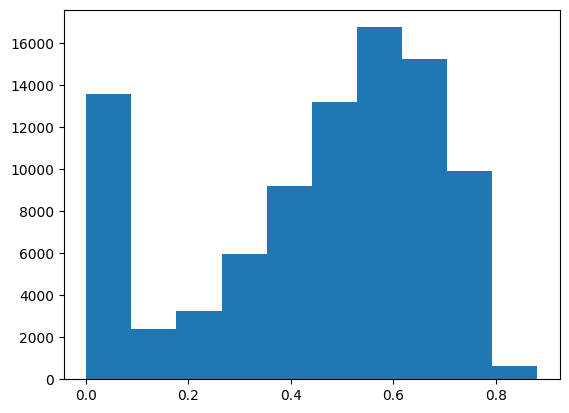

In [69]:
plt.hist(test_pred_total_mean)

In [70]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler.csv', index=False)